# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [60]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))

    three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
# traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


In [64]:
traveler_trips

NameError: name 'traveler_trip' is not defined

In [52]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_modechoice08,darp_solutions_modechoice08=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-07-15 23:03:03.439493
1 9 2018-07-15 23:03:04.055529
2 16 2018-07-15 23:03:04.885577
3 13 2018-07-15 23:03:05.655623
4 27 2018-07-15 23:03:07.159710
5 9 2018-07-15 23:03:07.552734
6 9 2018-07-15 23:03:08.002760
7 8 2018-07-15 23:03:08.447787
8 9 2018-07-15 23:03:09.051820
9 8 2018-07-15 23:03:09.438849
10 7 2018-07-15 23:03:09.736861
11 11 2018-07-15 23:03:11.062939
12 12 2018-07-15 23:03:11.500964
13 4 2018-07-15 23:03:11.683976
14 9 2018-07-15 23:03:12.090000
15 14 2018-07-15 23:03:12.967051
16 14 2018-07-15 23:03:13.785100
17 11 2018-07-15 23:03:14.352138
18 8 2018-07-15 23:03:14.679152
19 6 2018-07-15 23:03:14.962168
20 5 2018-07-15 23:03:15.202182
21 6 2018-07-15 23:03:15.516201
22 10 2018-07-15 23:03:15.940225
23 19 2018-07-15 23:03:16.984289
24 18 2018-07-15 23:03:17.765335
25 14 2018-07-15 23:03:19.242423
26 6 2018-07-15 23:03:19.604441
27 11 2018-07-15 23:03:20.155473
28 6 2018-07-15 23:03:20.434495
29 5 2018-07-15 23:03:20.722507
3

243 15 2018-07-15 23:05:56.503662
244 21 2018-07-15 23:05:58.025752
245 16 2018-07-15 23:05:58.784802
246 10 2018-07-15 23:05:59.272830
247 10 2018-07-15 23:05:59.994868
248 9 2018-07-15 23:06:00.404898
249 10 2018-07-15 23:06:00.885926
250 12 2018-07-15 23:06:01.700969
251 21 2018-07-15 23:06:02.701032
252 27 2018-07-15 23:06:05.297180
253 2 2018-07-15 23:06:05.448189
254 20 2018-07-15 23:06:09.017405
255 4 2018-07-15 23:06:09.225410
256 18 2018-07-15 23:06:10.530488
257 11 2018-07-15 23:06:10.910509
258 14 2018-07-15 23:06:11.440546
259 8 2018-07-15 23:06:11.810563
260 10 2018-07-15 23:06:12.242588
261 26 2018-07-15 23:06:15.149765
262 25 2018-07-15 23:06:26.077401
263 11 2018-07-15 23:06:26.677437
264 2 2018-07-15 23:06:26.828446
265 13 2018-07-15 23:06:27.408480
266 13 2018-07-15 23:06:28.246529
267 9 2018-07-15 23:06:28.629551
268 10 2018-07-15 23:06:29.097579
269 4 2018-07-15 23:06:29.228586
270 10 2018-07-15 23:06:29.525610
271 7 2018-07-15 23:06:29.808620
272 9 2018-07-15 23:06

483 9 2018-07-15 23:08:46.495660
484 8 2018-07-15 23:08:46.849675
485 4 2018-07-15 23:08:47.082689
486 17 2018-07-15 23:08:47.783731
487 10 2018-07-15 23:08:48.134750
488 14 2018-07-15 23:08:49.043811
489 7 2018-07-15 23:08:49.342821
490 11 2018-07-15 23:08:49.687842
491 9 2018-07-15 23:08:50.057869
492 14 2018-07-15 23:08:50.583899
493 9 2018-07-15 23:08:51.006925
494 7 2018-07-15 23:08:51.321938
495 7 2018-07-15 23:08:51.562952
496 7 2018-07-15 23:08:51.860969
497 5 2018-07-15 23:08:52.091983
498 8 2018-07-15 23:08:52.454005
499 9 2018-07-15 23:08:52.846028
500 11 2018-07-15 23:08:53.364061
Estimate Route for the  500 th household  2018-07-15 23:08:53.373059
501 7 2018-07-15 23:08:53.666077
502 16 2018-07-15 23:08:54.164106
503 18 2018-07-15 23:08:54.908149
504 20 2018-07-15 23:08:56.235227
505 10 2018-07-15 23:08:57.162281
506 12 2018-07-15 23:08:58.653371
507 5 2018-07-15 23:08:59.119398
508 11 2018-07-15 23:08:59.964446
509 8 2018-07-15 23:09:00.327474
510 2 2018-07-15 23:09:00.48

722 19 2018-07-15 23:10:59.479470
723 15 2018-07-15 23:11:00.883552
724 8 2018-07-15 23:11:01.126573
725 4 2018-07-15 23:11:01.304583
726 3 2018-07-15 23:11:01.462592
727 5 2018-07-15 23:11:01.731608
728 13 2018-07-15 23:11:03.260698
729 13 2018-07-15 23:11:04.099742
730 4 2018-07-15 23:11:04.281752
731 18 2018-07-15 23:11:06.019855
732 7 2018-07-15 23:11:06.352876
733 14 2018-07-15 23:11:06.964911
734 13 2018-07-15 23:11:09.062034
735 11 2018-07-15 23:11:10.255109
736 13 2018-07-15 23:11:11.107157
737 19 2018-07-15 23:11:12.368229
738 10 2018-07-15 23:11:12.905260
739 5 2018-07-15 23:11:13.164280
740 19 2018-07-15 23:11:14.500359
741 6 2018-07-15 23:11:14.772370
742 9 2018-07-15 23:11:15.181398
743 12 2018-07-15 23:11:15.783429
744 12 2018-07-15 23:11:16.291459
745 14 2018-07-15 23:11:16.929501
746 7 2018-07-15 23:11:17.164515
747 14 2018-07-15 23:11:17.832552
748 8 2018-07-15 23:11:18.222577
749 13 2018-07-15 23:11:18.942614
750 3 2018-07-15 23:11:19.106623
751 12 2018-07-15 23:11:19

963 7 2018-07-15 23:13:38.875840
964 5 2018-07-15 23:13:39.160857
965 19 2018-07-15 23:13:40.086916
966 10 2018-07-15 23:13:40.531936
967 15 2018-07-15 23:13:41.138973
968 8 2018-07-15 23:13:41.563997
969 8 2018-07-15 23:13:41.972021
970 3 2018-07-15 23:13:42.144032
971 15 2018-07-15 23:13:42.900076
972 8 2018-07-15 23:13:43.138090
973 5 2018-07-15 23:13:43.370108
974 11 2018-07-15 23:13:43.994140
975 6 2018-07-15 23:13:44.255155
976 4 2018-07-15 23:13:44.501170
977 21 2018-07-15 23:13:47.613354
978 10 2018-07-15 23:13:48.124383
979 5 2018-07-15 23:13:48.727418
980 11 2018-07-15 23:13:49.345456
981 19 2018-07-15 23:13:50.211508
982 19 2018-07-15 23:13:50.891546
983 20 2018-07-15 23:13:54.020730
984 8 2018-07-15 23:13:54.899782
985 7 2018-07-15 23:13:55.209800
986 2 2018-07-15 23:13:55.362808
987 10 2018-07-15 23:13:56.660884
988 6 2018-07-15 23:13:56.920905
989 16 2018-07-15 23:13:57.832953
990 8 2018-07-15 23:13:58.164973
991 5 2018-07-15 23:13:58.430988
992 15 2018-07-15 23:13:59.305

1198 14 2018-07-15 23:16:02.627294
1199 4 2018-07-15 23:16:02.827300
1200 3 2018-07-15 23:16:02.993315
Estimate Route for the  1200 th household  2018-07-15 23:16:03.009319
1201 12 2018-07-15 23:16:03.558343
1202 5 2018-07-15 23:16:03.821358
1203 20 2018-07-15 23:16:07.022547
1204 14 2018-07-15 23:16:08.274622
1205 13 2018-07-15 23:16:09.034665
1206 8 2018-07-15 23:16:09.371684
1207 3 2018-07-15 23:16:09.563696
1208 13 2018-07-15 23:16:10.409745
1209 4 2018-07-15 23:16:10.597762
1210 7 2018-07-15 23:16:10.913776
1211 16 2018-07-15 23:16:11.855831
1212 10 2018-07-15 23:16:12.571872
1213 1 2018-07-15 23:16:12.680879
1214 8 2018-07-15 23:16:12.929893
1215 7 2018-07-15 23:16:13.245912
1216 9 2018-07-15 23:16:13.521934
1217 7 2018-07-15 23:16:13.750949
1218 24 2018-07-15 23:16:15.550055
1219 8 2018-07-15 23:16:15.928071
1220 5 2018-07-15 23:16:16.213088
1221 13 2018-07-15 23:16:16.726122
1222 5 2018-07-15 23:16:16.988134
1223 4 2018-07-15 23:16:17.140141
1224 6 2018-07-15 23:16:17.413156
12

1430 8 2018-07-15 23:18:48.850059
1431 11 2018-07-15 23:18:49.325086
1432 12 2018-07-15 23:18:49.957125
1433 11 2018-07-15 23:18:50.309144
1434 3 2018-07-15 23:18:50.492155
1435 5 2018-07-15 23:18:50.727168
1436 17 2018-07-15 23:18:51.469215
1437 14 2018-07-15 23:18:52.010243
1438 24 2018-07-15 23:18:54.196378
1439 12 2018-07-15 23:18:54.921420
1440 11 2018-07-15 23:18:55.416445
1441 6 2018-07-15 23:18:55.695461
1442 10 2018-07-15 23:18:56.845529
1443 4 2018-07-15 23:18:57.115546
1444 14 2018-07-15 23:18:57.646576
1445 16 2018-07-15 23:18:58.237610
1446 14 2018-07-15 23:18:59.012661
1447 16 2018-07-15 23:19:01.109780
1448 8 2018-07-15 23:19:01.446801
1449 19 2018-07-15 23:19:04.380972
1450 14 2018-07-15 23:19:05.984069
1451 5 2018-07-15 23:19:06.265081
1452 5 2018-07-15 23:19:06.511097
1453 9 2018-07-15 23:19:07.002124
1454 8 2018-07-15 23:19:07.295142
1455 14 2018-07-15 23:19:07.899178
1456 10 2018-07-15 23:19:08.399207
1457 11 2018-07-15 23:19:08.990242
1458 10 2018-07-15 23:19:10.18

1664 23 2018-07-15 23:22:04.437554
1665 12 2018-07-15 23:22:05.743631
1666 6 2018-07-15 23:22:06.168656
1667 12 2018-07-15 23:22:07.181715
1668 10 2018-07-15 23:22:07.582745
1669 3 2018-07-15 23:22:07.757749
1670 11 2018-07-15 23:22:08.414788
1671 8 2018-07-15 23:22:08.904816
1672 14 2018-07-15 23:22:09.887880
1673 3 2018-07-15 23:22:10.122890
1674 14 2018-07-15 23:22:11.153951
1675 4 2018-07-15 23:22:11.341961
1676 6 2018-07-15 23:22:11.594976
1677 6 2018-07-15 23:22:11.857990
1678 6 2018-07-15 23:22:12.191009
1679 10 2018-07-15 23:22:13.222070
1680 10 2018-07-15 23:22:13.541088
1681 15 2018-07-15 23:22:14.875173
1682 11 2018-07-15 23:22:15.448207
1683 6 2018-07-15 23:22:15.672215
1684 7 2018-07-15 23:22:16.007236
1685 7 2018-07-15 23:22:16.294257
1686 16 2018-07-15 23:22:16.897286
1687 7 2018-07-15 23:22:17.605332
1688 7 2018-07-15 23:22:18.030355
1689 14 2018-07-15 23:22:19.052418
1690 8 2018-07-15 23:22:19.429435
1691 10 2018-07-15 23:22:19.954466
1692 4 2018-07-15 23:22:20.187480


1898 9 2018-07-15 23:24:37.678566
1899 8 2018-07-15 23:24:38.089585
1900 22 2018-07-15 23:24:39.006639
Estimate Route for the  1900 th household  2018-07-15 23:24:39.029639
1901 14 2018-07-15 23:24:39.893690
1902 18 2018-07-15 23:24:40.757741
1903 3 2018-07-15 23:24:40.926751
1904 9 2018-07-15 23:24:41.209768
1905 5 2018-07-15 23:24:41.485784
1906 9 2018-07-15 23:24:41.768801
1907 12 2018-07-15 23:24:42.998873
1908 12 2018-07-15 23:24:43.694919
1909 8 2018-07-15 23:24:44.055936
1910 8 2018-07-15 23:24:44.433959
1911 12 2018-07-15 23:24:45.163000
1912 16 2018-07-15 23:24:46.496079
1913 11 2018-07-15 23:24:47.362131
1914 8 2018-07-15 23:24:47.811157
1915 12 2018-07-15 23:24:48.349187
1916 12 2018-07-15 23:24:49.082231
1917 10 2018-07-15 23:24:49.456258
1918 9 2018-07-15 23:24:49.866277
1919 6 2018-07-15 23:24:50.255300
1920 5 2018-07-15 23:24:50.515315
1921 11 2018-07-15 23:24:51.472373
1922 2 2018-07-15 23:24:51.644382
1923 2 2018-07-15 23:24:51.818392
1924 20 2018-07-15 23:24:53.245480

2130 12 2018-07-15 23:27:49.743852
2131 3 2018-07-15 23:27:49.988863
2132 10 2018-07-15 23:27:50.633905
2133 16 2018-07-15 23:27:52.644021
2134 9 2018-07-15 23:27:53.226055
2135 13 2018-07-15 23:27:54.757148
2136 9 2018-07-15 23:27:55.478188
2137 22 2018-07-15 23:27:56.413242
2138 14 2018-07-15 23:27:58.613376
2139 10 2018-07-15 23:27:59.213408
2140 11 2018-07-15 23:28:00.345479
2141 4 2018-07-15 23:28:00.565488
2142 15 2018-07-15 23:28:01.749556
2143 7 2018-07-15 23:28:02.240587
2144 10 2018-07-15 23:28:02.691612
2145 6 2018-07-15 23:28:02.939625
2146 4 2018-07-15 23:28:03.150637
2147 9 2018-07-15 23:28:03.799678
2148 11 2018-07-15 23:28:04.764734
2149 19 2018-07-15 23:28:06.728850
2150 5 2018-07-15 23:28:07.219877
2151 19 2018-07-15 23:28:09.189994
2152 10 2018-07-15 23:28:09.573015
2153 8 2018-07-15 23:28:10.010040
2154 4 2018-07-15 23:28:10.193053
2155 7 2018-07-15 23:28:10.504070
2156 19 2018-07-15 23:28:12.823206
2157 11 2018-07-15 23:28:13.241231
2158 27 2018-07-15 23:28:16.4384

2364 8 2018-07-15 23:31:20.574248
2365 4 2018-07-15 23:31:20.781253
2366 11 2018-07-15 23:31:21.363288
2367 11 2018-07-15 23:31:21.905319
2368 15 2018-07-15 23:31:23.600421
2369 6 2018-07-15 23:31:23.907443
2370 8 2018-07-15 23:31:24.173458
2371 10 2018-07-15 23:31:24.597483
2372 2 2018-07-15 23:31:24.763487
2373 7 2018-07-15 23:31:25.071506
2374 18 2018-07-15 23:31:25.873558
2375 5 2018-07-15 23:31:26.107566
2376 10 2018-07-15 23:31:26.549592
2377 12 2018-07-15 23:31:27.067623
2378 12 2018-07-15 23:31:27.487647
2379 10 2018-07-15 23:31:27.811667
2380 7 2018-07-15 23:31:28.170695
2381 5 2018-07-15 23:31:28.483711
2382 3 2018-07-15 23:31:28.656721
2383 8 2018-07-15 23:31:29.019743
2384 9 2018-07-15 23:31:29.460764
2385 2 2018-07-15 23:31:29.627773
2386 7 2018-07-15 23:31:29.876787
2387 6 2018-07-15 23:31:30.144804
2388 5 2018-07-15 23:31:30.390820
2389 6 2018-07-15 23:31:30.656834
2390 3 2018-07-15 23:31:30.833845
2391 2 2018-07-15 23:31:31.007854
2392 8 2018-07-15 23:31:31.268870
2393 

2599 6 2018-07-15 23:33:35.188156
2600 3 2018-07-15 23:33:35.350163
Estimate Route for the  2600 th household  2018-07-15 23:33:35.379164
2601 7 2018-07-15 23:33:35.676182
2602 8 2018-07-15 23:33:36.036203
2603 15 2018-07-15 23:33:36.963262
2604 8 2018-07-15 23:33:37.362282
2605 9 2018-07-15 23:33:37.765304
2606 11 2018-07-15 23:33:38.128326
2607 5 2018-07-15 23:33:38.348338
2608 10 2018-07-15 23:33:38.857369
2609 2 2018-07-15 23:33:39.028385
2610 5 2018-07-15 23:33:39.201389
2611 9 2018-07-15 23:33:39.627415
2612 11 2018-07-15 23:33:40.521467
2613 7 2018-07-15 23:33:40.769484
2614 10 2018-07-15 23:33:41.266512
2615 3 2018-07-15 23:33:41.465524
2616 6 2018-07-15 23:33:41.805543
2617 8 2018-07-15 23:33:42.186564
2618 8 2018-07-15 23:33:42.551585
2619 9 2018-07-15 23:33:42.912607
2620 30 2018-07-15 23:33:48.705953
2621 5 2018-07-15 23:33:48.981964
2622 7 2018-07-15 23:33:49.257980
2623 10 2018-07-15 23:33:49.738009
2624 7 2018-07-15 23:33:50.066027
2625 2 2018-07-15 23:33:50.232042
2626 

2832 8 2018-07-15 23:36:17.683709
2833 2 2018-07-15 23:36:17.851714
2834 7 2018-07-15 23:36:18.175734
2835 5 2018-07-15 23:36:18.648761
2836 2 2018-07-15 23:36:18.828771
2837 4 2018-07-15 23:36:19.030784
2838 3 2018-07-15 23:36:19.233800
2839 5 2018-07-15 23:36:19.464815
2840 5 2018-07-15 23:36:19.717828
2841 12 2018-07-15 23:36:21.133913
2842 10 2018-07-15 23:36:21.653938
2843 19 2018-07-15 23:36:22.807005
2844 7 2018-07-15 23:36:23.385038
2845 5 2018-07-15 23:36:23.697057
2846 8 2018-07-15 23:36:23.990074
2847 5 2018-07-15 23:36:24.261090
2848 10 2018-07-15 23:36:24.619117
2849 4 2018-07-15 23:36:24.813128
2850 11 2018-07-15 23:36:25.353155
2851 6 2018-07-15 23:36:25.643171
2852 8 2018-07-15 23:36:26.138201
2853 9 2018-07-15 23:36:26.554231
2854 2 2018-07-15 23:36:26.722241
2855 11 2018-07-15 23:36:27.127259
2856 10 2018-07-15 23:36:27.485286
2857 14 2018-07-15 23:36:28.887368
2858 16 2018-07-15 23:36:29.607404
2859 4 2018-07-15 23:36:29.843418
2860 14 2018-07-15 23:36:30.522460
2861

3067 15 2018-07-15 23:38:25.145201
3068 7 2018-07-15 23:38:25.379209
3069 7 2018-07-15 23:38:25.854239
3070 15 2018-07-15 23:38:27.060311
3071 14 2018-07-15 23:38:27.599340
3072 13 2018-07-15 23:38:28.689406
3073 7 2018-07-15 23:38:29.032424
3074 6 2018-07-15 23:38:29.355448
3075 6 2018-07-15 23:38:29.693463
3076 11 2018-07-15 23:38:30.260497
3077 2 2018-07-15 23:38:30.440508
3078 4 2018-07-15 23:38:30.701522
3079 12 2018-07-15 23:38:31.635577
3080 4 2018-07-15 23:38:31.865591
3081 7 2018-07-15 23:38:32.410623
3082 5 2018-07-15 23:38:32.817647
3083 5 2018-07-15 23:38:33.070661
3084 12 2018-07-15 23:38:33.456689
3085 6 2018-07-15 23:38:33.728705
3086 17 2018-07-15 23:38:34.959772
3087 10 2018-07-15 23:38:35.283791
3088 18 2018-07-15 23:38:35.976837
3089 11 2018-07-15 23:38:36.349860
3090 2 2018-07-15 23:38:36.526869
3091 3 2018-07-15 23:38:36.706875
3092 9 2018-07-15 23:38:37.149901
3093 10 2018-07-15 23:38:37.629930
3094 14 2018-07-15 23:38:38.275967
3095 2 2018-07-15 23:38:38.447977
3

3301 4 2018-07-15 23:41:00.564332
3302 7 2018-07-15 23:41:00.836347
3303 7 2018-07-15 23:41:01.183367
3304 3 2018-07-15 23:41:01.398379
3305 6 2018-07-15 23:41:01.641393
3306 7 2018-07-15 23:41:01.976419
3307 5 2018-07-15 23:41:02.185426
3308 8 2018-07-15 23:41:02.602457
3309 6 2018-07-15 23:41:02.885473
3310 4 2018-07-15 23:41:03.103479
3311 10 2018-07-15 23:41:03.612509
3312 5 2018-07-15 23:41:03.871530
3313 12 2018-07-15 23:41:04.300550
3314 9 2018-07-15 23:41:04.725581
3315 6 2018-07-15 23:41:05.032593
3316 1 2018-07-15 23:41:05.167602
3317 7 2018-07-15 23:41:05.374614
3318 4 2018-07-15 23:41:05.602626
3319 11 2018-07-15 23:41:06.150659
3320 13 2018-07-15 23:41:06.682690
3321 12 2018-07-15 23:41:07.449736
3322 5 2018-07-15 23:41:07.740752
3323 6 2018-07-15 23:41:08.047770
3324 4 2018-07-15 23:41:08.333788
3325 10 2018-07-15 23:41:08.920826
3326 3 2018-07-15 23:41:09.102832
3327 4 2018-07-15 23:41:09.286844
3328 6 2018-07-15 23:41:09.595866
3329 1 2018-07-15 23:41:09.735869
3330 13 

3536 16 2018-07-15 23:43:24.542793
3537 3 2018-07-15 23:43:24.740807
3538 16 2018-07-15 23:43:25.463847
3539 11 2018-07-15 23:43:26.273900
3540 6 2018-07-15 23:43:26.665918
3541 4 2018-07-15 23:43:26.874935
3542 14 2018-07-15 23:43:29.010055
3543 5 2018-07-15 23:43:29.330074
3544 6 2018-07-15 23:43:29.626096
3545 13 2018-07-15 23:43:31.457200
3546 11 2018-07-15 23:43:33.322309
3547 4 2018-07-15 23:43:33.562324
3548 6 2018-07-15 23:43:33.840339
3549 8 2018-07-15 23:43:34.226362
3550 7 2018-07-15 23:43:34.472377
3551 8 2018-07-15 23:43:34.959405
3552 5 2018-07-15 23:43:35.248421
3553 5 2018-07-15 23:43:35.542439
3554 5 2018-07-15 23:43:35.800454
3555 9 2018-07-15 23:43:36.144481
3556 4 2018-07-15 23:43:36.379489
3557 15 2018-07-15 23:43:37.383553
3558 3 2018-07-15 23:43:37.585564
3559 9 2018-07-15 23:43:38.032590
3560 7 2018-07-15 23:43:38.436610
3561 10 2018-07-15 23:43:38.785635
3562 13 2018-07-15 23:43:39.406666
3563 11 2018-07-15 23:43:39.773690
3564 8 2018-07-15 23:43:40.176715
3565

3771 8 2018-07-15 23:45:40.237768
3772 5 2018-07-15 23:45:40.477782
3773 13 2018-07-15 23:45:41.069824
3774 9 2018-07-15 23:45:41.580853
3775 2 2018-07-15 23:45:41.847863
3776 20 2018-07-15 23:45:43.887982
3777 9 2018-07-15 23:45:44.322008
3778 11 2018-07-15 23:45:44.689029
3779 8 2018-07-15 23:45:45.052056
3780 8 2018-07-15 23:45:45.414073
3781 10 2018-07-15 23:45:45.983108
3782 10 2018-07-15 23:45:46.689148
3783 9 2018-07-15 23:45:48.317246
3784 10 2018-07-15 23:45:48.704266
3785 6 2018-07-15 23:45:48.997283
3786 7 2018-07-15 23:45:49.378306
3787 5 2018-07-15 23:45:49.673322
3788 5 2018-07-15 23:45:49.949342
3789 3 2018-07-15 23:45:50.178352
3790 7 2018-07-15 23:45:50.471374
3791 3 2018-07-15 23:45:50.702383
3792 7 2018-07-15 23:45:51.041403
3793 5 2018-07-15 23:45:51.336420
3794 6 2018-07-15 23:45:51.612437
3795 5 2018-07-15 23:45:51.868452
3796 2 2018-07-15 23:45:52.057464
3797 14 2018-07-15 23:45:52.537494
3798 8 2018-07-15 23:45:53.131532
3799 7 2018-07-15 23:45:53.468546
3800 8 

4005 4 2018-07-15 23:47:54.266645
4006 14 2018-07-15 23:47:55.551727
4007 2 2018-07-15 23:47:55.730737
4008 8 2018-07-15 23:47:56.124755
4009 5 2018-07-15 23:47:56.379770
4010 2 2018-07-15 23:47:56.559780
4011 12 2018-07-15 23:47:57.278823
4012 10 2018-07-15 23:47:57.619843
4013 10 2018-07-15 23:47:58.159875
4014 5 2018-07-15 23:47:58.461892
4015 5 2018-07-15 23:47:58.669905
4016 6 2018-07-15 23:47:58.976924
4017 12 2018-07-15 23:47:59.418950
4018 8 2018-07-15 23:48:00.356010
4019 9 2018-07-15 23:48:00.701024
4020 3 2018-07-15 23:48:00.907036
4021 4 2018-07-15 23:48:01.150050
4022 18 2018-07-15 23:48:03.311177
4023 14 2018-07-15 23:48:04.272234
4024 4 2018-07-15 23:48:04.443244
4025 4 2018-07-15 23:48:04.670257
4026 17 2018-07-15 23:48:06.803388
4027 6 2018-07-15 23:48:07.066404
4028 7 2018-07-15 23:48:07.374419
4029 12 2018-07-15 23:48:07.845444
4030 9 2018-07-15 23:48:08.289470
4031 25 2018-07-15 23:48:10.287593
4032 20 2018-07-15 23:48:12.213702
4033 8 2018-07-15 23:48:12.657727
403

4240 8 2018-07-15 23:49:53.846674
4241 16 2018-07-15 23:49:54.450709
4242 3 2018-07-15 23:49:54.637720
4243 11 2018-07-15 23:49:55.201754
4244 9 2018-07-15 23:49:55.631779
4245 4 2018-07-15 23:49:55.833791
4246 7 2018-07-15 23:49:56.164810
4247 10 2018-07-15 23:49:56.672840
4248 8 2018-07-15 23:49:56.931861
4249 6 2018-07-15 23:49:57.245880
4250 12 2018-07-15 23:49:58.151927
4251 20 2018-07-15 23:49:58.970975
4252 6 2018-07-15 23:49:59.283994
4253 7 2018-07-15 23:49:59.641016
4254 14 2018-07-15 23:50:00.173046
4255 11 2018-07-15 23:50:01.025096
4256 13 2018-07-15 23:50:02.169163
4257 4 2018-07-15 23:50:02.374175
4258 6 2018-07-15 23:50:02.651197
4259 6 2018-07-15 23:50:02.958209
4260 2 2018-07-15 23:50:03.133220
4261 9 2018-07-15 23:50:03.601247
4262 10 2018-07-15 23:50:04.055274
4263 13 2018-07-15 23:50:04.512306
4264 15 2018-07-15 23:50:06.806436
4265 6 2018-07-15 23:50:07.120454
4266 12 2018-07-15 23:50:07.573482
4267 3 2018-07-15 23:50:07.802496
4268 8 2018-07-15 23:50:08.294530
42

4475 2 2018-07-15 23:51:59.528061
4476 7 2018-07-15 23:51:59.889082
4477 9 2018-07-15 23:52:00.353113
4478 3 2018-07-15 23:52:00.559121
4479 12 2018-07-15 23:52:03.609307
4480 10 2018-07-15 23:52:04.121331
4481 4 2018-07-15 23:52:04.337343
4482 11 2018-07-15 23:52:05.016383
4483 4 2018-07-15 23:52:05.175393
4484 3 2018-07-15 23:52:05.358404
4485 10 2018-07-15 23:52:06.815495
4486 5 2018-07-15 23:52:07.074505
4487 8 2018-07-15 23:52:07.401524
4488 4 2018-07-15 23:52:07.589535
4489 6 2018-07-15 23:52:07.838549
4490 11 2018-07-15 23:52:09.266639
4491 10 2018-07-15 23:52:09.591659
4492 4 2018-07-15 23:52:09.798671
4493 8 2018-07-15 23:52:10.157691
4494 9 2018-07-15 23:52:10.487705
4495 8 2018-07-15 23:52:10.914732
4496 11 2018-07-15 23:52:11.554768
4497 2 2018-07-15 23:52:11.766780
4498 4 2018-07-15 23:52:12.027795
4499 11 2018-07-15 23:52:12.500824
4500 8 2018-07-15 23:52:12.896846
Estimate Route for the  4500 th household  2018-07-15 23:52:12.938849
4501 11 2018-07-15 23:52:13.698894
450

4708 11 2018-07-15 23:54:08.130620
4709 11 2018-07-15 23:54:08.711654
4710 7 2018-07-15 23:54:09.040673
4711 7 2018-07-15 23:54:09.291687
4712 8 2018-07-15 23:54:09.689711
4713 4 2018-07-15 23:54:09.910725
4714 2 2018-07-15 23:54:10.099736
4715 8 2018-07-15 23:54:10.532767
4716 9 2018-07-15 23:54:10.836778
4717 8 2018-07-15 23:54:11.226802
4718 4 2018-07-15 23:54:11.494817
4719 13 2018-07-15 23:54:12.269863
4720 4 2018-07-15 23:54:12.474875
4721 11 2018-07-15 23:54:12.975904
4722 7 2018-07-15 23:54:13.272922
4723 15 2018-07-15 23:54:14.007968
4724 6 2018-07-15 23:54:14.288981
4725 10 2018-07-15 23:54:14.667004
4726 10 2018-07-15 23:54:14.990023
4727 2 2018-07-15 23:54:15.119031
4728 3 2018-07-15 23:54:15.317042
4729 4 2018-07-15 23:54:15.587058
4730 10 2018-07-15 23:54:16.095089
4731 5 2018-07-15 23:54:16.447109
4732 13 2018-07-15 23:54:16.903138
4733 3 2018-07-15 23:54:17.076145
4734 10 2018-07-15 23:54:17.498170
4735 18 2018-07-15 23:54:18.153209
4736 12 2018-07-15 23:54:18.888252
47

4943 9 2018-07-15 23:56:08.891718
4944 1 2018-07-15 23:56:09.031726
4945 5 2018-07-15 23:56:09.310742
4946 5 2018-07-15 23:56:09.580758
4947 5 2018-07-15 23:56:09.882776
4948 13 2018-07-15 23:56:10.937839
4949 4 2018-07-15 23:56:11.119848
4950 4 2018-07-15 23:56:11.385869
4951 21 2018-07-15 23:56:12.508936
4952 14 2018-07-15 23:56:14.856075
4953 7 2018-07-15 23:56:15.199088
4954 4 2018-07-15 23:56:15.449103
4955 12 2018-07-15 23:56:16.228149
4956 6 2018-07-15 23:56:16.527167
4957 13 2018-07-15 23:56:17.012195
4958 9 2018-07-15 23:56:17.414218
4959 12 2018-07-15 23:56:18.198265
4960 6 2018-07-15 23:56:18.505283
4961 6 2018-07-15 23:56:18.811301
4962 13 2018-07-15 23:56:19.265327
4963 1 2018-07-15 23:56:19.403335
4964 2 2018-07-15 23:56:19.585346
4965 3 2018-07-15 23:56:19.758356
4966 2 2018-07-15 23:56:19.947368
4967 4 2018-07-15 23:56:20.181381
4968 4 2018-07-15 23:56:20.487399
4969 14 2018-07-15 23:56:20.980428
4970 2 2018-07-15 23:56:21.161439
4971 13 2018-07-15 23:56:21.784475
4972 

5178 7 2018-07-15 23:57:58.455163
5179 5 2018-07-15 23:57:58.747174
5180 5 2018-07-15 23:57:58.954187
5181 5 2018-07-15 23:57:59.211201
5182 7 2018-07-15 23:57:59.618225
5183 7 2018-07-15 23:57:59.894242
5184 16 2018-07-15 23:58:01.169322
5185 10 2018-07-15 23:58:01.518337
5186 6 2018-07-15 23:58:01.800354
5187 21 2018-07-15 23:58:03.155433
5188 3 2018-07-15 23:58:03.329445
5189 5 2018-07-15 23:58:03.589459
5190 10 2018-07-15 23:58:04.285501
5191 6 2018-07-15 23:58:04.618519
5192 4 2018-07-15 23:58:04.827531
5193 7 2018-07-15 23:58:05.158551
5194 5 2018-07-15 23:58:05.455569
5195 4 2018-07-15 23:58:05.666587
5196 5 2018-07-15 23:58:05.925601
5197 7 2018-07-15 23:58:06.280617
5198 4 2018-07-15 23:58:06.490629
5199 10 2018-07-15 23:58:06.871653
5200 8 2018-07-15 23:58:07.257674
Estimate Route for the  5200 th household  2018-07-15 23:58:07.302677
5201 11 2018-07-15 23:58:07.908713
5202 11 2018-07-15 23:58:09.073781
5203 2 2018-07-15 23:58:09.256792
5204 10 2018-07-15 23:58:09.806824
5205

5411 11 2018-07-15 23:59:52.427857
5412 7 2018-07-15 23:59:52.700872
5413 1 2018-07-15 23:59:52.848886
5414 12 2018-07-15 23:59:53.233908
5415 12 2018-07-15 23:59:55.009007
5416 7 2018-07-15 23:59:55.287024
5417 6 2018-07-15 23:59:55.637044
5418 1 2018-07-15 23:59:55.794054
5419 4 2018-07-15 23:59:56.012067
5420 16 2018-07-15 23:59:56.706108
5421 12 2018-07-15 23:59:57.297148
5422 7 2018-07-15 23:59:57.585159
5423 4 2018-07-15 23:59:57.806172
5424 17 2018-07-15 23:59:59.012245
5425 12 2018-07-16 00:00:00.111308
5426 14 2018-07-16 00:00:01.047362
5427 12 2018-07-16 00:00:01.466387
5428 6 2018-07-16 00:00:01.776406
5429 20 2018-07-16 00:00:02.572452
5430 10 2018-07-16 00:00:02.900471
5431 4 2018-07-16 00:00:03.138485
5432 6 2018-07-16 00:00:03.463505
5433 5 2018-07-16 00:00:03.773523
5434 10 2018-07-16 00:00:04.151545
5435 13 2018-07-16 00:00:05.098601
5436 9 2018-07-16 00:00:06.351674
5437 11 2018-07-16 00:00:06.739697
5438 1 2018-07-16 00:00:06.876705
5439 14 2018-07-16 00:00:07.775758

5646 11 2018-07-16 00:01:45.319491
5647 8 2018-07-16 00:01:45.701513
5648 9 2018-07-16 00:01:46.011532
5649 4 2018-07-16 00:01:46.229545
5650 11 2018-07-16 00:01:46.821580
5651 2 2018-07-16 00:01:47.006590
5652 16 2018-07-16 00:01:47.947647
5653 7 2018-07-16 00:01:48.282665
5654 1 2018-07-16 00:01:48.434675
5655 4 2018-07-16 00:01:48.673688
5656 12 2018-07-16 00:01:49.373730
5657 1 2018-07-16 00:01:49.509737
5658 5 2018-07-16 00:01:49.744751
5659 10 2018-07-16 00:01:50.249782
5660 15 2018-07-16 00:01:51.043829
5661 4 2018-07-16 00:01:51.325845
5662 2 2018-07-16 00:01:51.518856
5663 10 2018-07-16 00:01:52.031886
5664 7 2018-07-16 00:01:52.292901
5665 3 2018-07-16 00:01:52.467911
5666 3 2018-07-16 00:01:52.644922
5667 14 2018-07-16 00:01:53.361964
5668 7 2018-07-16 00:01:53.637980
5669 11 2018-07-16 00:01:54.016003
5670 7 2018-07-16 00:01:54.297019
5671 8 2018-07-16 00:01:54.716044
5672 12 2018-07-16 00:01:55.419085
5673 7 2018-07-16 00:01:56.032121
5674 6 2018-07-16 00:01:56.350141
5675

5881 4 2018-07-16 00:03:24.016292
5882 11 2018-07-16 00:03:24.789344
5883 4 2018-07-16 00:03:25.029358
5884 5 2018-07-16 00:03:25.340377
5885 5 2018-07-16 00:03:25.659395
5886 5 2018-07-16 00:03:25.930410
5887 6 2018-07-16 00:03:26.253429
5888 5 2018-07-16 00:03:26.516445
5889 3 2018-07-16 00:03:26.692455
5890 4 2018-07-16 00:03:26.968466
5891 9 2018-07-16 00:03:27.450494
5892 13 2018-07-16 00:03:29.499614
5893 5 2018-07-16 00:03:29.762630
5894 3 2018-07-16 00:03:29.960647
5895 10 2018-07-16 00:03:30.470671
5896 4 2018-07-16 00:03:30.673684
5897 11 2018-07-16 00:03:31.025704
5898 16 2018-07-16 00:03:31.583737
5899 10 2018-07-16 00:03:32.013762
5900 6 2018-07-16 00:03:32.306780
Estimate Route for the  5900 th household  2018-07-16 00:03:32.350782
5901 4 2018-07-16 00:03:32.534794
5902 8 2018-07-16 00:03:32.817816
5903 6 2018-07-16 00:03:33.121829
5904 4 2018-07-16 00:03:33.363842
5905 7 2018-07-16 00:03:33.715862
5906 4 2018-07-16 00:03:33.930875
5907 8 2018-07-16 00:03:34.200891
5908 7

6115 15 2018-07-16 00:05:06.845342
6116 7 2018-07-16 00:05:07.176360
6117 20 2018-07-16 00:05:09.241477
6118 8 2018-07-16 00:05:09.637501
6119 6 2018-07-16 00:05:09.957519
6120 9 2018-07-16 00:05:10.281538
6121 2 2018-07-16 00:05:10.475549
6122 5 2018-07-16 00:05:10.689562
6123 7 2018-07-16 00:05:11.055583
6124 5 2018-07-16 00:05:11.357601
6125 9 2018-07-16 00:05:11.670620
6126 10 2018-07-16 00:05:12.209658
6127 14 2018-07-16 00:05:13.197710
6128 4 2018-07-16 00:05:13.415723
6129 6 2018-07-16 00:05:13.758743
6130 14 2018-07-16 00:05:14.558790
6131 7 2018-07-16 00:05:14.891809
6132 9 2018-07-16 00:05:15.342835
6133 23 2018-07-16 00:05:18.802044
6134 10 2018-07-16 00:05:19.306068
6135 14 2018-07-16 00:05:22.103233
6136 6 2018-07-16 00:05:22.950282
6137 11 2018-07-16 00:05:23.586320
6138 12 2018-07-16 00:05:24.178355
6139 10 2018-07-16 00:05:24.551377
6140 15 2018-07-16 00:05:25.702447
6141 7 2018-07-16 00:05:25.984461
6142 19 2018-07-16 00:05:26.737505
6143 10 2018-07-16 00:05:27.147529


6350 18 2018-07-16 00:07:14.950865
6351 4 2018-07-16 00:07:15.182880
6352 8 2018-07-16 00:07:15.560901
6353 7 2018-07-16 00:07:15.901921
6354 12 2018-07-16 00:07:16.334947
6355 7 2018-07-16 00:07:16.667967
6356 4 2018-07-16 00:07:16.940982
6357 11 2018-07-16 00:07:17.303004
6358 9 2018-07-16 00:07:17.617022
6359 3 2018-07-16 00:07:17.807034
6360 2 2018-07-16 00:07:17.997045
6361 4 2018-07-16 00:07:18.182056
6362 2 2018-07-16 00:07:18.385067
6363 11 2018-07-16 00:07:18.761090
6364 2 2018-07-16 00:07:18.949100
6365 4 2018-07-16 00:07:19.186115
6366 8 2018-07-16 00:07:19.585138
6367 7 2018-07-16 00:07:19.932158
6368 14 2018-07-16 00:07:20.741206
6369 7 2018-07-16 00:07:21.002221
6370 9 2018-07-16 00:07:21.352241
6371 10 2018-07-16 00:07:21.691261
6372 2 2018-07-16 00:07:21.889274
6373 6 2018-07-16 00:07:22.203292
6374 9 2018-07-16 00:07:23.337364
6375 17 2018-07-16 00:07:24.072402
6376 17 2018-07-16 00:07:24.787444
6377 13 2018-07-16 00:07:25.915512
6378 12 2018-07-16 00:07:27.243588
6379

6585 15 2018-07-16 00:09:15.345943
6586 2 2018-07-16 00:09:15.559955
6587 8 2018-07-16 00:09:15.865973
6588 7 2018-07-16 00:09:16.231994
6589 9 2018-07-16 00:09:16.702021
6590 11 2018-07-16 00:09:17.219052
6591 2 2018-07-16 00:09:17.409063
6592 4 2018-07-16 00:09:17.634076
6593 2 2018-07-16 00:09:17.822088
6594 7 2018-07-16 00:09:18.177109
6595 6 2018-07-16 00:09:18.491126
6596 8 2018-07-16 00:09:18.769143
6597 3 2018-07-16 00:09:18.971155
6598 11 2018-07-16 00:09:20.175225
6599 6 2018-07-16 00:09:20.523246
6600 11 2018-07-16 00:09:21.779321
Estimate Route for the  6600 th household  2018-07-16 00:09:21.832323
6601 6 2018-07-16 00:09:22.168343
6602 6 2018-07-16 00:09:22.455361
6603 7 2018-07-16 00:09:22.839382
6604 7 2018-07-16 00:09:23.250407
6605 9 2018-07-16 00:09:23.783438
6606 8 2018-07-16 00:09:24.803499
6607 2 2018-07-16 00:09:25.117520
6608 3 2018-07-16 00:09:25.459543
6609 1 2018-07-16 00:09:25.680549
6610 5 2018-07-16 00:09:25.954566
6611 12 2018-07-16 00:09:26.592605
6612 14

6818 2 2018-07-16 00:11:16.677074
6819 9 2018-07-16 00:11:17.025094
6820 4 2018-07-16 00:11:17.306110
6821 8 2018-07-16 00:11:17.635129
6822 13 2018-07-16 00:11:19.165221
6823 7 2018-07-16 00:11:19.517240
6824 2 2018-07-16 00:11:19.732252
6825 2 2018-07-16 00:11:19.932264
6826 4 2018-07-16 00:11:20.114275
6827 6 2018-07-16 00:11:20.449296
6828 10 2018-07-16 00:11:20.980326
6829 2 2018-07-16 00:11:21.174337
6830 4 2018-07-16 00:11:21.349348
6831 19 2018-07-16 00:11:23.792492
6832 6 2018-07-16 00:11:24.066508
6833 7 2018-07-16 00:11:24.438531
6834 10 2018-07-16 00:11:25.106569
6835 10 2018-07-16 00:11:25.662606
6836 16 2018-07-16 00:11:26.651659
6837 3 2018-07-16 00:11:26.855672
6838 3 2018-07-16 00:11:27.061683
6839 12 2018-07-16 00:11:27.803727
6840 2 2018-07-16 00:11:27.998739
6841 5 2018-07-16 00:11:28.308762
6842 7 2018-07-16 00:11:28.619778
6843 6 2018-07-16 00:11:28.972796
6844 7 2018-07-16 00:11:29.334818
6845 5 2018-07-16 00:11:29.662836
6846 9 2018-07-16 00:11:30.124864
6847 5 

7053 4 2018-07-16 00:13:15.770081
7054 7 2018-07-16 00:13:16.142096
7055 7 2018-07-16 00:13:16.518117
7056 4 2018-07-16 00:13:16.752132
7057 6 2018-07-16 00:13:17.047149
7058 14 2018-07-16 00:13:18.728247
7059 7 2018-07-16 00:13:19.022266
7060 9 2018-07-16 00:13:19.428288
7061 3 2018-07-16 00:13:19.633300
7062 4 2018-07-16 00:13:19.879315
7063 3 2018-07-16 00:13:20.069330
7064 8 2018-07-16 00:13:20.351342
7065 10 2018-07-16 00:13:20.719364
7066 5 2018-07-16 00:13:21.011381
7067 5 2018-07-16 00:13:21.238395
7068 16 2018-07-16 00:13:21.959437
7069 11 2018-07-16 00:13:22.480467
7070 3 2018-07-16 00:13:22.672483
7071 5 2018-07-16 00:13:23.079504
7072 3 2018-07-16 00:13:23.357521
7073 8 2018-07-16 00:13:23.927552
7074 2 2018-07-16 00:13:24.150565
7075 21 2018-07-16 00:13:25.057619
7076 13 2018-07-16 00:13:25.991674
7077 8 2018-07-16 00:13:26.388697
7078 12 2018-07-16 00:13:26.819722
7079 14 2018-07-16 00:13:27.822781
7080 4 2018-07-16 00:13:28.107803
7081 10 2018-07-16 00:13:28.483821
7082 

7289 6 2018-07-16 00:15:35.387279
7290 22 2018-07-16 00:15:36.173326
7291 12 2018-07-16 00:15:37.005374
7292 5 2018-07-16 00:15:37.271390
7293 7 2018-07-16 00:15:37.617410
7294 4 2018-07-16 00:15:37.872425
7295 4 2018-07-16 00:15:38.103439
7296 7 2018-07-16 00:15:38.678473
7297 7 2018-07-16 00:15:39.023493
7298 7 2018-07-16 00:15:39.436523
7299 6 2018-07-16 00:15:39.752539
7300 6 2018-07-16 00:15:40.101556
Estimate Route for the  7300 th household  2018-07-16 00:15:40.156560
7301 3 2018-07-16 00:15:40.311570
7302 4 2018-07-16 00:15:40.510583
7303 3 2018-07-16 00:15:40.723594
7304 4 2018-07-16 00:15:40.950608
7305 9 2018-07-16 00:15:41.268626
7306 8 2018-07-16 00:15:41.585644
7307 9 2018-07-16 00:15:41.890663
7308 14 2018-07-16 00:15:43.005727
7309 18 2018-07-16 00:15:43.693767
7310 12 2018-07-16 00:15:44.512815
7311 6 2018-07-16 00:15:44.852835
7312 12 2018-07-16 00:15:45.609881
7313 2 2018-07-16 00:15:45.816892
7314 2 2018-07-16 00:15:46.015910
7315 3 2018-07-16 00:15:46.226917
7316 1

7522 14 2018-07-16 00:17:14.805123
7523 15 2018-07-16 00:17:15.527170
7524 4 2018-07-16 00:17:15.816182
7525 4 2018-07-16 00:17:16.054196
7526 5 2018-07-16 00:17:16.379215
7527 3 2018-07-16 00:17:16.579228
7528 2 2018-07-16 00:17:16.741237
7529 11 2018-07-16 00:17:17.162261
7530 10 2018-07-16 00:17:17.717294
7531 4 2018-07-16 00:17:17.951307
7532 5 2018-07-16 00:17:18.156319
7533 4 2018-07-16 00:17:18.397333
7534 7 2018-07-16 00:17:18.723352
7535 12 2018-07-16 00:17:19.575408
7536 6 2018-07-16 00:17:19.851419
7537 2 2018-07-16 00:17:20.048430
7538 2 2018-07-16 00:17:20.244442
7539 7 2018-07-16 00:17:20.576461
7540 6 2018-07-16 00:17:20.889480
7541 20 2018-07-16 00:17:21.941542
7542 8 2018-07-16 00:17:22.358566
7543 12 2018-07-16 00:17:23.221617
7544 7 2018-07-16 00:17:23.517636
7545 10 2018-07-16 00:17:24.122673
7546 3 2018-07-16 00:17:24.404686
7547 6 2018-07-16 00:17:24.709704
7548 2 2018-07-16 00:17:24.909716
7549 9 2018-07-16 00:17:25.402745
7550 9 2018-07-16 00:17:25.980780
7551 6

7758 11 2018-07-16 00:18:56.405392
7759 19 2018-07-16 00:18:58.575529
7760 7 2018-07-16 00:18:58.916551
7761 8 2018-07-16 00:18:59.338579
7762 6 2018-07-16 00:18:59.723604
7763 10 2018-07-16 00:19:00.745672
7764 11 2018-07-16 00:19:01.597727
7765 9 2018-07-16 00:19:01.944749
7766 9 2018-07-16 00:19:02.300772
7767 19 2018-07-16 00:19:03.237835
7768 12 2018-07-16 00:19:03.783871
7769 21 2018-07-16 00:19:05.144958
7770 4 2018-07-16 00:19:05.430977
7771 17 2018-07-16 00:19:07.949149
7772 16 2018-07-16 00:19:08.693192
7773 9 2018-07-16 00:19:09.023214
7774 4 2018-07-16 00:19:09.289229
7775 10 2018-07-16 00:19:09.676254
7776 11 2018-07-16 00:19:10.209289
7777 17 2018-07-16 00:19:10.863332
7778 4 2018-07-16 00:19:11.172352
7779 9 2018-07-16 00:19:11.601380
7780 8 2018-07-16 00:19:11.906400
7781 7 2018-07-16 00:19:12.304426
7782 3 2018-07-16 00:19:12.505439
7783 10 2018-07-16 00:19:13.156482
7784 8 2018-07-16 00:19:13.584509
7785 11 2018-07-16 00:19:14.247553
7786 3 2018-07-16 00:19:14.485568


7993 8 2018-07-16 00:21:01.148535
7994 7 2018-07-16 00:21:01.513559
7995 7 2018-07-16 00:21:01.872582
7996 11 2018-07-16 00:21:03.041659
7997 4 2018-07-16 00:21:03.307677
7998 5 2018-07-16 00:21:03.656699
7999 7 2018-07-16 00:21:03.912716
8000 11 2018-07-16 00:21:04.732769
Estimate Route for the  8000 th household  2018-07-16 00:21:04.790773
8001 9 2018-07-16 00:21:05.050791
8002 4 2018-07-16 00:21:05.318808
8003 8 2018-07-16 00:21:05.615827
8004 14 2018-07-16 00:21:07.093924
8005 2 2018-07-16 00:21:07.296937
8006 9 2018-07-16 00:21:07.614958
8007 5 2018-07-16 00:21:07.908977
8008 2 2018-07-16 00:21:08.111992
8009 10 2018-07-16 00:21:08.591024
8010 7 2018-07-16 00:21:08.909042
8011 4 2018-07-16 00:21:09.110056
8012 3 2018-07-16 00:21:09.325070
8013 6 2018-07-16 00:21:09.656091
8014 3 2018-07-16 00:21:09.873105
8015 1 2018-07-16 00:21:10.025115
8016 8 2018-07-16 00:21:10.301133
8017 11 2018-07-16 00:21:10.848169
8018 11 2018-07-16 00:21:11.407205
8019 9 2018-07-16 00:21:11.903238
8020 5

8226 10 2018-07-16 00:22:49.701626
8227 14 2018-07-16 00:22:50.989711
8228 6 2018-07-16 00:22:51.320732
8229 8 2018-07-16 00:22:51.619751
8230 9 2018-07-16 00:22:52.082782
8231 7 2018-07-16 00:22:52.456806
8232 15 2018-07-16 00:22:53.956909
8233 8 2018-07-16 00:22:54.612947
8234 4 2018-07-16 00:22:54.836961
8235 5 2018-07-16 00:22:55.165983
8236 7 2018-07-16 00:22:55.529006
8237 11 2018-07-16 00:22:55.937033
8238 10 2018-07-16 00:22:56.424065
8239 8 2018-07-16 00:22:56.829092
8240 6 2018-07-16 00:22:57.132111
8241 4 2018-07-16 00:22:57.367126
8242 12 2018-07-16 00:22:57.926164
8243 14 2018-07-16 00:22:58.405194
8244 6 2018-07-16 00:22:58.735218
8245 5 2018-07-16 00:22:59.114241
8246 7 2018-07-16 00:22:59.425262
8247 8 2018-07-16 00:22:59.759290
8248 8 2018-07-16 00:23:00.095309
8249 8 2018-07-16 00:23:00.461329
8250 8 2018-07-16 00:23:00.831353
8251 10 2018-07-16 00:23:01.706410
8252 2 2018-07-16 00:23:01.921425
8253 5 2018-07-16 00:23:02.192442
8254 3 2018-07-16 00:23:02.404456
8255 6

8461 4 2018-07-16 00:24:41.148320
8462 9 2018-07-16 00:24:41.610347
8463 5 2018-07-16 00:24:41.900364
8464 8 2018-07-16 00:24:42.201382
8465 6 2018-07-16 00:24:42.541401
8466 2 2018-07-16 00:24:42.752414
8467 16 2018-07-16 00:24:43.425456
8468 4 2018-07-16 00:24:43.689469
8469 4 2018-07-16 00:24:43.871480
8470 4 2018-07-16 00:24:44.123494
8471 15 2018-07-16 00:24:44.999547
8472 5 2018-07-16 00:24:45.261561
8473 10 2018-07-16 00:24:45.628583
8474 3 2018-07-16 00:24:45.843596
8475 9 2018-07-16 00:24:46.202617
8476 3 2018-07-16 00:24:46.409629
8477 10 2018-07-16 00:24:46.913664
8478 7 2018-07-16 00:24:47.331686
8479 5 2018-07-16 00:24:47.654701
8480 6 2018-07-16 00:24:47.992722
8481 19 2018-07-16 00:24:49.924841
8482 17 2018-07-16 00:24:50.911893
8483 6 2018-07-16 00:24:51.231912
8484 14 2018-07-16 00:24:52.263973
8485 20 2018-07-16 00:24:53.517046
8486 5 2018-07-16 00:24:53.802063
8487 6 2018-07-16 00:24:54.130085
8488 1 2018-07-16 00:24:54.287092
8489 2 2018-07-16 00:24:54.440101
8490 7

8697 9 2018-07-16 00:26:22.257264
8698 13 2018-07-16 00:26:23.128315
8699 3 2018-07-16 00:26:23.364327
8700 18 2018-07-16 00:26:25.150438
Estimate Route for the  8700 th household  2018-07-16 00:26:25.213436
8701 4 2018-07-16 00:26:25.446450
8702 5 2018-07-16 00:26:25.741467
8703 3 2018-07-16 00:26:25.939478
8704 10 2018-07-16 00:26:26.343502
8705 6 2018-07-16 00:26:26.699523
8706 9 2018-07-16 00:26:27.170551
8707 4 2018-07-16 00:26:27.373563
8708 6 2018-07-16 00:26:27.699582
8709 2 2018-07-16 00:26:27.905594
8710 4 2018-07-16 00:26:28.203612
8711 9 2018-07-16 00:26:28.681640
8712 9 2018-07-16 00:26:29.024660
8713 7 2018-07-16 00:26:29.400683
8714 6 2018-07-16 00:26:29.695700
8715 10 2018-07-16 00:26:30.038720
8716 2 2018-07-16 00:26:30.260733
8717 4 2018-07-16 00:26:30.517747
8718 6 2018-07-16 00:26:30.881769
8719 3 2018-07-16 00:26:31.089784
8720 7 2018-07-16 00:26:31.398799
8721 6 2018-07-16 00:26:31.741819
8722 2 2018-07-16 00:26:31.962833
8723 6 2018-07-16 00:26:32.282852
8724 2 2

8931 5 2018-07-16 00:28:11.943709
8932 13 2018-07-16 00:28:12.403736
8933 4 2018-07-16 00:28:12.631750
8934 3 2018-07-16 00:28:12.858764
8935 3 2018-07-16 00:28:13.076776
8936 4 2018-07-16 00:28:13.322791
8937 15 2018-07-16 00:28:14.639875
8938 6 2018-07-16 00:28:14.973887
8939 8 2018-07-16 00:28:15.391911
8940 1 2018-07-16 00:28:15.575923
8941 4 2018-07-16 00:28:15.810936
8942 3 2018-07-16 00:28:16.049952
8943 11 2018-07-16 00:28:16.975005
8944 11 2018-07-16 00:28:17.675046
8945 6 2018-07-16 00:28:17.997065
8946 14 2018-07-16 00:28:20.326207
8947 5 2018-07-16 00:28:20.680228
8948 8 2018-07-16 00:28:21.023243
8949 6 2018-07-16 00:28:21.356263
8950 9 2018-07-16 00:28:21.841291
8951 14 2018-07-16 00:28:22.405324
8952 10 2018-07-16 00:28:22.945355
8953 3 2018-07-16 00:28:23.172375
8954 10 2018-07-16 00:28:24.168433
8955 7 2018-07-16 00:28:24.535455
8956 6 2018-07-16 00:28:24.819466
8957 5 2018-07-16 00:28:25.112488
8958 7 2018-07-16 00:28:25.495512
8959 2 2018-07-16 00:28:25.710518
8960 2

9166 8 2018-07-16 00:30:05.396377
9167 8 2018-07-16 00:30:05.850404
9168 9 2018-07-16 00:30:06.315432
9169 8 2018-07-16 00:30:06.618451
9170 13 2018-07-16 00:30:07.250486
9171 6 2018-07-16 00:30:07.536503
9172 5 2018-07-16 00:30:07.823520
9173 5 2018-07-16 00:30:08.124538
9174 8 2018-07-16 00:30:08.881588
9175 13 2018-07-16 00:30:10.238663
9176 13 2018-07-16 00:30:10.848697
9177 12 2018-07-16 00:30:11.635750
9178 8 2018-07-16 00:30:11.941767
9179 8 2018-07-16 00:30:12.273782
9180 4 2018-07-16 00:30:12.556798
9181 12 2018-07-16 00:30:13.316843
9182 7 2018-07-16 00:30:13.609860
9183 6 2018-07-16 00:30:13.969881
9184 3 2018-07-16 00:30:14.181894
9185 4 2018-07-16 00:30:14.420908
9186 4 2018-07-16 00:30:14.664928
9187 5 2018-07-16 00:30:14.938944
9188 5 2018-07-16 00:30:15.197960
9189 11 2018-07-16 00:30:16.761050
9190 11 2018-07-16 00:30:17.314081
9191 13 2018-07-16 00:30:19.053181
9192 11 2018-07-16 00:30:19.986240
9193 2 2018-07-16 00:30:20.193247
9194 7 2018-07-16 00:30:20.939292
9195 

9401 4 2018-07-16 00:32:07.844574
9402 5 2018-07-16 00:32:08.129591
9403 3 2018-07-16 00:32:08.371605
9404 9 2018-07-16 00:32:08.741627
9405 6 2018-07-16 00:32:09.088647
9406 10 2018-07-16 00:32:09.563676
9407 4 2018-07-16 00:32:09.813690
9408 14 2018-07-16 00:32:10.366723
9409 3 2018-07-16 00:32:10.608737
9410 6 2018-07-16 00:32:10.880753
9411 4 2018-07-16 00:32:11.209772
9412 3 2018-07-16 00:32:11.458786
9413 9 2018-07-16 00:32:11.918814
9414 2 2018-07-16 00:32:12.129826
9415 8 2018-07-16 00:32:12.449845
9416 4 2018-07-16 00:32:12.664857
9417 7 2018-07-16 00:32:12.966875
9418 5 2018-07-16 00:32:13.256892
9419 8 2018-07-16 00:32:13.681918
9420 8 2018-07-16 00:32:14.244951
9421 13 2018-07-16 00:32:15.548028
9422 12 2018-07-16 00:32:17.172123
9423 4 2018-07-16 00:32:17.487141
9424 11 2018-07-16 00:32:18.125179
9425 15 2018-07-16 00:32:18.748216
9426 3 2018-07-16 00:32:18.980229
9427 2 2018-07-16 00:32:19.202242
9428 9 2018-07-16 00:32:19.702271
9429 3 2018-07-16 00:32:19.894283
9430 9 2

9637 14 2018-07-16 00:33:54.621850
9638 3 2018-07-16 00:33:54.857864
9639 11 2018-07-16 00:33:55.270888
9640 9 2018-07-16 00:33:55.624909
9641 6 2018-07-16 00:33:55.980930
9642 9 2018-07-16 00:33:56.583966
9643 14 2018-07-16 00:33:57.267012
9644 12 2018-07-16 00:33:57.996049
9645 10 2018-07-16 00:33:58.374070
9646 6 2018-07-16 00:33:58.757094
9647 4 2018-07-16 00:33:59.035115
9648 2 2018-07-16 00:33:59.274129
9649 2 2018-07-16 00:33:59.510137
9650 12 2018-07-16 00:33:59.974165
9651 9 2018-07-16 00:34:00.461193
9652 18 2018-07-16 00:34:01.463252
9653 7 2018-07-16 00:34:01.837274
9654 6 2018-07-16 00:34:02.148293
9655 5 2018-07-16 00:34:02.488312
9656 4 2018-07-16 00:34:02.756330
9657 4 2018-07-16 00:34:03.042351
9658 4 2018-07-16 00:34:03.370365
9659 5 2018-07-16 00:34:03.664382
9660 3 2018-07-16 00:34:03.901396
9661 4 2018-07-16 00:34:04.193413
9662 6 2018-07-16 00:34:04.609441
9663 12 2018-07-16 00:34:05.918514
9664 6 2018-07-16 00:34:06.286536
9665 5 2018-07-16 00:34:06.619556
9666 8

9873 4 2018-07-16 00:35:36.274826
9874 7 2018-07-16 00:35:37.163877
9875 7 2018-07-16 00:35:37.539899
9876 5 2018-07-16 00:35:37.852917
9877 13 2018-07-16 00:35:38.750972
9878 10 2018-07-16 00:35:39.130998
9879 2 2018-07-16 00:35:39.357006
9880 4 2018-07-16 00:35:39.615021
9881 4 2018-07-16 00:35:39.863036
9882 7 2018-07-16 00:35:40.348065
9883 9 2018-07-16 00:35:40.822093
9884 5 2018-07-16 00:35:41.123110
9885 11 2018-07-16 00:35:41.807150
9886 4 2018-07-16 00:35:42.113168
9887 11 2018-07-16 00:35:42.636199
9888 4 2018-07-16 00:35:42.876213
9889 7 2018-07-16 00:35:43.175230
9890 2 2018-07-16 00:35:43.402244
9891 7 2018-07-16 00:35:43.700262
9892 6 2018-07-16 00:35:44.006279
9893 7 2018-07-16 00:35:44.317298
9894 5 2018-07-16 00:35:44.661318
9895 7 2018-07-16 00:35:45.039341
9896 8 2018-07-16 00:35:45.457370
9897 3 2018-07-16 00:35:45.699380
9898 5 2018-07-16 00:35:46.040400
9899 10 2018-07-16 00:35:46.589431
9900 6 2018-07-16 00:35:46.972459
Estimate Route for the  9900 th household  

10103 4 2018-07-16 00:37:21.897033
10104 8 2018-07-16 00:37:22.645077
10105 11 2018-07-16 00:37:23.184108
10106 17 2018-07-16 00:37:24.283173
10107 15 2018-07-16 00:37:25.979273
10108 4 2018-07-16 00:37:26.280291
10109 2 2018-07-16 00:37:26.501304
10110 13 2018-07-16 00:37:27.393356
10111 15 2018-07-16 00:37:27.963390
10112 9 2018-07-16 00:37:28.274408
10113 2 2018-07-16 00:37:28.485426
10114 6 2018-07-16 00:37:28.808440
10115 3 2018-07-16 00:37:29.051454
10116 6 2018-07-16 00:37:29.431478
10117 9 2018-07-16 00:37:30.285527
10118 5 2018-07-16 00:37:30.536541
10119 6 2018-07-16 00:37:30.962566
10120 4 2018-07-16 00:37:31.269584
10121 16 2018-07-16 00:37:35.540841
10122 5 2018-07-16 00:37:35.887855
10123 13 2018-07-16 00:37:37.292939
10124 6 2018-07-16 00:37:37.594956
10125 6 2018-07-16 00:37:37.950977
10126 7 2018-07-16 00:37:38.322998
10127 4 2018-07-16 00:37:38.586013
10128 3 2018-07-16 00:37:38.804027
10129 5 2018-07-16 00:37:39.139047
10130 12 2018-07-16 00:37:41.032158
10131 9 2018

10332 6 2018-07-16 00:39:12.820553
10333 11 2018-07-16 00:39:14.075632
10334 7 2018-07-16 00:39:14.372649
10335 8 2018-07-16 00:39:14.817670
10336 5 2018-07-16 00:39:15.237696
10337 5 2018-07-16 00:39:15.582717
10338 4 2018-07-16 00:39:15.901736
10339 3 2018-07-16 00:39:16.249756
10340 7 2018-07-16 00:39:16.634782
10341 2 2018-07-16 00:39:16.872796
10342 2 2018-07-16 00:39:17.096810
10343 6 2018-07-16 00:39:17.425824
10344 6 2018-07-16 00:39:17.809851
10345 6 2018-07-16 00:39:18.202869
10346 6 2018-07-16 00:39:18.546890
10347 5 2018-07-16 00:39:18.920911
10348 4 2018-07-16 00:39:19.192928
10349 11 2018-07-16 00:39:19.807964
10350 3 2018-07-16 00:39:20.055978
10351 4 2018-07-16 00:39:20.331996
10352 9 2018-07-16 00:39:20.858026
10353 9 2018-07-16 00:39:21.254048
10354 10 2018-07-16 00:39:21.676079
10355 4 2018-07-16 00:39:21.928088
10356 7 2018-07-16 00:39:22.302115
10357 4 2018-07-16 00:39:22.556124
10358 4 2018-07-16 00:39:22.808140
10359 2 2018-07-16 00:39:23.027153
10360 8 2018-07-1

10561 10 2018-07-16 00:40:51.799370
10562 12 2018-07-16 00:40:52.479418
10563 2 2018-07-16 00:40:52.719425
10564 12 2018-07-16 00:40:53.534472
10565 6 2018-07-16 00:40:53.813489
10566 2 2018-07-16 00:40:54.037502
10567 12 2018-07-16 00:40:54.869551
10568 2 2018-07-16 00:40:55.110565
10569 4 2018-07-16 00:40:55.349579
10570 5 2018-07-16 00:40:55.661597
10571 2 2018-07-16 00:40:55.895611
10572 3 2018-07-16 00:40:56.119624
10573 14 2018-07-16 00:40:56.682657
10574 1 2018-07-16 00:40:56.850667
10575 13 2018-07-16 00:40:58.083746
10576 6 2018-07-16 00:40:58.458761
10577 11 2018-07-16 00:40:59.188804
10578 2 2018-07-16 00:40:59.417818
10579 2 2018-07-16 00:40:59.661833
10580 4 2018-07-16 00:40:59.906846
10581 7 2018-07-16 00:41:00.216865
10582 9 2018-07-16 00:41:00.567887
10583 10 2018-07-16 00:41:01.226930
10584 4 2018-07-16 00:41:01.539943
10585 4 2018-07-16 00:41:01.846960
10586 11 2018-07-16 00:41:02.522003
10587 10 2018-07-16 00:41:02.897022
10588 7 2018-07-16 00:41:03.186045
10589 4 20

10790 4 2018-07-16 00:42:33.510348
10791 8 2018-07-16 00:42:33.948375
10792 3 2018-07-16 00:42:34.173387
10793 10 2018-07-16 00:42:34.696418
10794 9 2018-07-16 00:42:35.214448
10795 8 2018-07-16 00:42:35.656480
10796 4 2018-07-16 00:42:35.892488
10797 2 2018-07-16 00:42:36.128502
10798 7 2018-07-16 00:42:36.443520
10799 12 2018-07-16 00:42:37.389577
10800 4 2018-07-16 00:42:37.635591
Estimate Route for the  10800 th household  2018-07-16 00:42:37.710595
10801 4 2018-07-16 00:42:37.883605
10802 9 2018-07-16 00:42:38.379634
10803 7 2018-07-16 00:42:38.763657
10804 2 2018-07-16 00:42:38.979670
10805 6 2018-07-16 00:42:39.341696
10806 1 2018-07-16 00:42:39.523707
10807 17 2018-07-16 00:42:40.295747
10808 10 2018-07-16 00:42:40.652768
10809 7 2018-07-16 00:42:40.947786
10810 2 2018-07-16 00:42:41.175799
10811 10 2018-07-16 00:42:41.543820
10812 3 2018-07-16 00:42:41.780835
10813 6 2018-07-16 00:42:42.074852
10814 12 2018-07-16 00:42:43.404931
10815 2 2018-07-16 00:42:43.637943
10816 3 2018-

11017 4 2018-07-16 00:44:07.030845
11018 2 2018-07-16 00:44:07.267859
11019 4 2018-07-16 00:44:07.483872
11020 6 2018-07-16 00:44:07.815891
11021 1 2018-07-16 00:44:07.984907
11022 5 2018-07-16 00:44:08.209914
11023 10 2018-07-16 00:44:08.757952
11024 12 2018-07-16 00:44:09.312987
11025 4 2018-07-16 00:44:09.542993
11026 4 2018-07-16 00:44:09.794007
11027 5 2018-07-16 00:44:10.115031
11028 9 2018-07-16 00:44:10.601055
11029 5 2018-07-16 00:44:10.899072
11030 13 2018-07-16 00:44:11.407102
11031 9 2018-07-16 00:44:11.877130
11032 4 2018-07-16 00:44:12.125146
11033 17 2018-07-16 00:44:12.818185
11034 9 2018-07-16 00:44:13.304214
11035 5 2018-07-16 00:44:13.582230
11036 9 2018-07-16 00:44:13.949251
11037 2 2018-07-16 00:44:14.166265
11038 4 2018-07-16 00:44:14.425280
11039 4 2018-07-16 00:44:14.644292
11040 10 2018-07-16 00:44:15.367340
11041 4 2018-07-16 00:44:15.607349
11042 4 2018-07-16 00:44:15.861370
11043 2 2018-07-16 00:44:16.086383
11044 4 2018-07-16 00:44:16.346393
11045 2 2018-07

11246 13 2018-07-16 00:45:51.321975
11247 2 2018-07-16 00:45:51.554989
11248 6 2018-07-16 00:45:51.903009
11249 2 2018-07-16 00:45:52.128022
11250 8 2018-07-16 00:45:52.376037
11251 9 2018-07-16 00:45:52.703056
11252 14 2018-07-16 00:45:55.061195
11253 8 2018-07-16 00:45:55.397215
11254 8 2018-07-16 00:45:55.872242
11255 9 2018-07-16 00:45:56.541283
11256 5 2018-07-16 00:45:56.895302
11257 12 2018-07-16 00:45:57.366331
11258 9 2018-07-16 00:45:57.740352
11259 4 2018-07-16 00:45:58.035369
11260 8 2018-07-16 00:45:58.473395
11261 4 2018-07-16 00:45:58.677407
11262 9 2018-07-16 00:45:59.791473
11263 8 2018-07-16 00:46:00.277501
11264 4 2018-07-16 00:46:00.613521
11265 3 2018-07-16 00:46:00.872536
11266 2 2018-07-16 00:46:01.095550
11267 11 2018-07-16 00:46:01.809591
11268 10 2018-07-16 00:46:02.199614
11269 8 2018-07-16 00:46:02.551641
11270 4 2018-07-16 00:46:02.807655
11271 2 2018-07-16 00:46:03.023663
11272 3 2018-07-16 00:46:03.270677
11273 8 2018-07-16 00:46:04.168730
11274 9 2018-07

11475 6 2018-07-16 00:47:28.094668
11476 4 2018-07-16 00:47:28.354678
11477 10 2018-07-16 00:47:28.746703
11478 10 2018-07-16 00:47:29.259732
11479 8 2018-07-16 00:47:29.580750
11480 7 2018-07-16 00:47:30.056778
11481 10 2018-07-16 00:47:30.510805
11482 5 2018-07-16 00:47:30.920834
11483 7 2018-07-16 00:47:31.294851
11484 9 2018-07-16 00:47:31.840884
11485 7 2018-07-16 00:47:32.149901
11486 8 2018-07-16 00:47:32.507922
11487 1 2018-07-16 00:47:32.698934
11488 6 2018-07-16 00:47:33.060955
11489 2 2018-07-16 00:47:33.356973
11490 14 2018-07-16 00:47:34.860061
11491 4 2018-07-16 00:47:35.184081
11492 8 2018-07-16 00:47:35.533105
11493 4 2018-07-16 00:47:35.866121
11494 7 2018-07-16 00:47:36.297148
11495 4 2018-07-16 00:47:36.629165
11496 6 2018-07-16 00:47:36.987185
11497 6 2018-07-16 00:47:37.340206
11498 9 2018-07-16 00:47:38.001245
11499 8 2018-07-16 00:47:38.481274
11500 8 2018-07-16 00:47:38.818293
Estimate Route for the  11500 th household  2018-07-16 00:47:38.901298
11501 6 2018-07

11702 13 2018-07-16 00:49:04.121307
11703 2 2018-07-16 00:49:04.348320
11704 3 2018-07-16 00:49:04.601335
11705 3 2018-07-16 00:49:04.844352
11706 12 2018-07-16 00:49:05.645396
11707 2 2018-07-16 00:49:05.878410
11708 2 2018-07-16 00:49:06.103423
11709 3 2018-07-16 00:49:06.383439
11710 3 2018-07-16 00:49:06.612453
11711 2 2018-07-16 00:49:06.840467
11712 6 2018-07-16 00:49:07.177486
11713 2 2018-07-16 00:49:07.400504
11714 4 2018-07-16 00:49:07.672515
11715 1 2018-07-16 00:49:07.862527
11716 4 2018-07-16 00:49:08.037536
11717 11 2018-07-16 00:49:08.663574
11718 3 2018-07-16 00:49:08.950590
11719 2 2018-07-16 00:49:09.194605
11720 4 2018-07-16 00:49:09.465620
11721 11 2018-07-16 00:49:10.496681
11722 2 2018-07-16 00:49:10.717694
11723 2 2018-07-16 00:49:10.937707
11724 13 2018-07-16 00:49:12.305794
11725 3 2018-07-16 00:49:12.540801
11726 6 2018-07-16 00:49:12.786816
11727 4 2018-07-16 00:49:13.097834
11728 15 2018-07-16 00:49:14.290904
11729 4 2018-07-16 00:49:14.573921
11730 6 2018-0

11931 4 2018-07-16 00:50:48.169423
11932 4 2018-07-16 00:50:48.432438
11933 12 2018-07-16 00:50:49.649509
11934 5 2018-07-16 00:50:49.950527
11935 4 2018-07-16 00:50:50.299547
11936 12 2018-07-16 00:50:50.932585
11937 8 2018-07-16 00:50:51.511624
11938 10 2018-07-16 00:50:52.299665
11939 4 2018-07-16 00:50:52.562680
11940 3 2018-07-16 00:50:52.793694
11941 7 2018-07-16 00:50:53.123721
11942 2 2018-07-16 00:50:53.388735
11943 7 2018-07-16 00:50:53.687752
11944 9 2018-07-16 00:50:54.066771
11945 9 2018-07-16 00:50:54.548800
11946 3 2018-07-16 00:50:54.847814
11947 2 2018-07-16 00:50:55.105831
11948 10 2018-07-16 00:50:55.517854
11949 4 2018-07-16 00:50:55.835873
11950 4 2018-07-16 00:50:56.084888
11951 6 2018-07-16 00:50:56.383905
11952 9 2018-07-16 00:50:56.712924
11953 5 2018-07-16 00:50:56.987940
11954 3 2018-07-16 00:50:57.259957
11955 4 2018-07-16 00:50:57.600976
11956 14 2018-07-16 00:50:58.170010
11957 3 2018-07-16 00:50:58.461027
11958 12 2018-07-16 00:51:00.285134
11959 6 2018-0

12160 7 2018-07-16 00:52:24.695096
12161 2 2018-07-16 00:52:24.958111
12162 11 2018-07-16 00:52:25.583150
12163 7 2018-07-16 00:52:25.968170
12164 6 2018-07-16 00:52:26.323191
12165 2 2018-07-16 00:52:26.551204
12166 2 2018-07-16 00:52:26.772218
12167 4 2018-07-16 00:52:27.082242
12168 3 2018-07-16 00:52:27.319255
12169 3 2018-07-16 00:52:27.562265
12170 5 2018-07-16 00:52:27.793278
12171 9 2018-07-16 00:52:28.343311
12172 13 2018-07-16 00:52:28.915343
12173 2 2018-07-16 00:52:29.161364
12174 15 2018-07-16 00:52:29.776394
12175 2 2018-07-16 00:52:29.949405
12176 13 2018-07-16 00:52:31.918527
12177 4 2018-07-16 00:52:32.234539
12178 7 2018-07-16 00:52:32.659564
12179 4 2018-07-16 00:52:32.939580
12180 14 2018-07-16 00:52:33.486612
12181 6 2018-07-16 00:52:33.821632
12182 2 2018-07-16 00:52:34.047645
12183 13 2018-07-16 00:52:34.502677
12184 14 2018-07-16 00:52:35.502731
12185 2 2018-07-16 00:52:35.729744
12186 6 2018-07-16 00:52:36.005760
12187 4 2018-07-16 00:52:36.270782
12188 7 2018-

12389 6 2018-07-16 00:54:05.383014
12390 7 2018-07-16 00:54:05.800038
12391 14 2018-07-16 00:54:07.268124
12392 12 2018-07-16 00:54:07.731152
12393 9 2018-07-16 00:54:08.079172
12394 3 2018-07-16 00:54:08.319186
12395 4 2018-07-16 00:54:08.594208
12396 2 2018-07-16 00:54:08.792214
12397 10 2018-07-16 00:54:09.165241
12398 2 2018-07-16 00:54:09.416250
12399 15 2018-07-16 00:54:10.061288
12400 11 2018-07-16 00:54:10.699326
Estimate Route for the  12400 th household  2018-07-16 00:54:10.783331
12401 10 2018-07-16 00:54:11.289367
12402 4 2018-07-16 00:54:11.569377
12403 2 2018-07-16 00:54:11.792390
12404 7 2018-07-16 00:54:12.004402
12405 4 2018-07-16 00:54:12.224416
12406 9 2018-07-16 00:54:12.616439
12407 4 2018-07-16 00:54:12.870454
12408 2 2018-07-16 00:54:13.123468
12409 5 2018-07-16 00:54:13.414486
12410 2 2018-07-16 00:54:13.648500
12411 12 2018-07-16 00:54:14.447546
12412 7 2018-07-16 00:54:14.771565
12413 5 2018-07-16 00:54:15.057582
12414 1 2018-07-16 00:54:15.239592
12415 8 2018

12616 4 2018-07-16 00:56:26.760323
12617 2 2018-07-16 00:56:26.986336
12618 4 2018-07-16 00:56:27.274353
12619 8 2018-07-16 00:56:27.749381
12620 2 2018-07-16 00:56:27.979394
12621 6 2018-07-16 00:56:28.379418
12622 9 2018-07-16 00:56:28.755440
12623 4 2018-07-16 00:56:29.071459
12624 5 2018-07-16 00:56:29.419479
12625 8 2018-07-16 00:56:29.837504
12626 5 2018-07-16 00:56:30.167523
12627 2 2018-07-16 00:56:30.426539
12628 4 2018-07-16 00:56:30.736556
12629 4 2018-07-16 00:56:30.972570
12630 5 2018-07-16 00:56:31.273590
12631 2 2018-07-16 00:56:31.490601
12632 15 2018-07-16 00:56:32.169641
12633 4 2018-07-16 00:56:32.433657
12634 2 2018-07-16 00:56:32.673671
12635 6 2018-07-16 00:56:32.969689
12636 7 2018-07-16 00:56:33.270706
12637 12 2018-07-16 00:56:33.724732
12638 5 2018-07-16 00:56:34.031750
12639 11 2018-07-16 00:56:34.512779
12640 10 2018-07-16 00:56:34.955805
12641 14 2018-07-16 00:56:35.651845
12642 5 2018-07-16 00:56:35.941862
12643 4 2018-07-16 00:56:36.207878
12644 8 2018-07

12845 4 2018-07-16 00:58:03.091988
12846 6 2018-07-16 00:58:03.689022
12847 11 2018-07-16 00:58:04.435066
12848 11 2018-07-16 00:58:05.330117
12849 12 2018-07-16 00:58:06.640196
12850 6 2018-07-16 00:58:07.105224
12851 2 2018-07-16 00:58:07.487248
12852 13 2018-07-16 00:58:09.881387
12853 2 2018-07-16 00:58:10.153403
12854 6 2018-07-16 00:58:10.577429
12855 2 2018-07-16 00:58:10.970449
12856 6 2018-07-16 00:58:11.344470
12857 9 2018-07-16 00:58:11.866501
12858 5 2018-07-16 00:58:12.219523
12859 7 2018-07-16 00:58:12.607544
12860 2 2018-07-16 00:58:12.847558
12861 2 2018-07-16 00:58:13.087573
12862 8 2018-07-16 00:58:13.533599
12863 4 2018-07-16 00:58:13.801615
12864 2 2018-07-16 00:58:14.049628
12865 6 2018-07-16 00:58:14.334648
12866 4 2018-07-16 00:58:14.555659
12867 5 2018-07-16 00:58:14.917680
12868 20 2018-07-16 00:58:16.740787
12869 10 2018-07-16 00:58:17.318822
12870 8 2018-07-16 00:58:17.765848
12871 3 2018-07-16 00:58:18.030863
12872 6 2018-07-16 00:58:18.392885
12873 6 2018-0

13074 5 2018-07-16 01:00:04.323110
13075 18 2018-07-16 01:00:06.252226
13076 5 2018-07-16 01:00:06.610245
13077 4 2018-07-16 01:00:06.906262
13078 15 2018-07-16 01:00:09.348412
13079 2 2018-07-16 01:00:09.657429
13080 8 2018-07-16 01:00:10.216465
13081 2 2018-07-16 01:00:10.472472
13082 9 2018-07-16 01:00:10.859500
13083 6 2018-07-16 01:00:11.243517
13084 13 2018-07-16 01:00:11.814552
13085 6 2018-07-16 01:00:12.108568
13086 9 2018-07-16 01:00:12.466596
13087 7 2018-07-16 01:00:12.809610
13088 4 2018-07-16 01:00:13.079629
13089 1 2018-07-16 01:00:13.268642
13090 4 2018-07-16 01:00:13.458647
13091 2 2018-07-16 01:00:13.686661
13092 3 2018-07-16 01:00:13.905674
13093 6 2018-07-16 01:00:14.266697
13094 10 2018-07-16 01:00:14.669718
13095 4 2018-07-16 01:00:14.892732
13096 4 2018-07-16 01:00:15.158752
13097 7 2018-07-16 01:00:15.598773
13098 10 2018-07-16 01:00:16.015798
13099 10 2018-07-16 01:00:18.172925
13100 4 2018-07-16 01:00:18.455944
Estimate Route for the  13100 th household  2018-

13301 7 2018-07-16 01:01:43.025911
13302 4 2018-07-16 01:01:43.386936
13303 4 2018-07-16 01:01:43.662950
13304 14 2018-07-16 01:01:45.280044
13305 6 2018-07-16 01:01:45.656068
13306 8 2018-07-16 01:01:45.998088
13307 4 2018-07-16 01:01:46.284110
13308 22 2018-07-16 01:01:48.471232
13309 12 2018-07-16 01:01:49.270280
13310 6 2018-07-16 01:01:49.730307
13311 4 2018-07-16 01:01:50.033324
13312 12 2018-07-16 01:01:50.884378
13313 9 2018-07-16 01:01:51.282397
13314 2 2018-07-16 01:01:51.517411
13315 2 2018-07-16 01:01:51.759425
13316 7 2018-07-16 01:01:52.038441
13317 7 2018-07-16 01:01:52.353466
13318 8 2018-07-16 01:01:52.809487
13319 9 2018-07-16 01:01:53.208510
13320 6 2018-07-16 01:01:53.582532
13321 8 2018-07-16 01:01:53.977556
13322 10 2018-07-16 01:01:54.747607
13323 3 2018-07-16 01:01:54.986614
13324 7 2018-07-16 01:01:55.385644
13325 8 2018-07-16 01:01:55.856666
13326 18 2018-07-16 01:01:57.648777
13327 2 2018-07-16 01:01:57.935788
13328 10 2018-07-16 01:01:58.338812
13329 2 2018-

13530 10 2018-07-16 01:03:37.817659
13531 14 2018-07-16 01:03:39.094734
13532 8 2018-07-16 01:03:39.432753
13533 11 2018-07-16 01:03:40.038791
13534 5 2018-07-16 01:03:40.406817
13535 6 2018-07-16 01:03:40.836836
13536 2 2018-07-16 01:03:41.072849
13537 6 2018-07-16 01:03:41.465873
13538 2 2018-07-16 01:03:41.729894
13539 3 2018-07-16 01:03:41.997910
13540 6 2018-07-16 01:03:42.280926
13541 5 2018-07-16 01:03:42.529941
13542 5 2018-07-16 01:03:42.880957
13543 3 2018-07-16 01:03:43.142972
13544 6 2018-07-16 01:03:43.447995
13545 6 2018-07-16 01:03:43.744013
13546 11 2018-07-16 01:03:44.186038
13547 9 2018-07-16 01:03:44.561056
13548 8 2018-07-16 01:03:45.996145
13549 13 2018-07-16 01:03:46.536171
13550 2 2018-07-16 01:03:46.771185
13551 8 2018-07-16 01:03:47.219211
13552 2 2018-07-16 01:03:47.488233
13553 3 2018-07-16 01:03:47.771249
13554 13 2018-07-16 01:03:48.987318
13555 2 2018-07-16 01:03:49.253331
13556 5 2018-07-16 01:03:49.628353
13557 2 2018-07-16 01:03:49.851366
13558 2 2018-0

13760 15 2018-07-16 01:05:08.786005
13761 2 2018-07-16 01:05:09.024020
13762 3 2018-07-16 01:05:09.307036
13763 4 2018-07-16 01:05:09.575052
13764 7 2018-07-16 01:05:09.978077
13765 3 2018-07-16 01:05:10.251092
13766 2 2018-07-16 01:05:10.505106
13767 3 2018-07-16 01:05:10.775123
13768 5 2018-07-16 01:05:11.178152
13769 6 2018-07-16 01:05:11.689176
13770 13 2018-07-16 01:05:15.939428
13771 4 2018-07-16 01:05:16.235443
13772 1 2018-07-16 01:05:16.446456
13773 8 2018-07-16 01:05:16.913484
13774 2 2018-07-16 01:05:17.163498
13775 4 2018-07-16 01:05:17.508524
13776 7 2018-07-16 01:05:17.880541
13777 9 2018-07-16 01:05:18.327572
13778 4 2018-07-16 01:05:18.602588
13779 4 2018-07-16 01:05:18.920607
13780 2 2018-07-16 01:05:19.154615
13781 2 2018-07-16 01:05:19.411631
13782 2 2018-07-16 01:05:19.662651
13783 7 2018-07-16 01:05:20.086670
13784 2 2018-07-16 01:05:20.366686
13785 11 2018-07-16 01:05:20.959727
13786 5 2018-07-16 01:05:21.325742
13787 10 2018-07-16 01:05:22.260798
13788 7 2018-07-

13989 4 2018-07-16 01:07:01.234620
13990 2 2018-07-16 01:07:01.527637
13991 13 2018-07-16 01:07:03.173729
13992 4 2018-07-16 01:07:03.464751
13993 6 2018-07-16 01:07:03.832772
13994 6 2018-07-16 01:07:04.207796
13995 2 2018-07-16 01:07:04.449804
13996 7 2018-07-16 01:07:04.876834
13997 7 2018-07-16 01:07:05.295859
13998 8 2018-07-16 01:07:05.771887
13999 19 2018-07-16 01:07:06.713942
14000 9 2018-07-16 01:07:07.214970
Estimate Route for the  14000 th household  2018-07-16 01:07:07.348980
14001 4 2018-07-16 01:07:07.493987
14002 4 2018-07-16 01:07:07.823007
14003 8 2018-07-16 01:07:08.163027
14004 2 2018-07-16 01:07:08.417038
14005 12 2018-07-16 01:07:09.026078
14006 4 2018-07-16 01:07:09.299094
14007 4 2018-07-16 01:07:09.614113
14008 4 2018-07-16 01:07:09.900130
14009 7 2018-07-16 01:07:10.276147
14010 12 2018-07-16 01:07:11.208207
14011 4 2018-07-16 01:07:11.553222
14012 5 2018-07-16 01:07:11.883246
14013 2 2018-07-16 01:07:12.141262
14014 5 2018-07-16 01:07:12.550285
14015 5 2018-07

14216 2 2018-07-16 01:08:48.681931
14217 7 2018-07-16 01:08:49.065958
14218 11 2018-07-16 01:08:50.194025
14219 10 2018-07-16 01:08:50.743058
14220 4 2018-07-16 01:08:51.004072
14221 7 2018-07-16 01:08:51.415096
14222 4 2018-07-16 01:08:51.713108
14223 22 2018-07-16 01:08:54.734288
14224 15 2018-07-16 01:08:56.684401
14225 4 2018-07-16 01:08:56.930420
14226 2 2018-07-16 01:08:57.178434
14227 1 2018-07-16 01:08:57.387447
14228 16 2018-07-16 01:08:57.985478
14229 4 2018-07-16 01:08:58.255498
14230 3 2018-07-16 01:08:58.555515
14231 6 2018-07-16 01:08:58.881529
14232 2 2018-07-16 01:08:59.149551
14233 8 2018-07-16 01:08:59.630579
14234 5 2018-07-16 01:08:59.948597
14235 7 2018-07-16 01:09:00.357618
14236 13 2018-07-16 01:09:00.867652
14237 12 2018-07-16 01:09:02.148727
14238 8 2018-07-16 01:09:02.519745
14239 8 2018-07-16 01:09:03.121784
14240 9 2018-07-16 01:09:03.549809
14241 18 2018-07-16 01:09:05.919944
14242 15 2018-07-16 01:09:06.560986
14243 6 2018-07-16 01:09:06.895006
14244 7 201

14445 5 2018-07-16 01:10:30.860942
14446 2 2018-07-16 01:10:31.121952
14447 2 2018-07-16 01:10:31.366965
14448 10 2018-07-16 01:10:31.832993
14449 4 2018-07-16 01:10:32.210020
14450 4 2018-07-16 01:10:32.487036
14451 11 2018-07-16 01:10:32.937057
14452 10 2018-07-16 01:10:34.224133
14453 3 2018-07-16 01:10:34.474150
14454 7 2018-07-16 01:10:34.874177
14455 6 2018-07-16 01:10:35.231198
14456 10 2018-07-16 01:10:35.659218
14457 1 2018-07-16 01:10:35.853230
14458 6 2018-07-16 01:10:36.268254
14459 1 2018-07-16 01:10:36.482267
14460 2 2018-07-16 01:10:36.745284
14461 2 2018-07-16 01:10:37.035298
14462 5 2018-07-16 01:10:37.383321
14463 4 2018-07-16 01:10:37.695343
14464 17 2018-07-16 01:10:38.649396
14465 8 2018-07-16 01:10:39.049417
14466 12 2018-07-16 01:10:39.710456
14467 8 2018-07-16 01:10:40.179483
14468 4 2018-07-16 01:10:40.463500
14469 4 2018-07-16 01:10:40.805522
14470 2 2018-07-16 01:10:41.054535
14471 8 2018-07-16 01:10:41.526562
14472 8 2018-07-16 01:10:41.933586
14473 17 2018-

14675 4 2018-07-16 01:12:06.765573
14676 5 2018-07-16 01:12:07.021588
14677 6 2018-07-16 01:12:07.423610
14678 2 2018-07-16 01:12:07.685626
14679 2 2018-07-16 01:12:07.931641
14680 5 2018-07-16 01:12:08.394669
14681 10 2018-07-16 01:12:09.002705
14682 4 2018-07-16 01:12:09.349726
14683 7 2018-07-16 01:12:09.670743
14684 6 2018-07-16 01:12:10.030765
14685 9 2018-07-16 01:12:10.822811
14686 4 2018-07-16 01:12:11.164831
14687 7 2018-07-16 01:12:11.548860
14688 4 2018-07-16 01:12:11.895875
14689 11 2018-07-16 01:12:12.862932
14690 8 2018-07-16 01:12:13.491968
14691 4 2018-07-16 01:12:14.062004
14692 3 2018-07-16 01:12:14.499031
14693 4 2018-07-16 01:12:15.067063
14694 7 2018-07-16 01:12:15.611092
14695 4 2018-07-16 01:12:15.968115
14696 13 2018-07-16 01:12:17.611209
14697 6 2018-07-16 01:12:17.944229
14698 11 2018-07-16 01:12:18.381255
14699 6 2018-07-16 01:12:18.733277
14700 14 2018-07-16 01:12:19.800339
Estimate Route for the  14700 th household  2018-07-16 01:12:19.892345
14701 10 2018-

14902 8 2018-07-16 01:13:52.494787
14903 14 2018-07-16 01:13:53.166826
14904 7 2018-07-16 01:13:53.499845
14905 10 2018-07-16 01:13:54.074886
14906 2 2018-07-16 01:13:54.316899
14907 3 2018-07-16 01:13:54.590910
14908 2 2018-07-16 01:13:54.840930
14909 10 2018-07-16 01:13:55.449960
14910 13 2018-07-16 01:13:56.398021
14911 10 2018-07-16 01:13:56.952054
14912 2 2018-07-16 01:13:57.204069
14913 6 2018-07-16 01:13:57.509081
14914 8 2018-07-16 01:13:57.869108
14915 13 2018-07-16 01:13:58.409139
14916 7 2018-07-16 01:13:58.754161
14917 5 2018-07-16 01:13:59.084179
14918 5 2018-07-16 01:13:59.486203
14919 4 2018-07-16 01:13:59.723211
14920 8 2018-07-16 01:14:00.064237
14921 6 2018-07-16 01:14:00.469261
14922 2 2018-07-16 01:14:00.709275
14923 3 2018-07-16 01:14:00.952285
14924 7 2018-07-16 01:14:01.311311
14925 13 2018-07-16 01:14:01.834341
14926 2 2018-07-16 01:14:02.092357
14927 6 2018-07-16 01:14:02.405369
14928 4 2018-07-16 01:14:02.677391
14929 16 2018-07-16 01:14:03.726453
14930 2 2018

15131 11 2018-07-16 01:15:31.487611
15132 15 2018-07-16 01:15:32.338655
15133 13 2018-07-16 01:15:33.162706
15134 7 2018-07-16 01:15:33.557727
15135 13 2018-07-16 01:15:35.599847
15136 15 2018-07-16 01:15:36.313895
15137 7 2018-07-16 01:15:36.612906
15138 15 2018-07-16 01:15:38.547027
15139 6 2018-07-16 01:15:38.853037
15140 4 2018-07-16 01:15:39.169062
15141 2 2018-07-16 01:15:39.456073
15142 4 2018-07-16 01:15:39.712088
15143 2 2018-07-16 01:15:39.958104
15144 17 2018-07-16 01:15:41.257179
15145 5 2018-07-16 01:15:41.546202
15146 7 2018-07-16 01:15:41.951221
15147 3 2018-07-16 01:15:42.236237
15148 7 2018-07-16 01:15:42.570257
15149 4 2018-07-16 01:15:42.876280
15150 2 2018-07-16 01:15:43.124290
15151 6 2018-07-16 01:15:43.526313
15152 12 2018-07-16 01:15:44.340366
15153 7 2018-07-16 01:15:44.665380
15154 4 2018-07-16 01:15:44.968397
15155 4 2018-07-16 01:15:45.312418
15156 5 2018-07-16 01:15:45.655438
15157 13 2018-07-16 01:15:46.579497
15158 3 2018-07-16 01:15:46.864509
15159 3 201

15360 11 2018-07-16 01:17:30.245585
15361 7 2018-07-16 01:17:30.664610
15362 6 2018-07-16 01:17:31.062635
15363 2 2018-07-16 01:17:31.330652
15364 10 2018-07-16 01:17:32.460715
15365 2 2018-07-16 01:17:32.737737
15366 5 2018-07-16 01:17:33.133760
15367 4 2018-07-16 01:17:33.414772
15368 3 2018-07-16 01:17:33.734791
15369 6 2018-07-16 01:17:34.178822
15370 20 2018-07-16 01:17:38.415066
15371 7 2018-07-16 01:17:38.808089
15372 14 2018-07-16 01:17:40.281181
15373 6 2018-07-16 01:17:40.668200
15374 12 2018-07-16 01:17:41.266240
15375 7 2018-07-16 01:17:41.603258
15376 3 2018-07-16 01:17:41.871269
15377 4 2018-07-16 01:17:42.251296
15378 11 2018-07-16 01:17:42.731319
15379 8 2018-07-16 01:17:43.086340
15380 21 2018-07-16 01:17:44.334413
15381 2 2018-07-16 01:17:44.587429
15382 2 2018-07-16 01:17:44.843443
15383 4 2018-07-16 01:17:45.137460
15384 9 2018-07-16 01:17:45.530484
15385 12 2018-07-16 01:17:46.214527
15386 8 2018-07-16 01:17:46.571551
15387 3 2018-07-16 01:17:46.887563
15388 8 2018

15590 5 2018-07-16 01:19:06.939269
15591 4 2018-07-16 01:19:07.192284
15592 5 2018-07-16 01:19:07.587306
15593 6 2018-07-16 01:19:07.989330
15594 5 2018-07-16 01:19:08.274347
15595 2 2018-07-16 01:19:08.523367
15596 3 2018-07-16 01:19:08.796378
15597 3 2018-07-16 01:19:09.082395
15598 4 2018-07-16 01:19:09.423415
15599 11 2018-07-16 01:19:10.083454
15600 5 2018-07-16 01:19:10.410474
Estimate Route for the  15600 th household  2018-07-16 01:19:10.524479
15601 1 2018-07-16 01:19:10.632485
15602 6 2018-07-16 01:19:11.024511
15603 8 2018-07-16 01:19:11.542543
15604 10 2018-07-16 01:19:12.395591
15605 5 2018-07-16 01:19:12.682606
15606 4 2018-07-16 01:19:12.932626
15607 5 2018-07-16 01:19:13.230638
15608 6 2018-07-16 01:19:13.559663
15609 2 2018-07-16 01:19:13.824673
15610 4 2018-07-16 01:19:14.093689
15611 2 2018-07-16 01:19:14.343704
15612 5 2018-07-16 01:19:14.640723
15613 6 2018-07-16 01:19:14.953740
15614 3 2018-07-16 01:19:15.282760
15615 11 2018-07-16 01:19:16.434833
15616 6 2018-07-

15817 4 2018-07-16 01:21:05.023209
15818 9 2018-07-16 01:21:05.485236
15819 4 2018-07-16 01:21:05.772258
15820 10 2018-07-16 01:21:06.692308
15821 5 2018-07-16 01:21:07.058329
15822 5 2018-07-16 01:21:07.461354
15823 1 2018-07-16 01:21:07.751370
15824 2 2018-07-16 01:21:08.022385
15825 8 2018-07-16 01:21:08.374406
15826 7 2018-07-16 01:21:08.748428
15827 14 2018-07-16 01:21:09.284459
15828 4 2018-07-16 01:21:09.631480
15829 4 2018-07-16 01:21:09.922503
15830 4 2018-07-16 01:21:10.208519
15831 7 2018-07-16 01:21:10.517532
15832 14 2018-07-16 01:21:12.178637
15833 2 2018-07-16 01:21:12.433650
15834 10 2018-07-16 01:21:13.055680
15835 13 2018-07-16 01:21:13.716720
15836 2 2018-07-16 01:21:13.974735
15837 4 2018-07-16 01:21:14.200748
15838 7 2018-07-16 01:21:14.546772
15839 2 2018-07-16 01:21:14.824785
15840 17 2018-07-16 01:21:15.969858
15841 10 2018-07-16 01:21:16.519890
15842 3 2018-07-16 01:21:16.806902
15843 2 2018-07-16 01:21:17.082920
15844 7 2018-07-16 01:21:17.484945
15845 8 2018-

16046 8 2018-07-16 01:23:00.906020
16047 3 2018-07-16 01:23:01.188037
16048 4 2018-07-16 01:23:01.543057
16049 10 2018-07-16 01:23:02.157093
16050 10 2018-07-16 01:23:02.715131
16051 3 2018-07-16 01:23:02.990147
16052 4 2018-07-16 01:23:03.324162
16053 20 2018-07-16 01:23:05.923322
16054 4 2018-07-16 01:23:06.243333
16055 7 2018-07-16 01:23:06.759369
16056 8 2018-07-16 01:23:07.113385
16057 5 2018-07-16 01:23:07.466406
16058 8 2018-07-16 01:23:07.788425
16059 8 2018-07-16 01:23:08.151456
16060 7 2018-07-16 01:23:08.617474
16061 3 2018-07-16 01:23:08.931491
16062 4 2018-07-16 01:23:09.202508
16063 4 2018-07-16 01:23:09.552528
16064 3 2018-07-16 01:23:09.824546
16065 6 2018-07-16 01:23:10.234568
16066 6 2018-07-16 01:23:10.673594
16067 4 2018-07-16 01:23:11.015615
16068 14 2018-07-16 01:23:16.416934
16069 3 2018-07-16 01:23:16.695948
16070 2 2018-07-16 01:23:16.960963
16071 5 2018-07-16 01:23:17.267982
16072 5 2018-07-16 01:23:17.659004
16073 21 2018-07-16 01:23:18.590059
16074 2 2018-07

16276 6 2018-07-16 01:24:42.769007
16277 10 2018-07-16 01:24:43.532051
16278 10 2018-07-16 01:24:43.928075
16279 11 2018-07-16 01:24:44.469107
16280 5 2018-07-16 01:24:44.885137
16281 3 2018-07-16 01:24:45.156148
16282 4 2018-07-16 01:24:45.499173
16283 6 2018-07-16 01:24:45.896191
16284 24 2018-07-16 01:24:54.274686
16285 4 2018-07-16 01:24:54.574707
16286 2 2018-07-16 01:24:54.804714
16287 2 2018-07-16 01:24:55.078730
16288 6 2018-07-16 01:24:55.457754
16289 2 2018-07-16 01:24:55.696768
16290 10 2018-07-16 01:24:56.149799
16291 2 2018-07-16 01:24:56.445820
16292 5 2018-07-16 01:24:56.807833
16293 2 2018-07-16 01:24:57.081848
16294 8 2018-07-16 01:24:57.557876
16295 3 2018-07-16 01:24:57.846895
16296 2 2018-07-16 01:24:58.122909
16297 6 2018-07-16 01:24:58.417927
16298 4 2018-07-16 01:24:58.640940
16299 4 2018-07-16 01:24:58.933959
16300 14 2018-07-16 01:24:59.750005
Estimate Route for the  16300 th household  2018-07-16 01:24:59.878013
16301 2 2018-07-16 01:25:00.032022
16302 6 2018-

16503 2 2018-07-16 01:26:37.721763
16504 5 2018-07-16 01:26:38.089785
16505 2 2018-07-16 01:26:38.343800
16506 5 2018-07-16 01:26:38.718822
16507 4 2018-07-16 01:26:39.048848
16508 2 2018-07-16 01:26:39.354860
16509 14 2018-07-16 01:26:39.968895
16510 4 2018-07-16 01:26:40.270919
16511 4 2018-07-16 01:26:40.567931
16512 3 2018-07-16 01:26:40.851947
16513 4 2018-07-16 01:26:41.152965
16514 2 2018-07-16 01:26:41.405986
16515 2 2018-07-16 01:26:41.675997
16516 10 2018-07-16 01:26:42.116023
16517 5 2018-07-16 01:26:42.489045
16518 9 2018-07-16 01:26:42.866066
16519 4 2018-07-16 01:26:43.197086
16520 2 2018-07-16 01:26:43.465103
16521 2 2018-07-16 01:26:43.724121
16522 5 2018-07-16 01:26:44.037140
16523 2 2018-07-16 01:26:44.299155
16524 1 2018-07-16 01:26:44.509162
16525 6 2018-07-16 01:26:44.918192
16526 6 2018-07-16 01:26:45.268212
16527 8 2018-07-16 01:26:45.637235
16528 16 2018-07-16 01:26:46.275266
16529 4 2018-07-16 01:26:46.593285
16530 8 2018-07-16 01:26:46.992308
16531 4 2018-07-1

16732 6 2018-07-16 01:28:18.545689
16733 2 2018-07-16 01:28:18.818706
16734 5 2018-07-16 01:28:19.183727
16735 6 2018-07-16 01:28:19.521753
16736 9 2018-07-16 01:28:19.921776
16737 8 2018-07-16 01:28:20.357799
16738 5 2018-07-16 01:28:20.740819
16739 6 2018-07-16 01:28:21.134849
16740 2 2018-07-16 01:28:21.394857
16741 7 2018-07-16 01:28:21.804881
16742 9 2018-07-16 01:28:22.350913
16743 11 2018-07-16 01:28:22.820940
16744 7 2018-07-16 01:28:23.210964
16745 4 2018-07-16 01:28:23.525982
16746 1 2018-07-16 01:28:23.745995
16747 1 2018-07-16 01:28:23.969015
16748 2 2018-07-16 01:28:24.232024
16749 14 2018-07-16 01:28:24.855060
16750 3 2018-07-16 01:28:25.124076
16751 2 2018-07-16 01:28:25.389092
16752 8 2018-07-16 01:28:25.823124
16753 6 2018-07-16 01:28:26.214143
16754 7 2018-07-16 01:28:26.591169
16755 6 2018-07-16 01:28:26.957184
16756 8 2018-07-16 01:28:27.404210
16757 6 2018-07-16 01:28:27.779232
16758 4 2018-07-16 01:28:28.083250
16759 8 2018-07-16 01:28:28.558284
16760 5 2018-07-16

16962 11 2018-07-16 01:29:52.246197
16963 6 2018-07-16 01:29:52.626219
16964 3 2018-07-16 01:29:52.913236
16965 2 2018-07-16 01:29:53.182252
16966 5 2018-07-16 01:29:53.620283
16967 4 2018-07-16 01:29:53.920295
16968 5 2018-07-16 01:29:54.182310
16969 14 2018-07-16 01:29:55.357381
16970 15 2018-07-16 01:29:56.101423
16971 4 2018-07-16 01:29:56.455444
16972 6 2018-07-16 01:29:56.869468
16973 5 2018-07-16 01:29:57.158486
16974 1 2018-07-16 01:29:57.388505
16975 6 2018-07-16 01:29:57.793524
16976 10 2018-07-16 01:29:58.292552
16977 2 2018-07-16 01:29:58.604572
16978 14 2018-07-16 01:29:59.316613
16979 3 2018-07-16 01:29:59.589629
16980 2 2018-07-16 01:29:59.844648
16981 7 2018-07-16 01:30:00.252668
16982 9 2018-07-16 01:30:01.358734
16983 4 2018-07-16 01:30:01.668756
16984 4 2018-07-16 01:30:01.934766
16985 2 2018-07-16 01:30:02.189781
16986 4 2018-07-16 01:30:02.526801
16987 10 2018-07-16 01:30:02.980827
16988 3 2018-07-16 01:30:03.259845
16989 11 2018-07-16 01:30:03.688869
16990 6 2018-

17191 2 2018-07-16 01:31:38.286429
17192 6 2018-07-16 01:31:38.621449
17193 10 2018-07-16 01:31:39.095476
17194 7 2018-07-16 01:31:39.525504
17195 8 2018-07-16 01:31:39.998530
17196 2 2018-07-16 01:31:40.303553
17197 7 2018-07-16 01:31:40.783576
17198 16 2018-07-16 01:31:41.473622
17199 2 2018-07-16 01:31:41.740632
17200 7 2018-07-16 01:31:42.198660
Estimate Route for the  17200 th household  2018-07-16 01:31:42.317668
17201 9 2018-07-16 01:31:42.620684
17202 4 2018-07-16 01:31:42.983705
17203 6 2018-07-16 01:31:43.429731
17204 5 2018-07-16 01:31:43.835756
17205 3 2018-07-16 01:31:44.107772
17206 6 2018-07-16 01:31:44.488794
17207 7 2018-07-16 01:31:44.900819
17208 8 2018-07-16 01:31:45.425851
17209 4 2018-07-16 01:31:45.738868
17210 1 2018-07-16 01:31:45.960881
17211 9 2018-07-16 01:31:46.618921
17212 6 2018-07-16 01:31:46.990941
17213 16 2018-07-16 01:31:47.779987
17214 4 2018-07-16 01:31:48.091005
17215 12 2018-07-16 01:31:48.570033
17216 6 2018-07-16 01:31:48.961057
17217 1 2018-07

17419 14 2018-07-16 01:33:12.320964
17420 10 2018-07-16 01:33:12.871994
17421 10 2018-07-16 01:33:13.710040
17422 4 2018-07-16 01:33:14.018057
17423 2 2018-07-16 01:33:14.298072
17424 7 2018-07-16 01:33:14.644093
17425 7 2018-07-16 01:33:14.951111
17426 9 2018-07-16 01:33:15.484142
17427 1 2018-07-16 01:33:15.693160
17428 2 2018-07-16 01:33:16.006173
17429 12 2018-07-16 01:33:16.526203
17430 2 2018-07-16 01:33:16.784220
17431 4 2018-07-16 01:33:17.136244
17432 5 2018-07-16 01:33:17.528263
17433 4 2018-07-16 01:33:17.831282
17434 2 2018-07-16 01:33:18.127298
17435 3 2018-07-16 01:33:18.357317
17436 12 2018-07-16 01:33:19.168359
17437 9 2018-07-16 01:33:19.524379
17438 6 2018-07-16 01:33:19.890401
17439 5 2018-07-16 01:33:20.255423
17440 2 2018-07-16 01:33:20.541440
17441 4 2018-07-16 01:33:20.901461
17442 2 2018-07-16 01:33:21.209484
17443 5 2018-07-16 01:33:21.828516
17444 12 2018-07-16 01:33:22.329549
17445 6 2018-07-16 01:33:22.748575
17446 6 2018-07-16 01:33:23.138592
17447 3 2018-0

17649 5 2018-07-16 01:34:52.356836
17650 13 2018-07-16 01:34:53.238893
17651 5 2018-07-16 01:34:53.608910
17652 10 2018-07-16 01:34:54.916994
17653 22 2018-07-16 01:34:56.285072
17654 6 2018-07-16 01:34:56.683091
17655 4 2018-07-16 01:34:57.006109
17656 5 2018-07-16 01:34:57.429135
17657 1 2018-07-16 01:34:57.694151
17658 8 2018-07-16 01:34:58.254186
17659 3 2018-07-16 01:34:58.569205
17660 4 2018-07-16 01:34:59.050230
17661 3 2018-07-16 01:34:59.342249
17662 10 2018-07-16 01:34:59.956284
17663 11 2018-07-16 01:35:00.828334
17664 2 2018-07-16 01:35:01.115351
17665 2 2018-07-16 01:35:01.346365
17666 2 2018-07-16 01:35:01.600379
17667 1 2018-07-16 01:35:01.697392
17668 2 2018-07-16 01:35:01.848394
17669 7 2018-07-16 01:35:02.319428
17670 5 2018-07-16 01:35:02.712444
17671 9 2018-07-16 01:35:03.145470
17672 9 2018-07-16 01:35:03.689502
17673 4 2018-07-16 01:35:03.997520
17674 4 2018-07-16 01:35:04.382543
17675 2 2018-07-16 01:35:04.667559
17676 7 2018-07-16 01:35:05.134589
17677 3 2018-07

17878 5 2018-07-16 01:36:51.700850
17879 9 2018-07-16 01:36:52.221881
17880 6 2018-07-16 01:36:52.684914
17881 12 2018-07-16 01:36:53.558959
17882 3 2018-07-16 01:36:53.811975
17883 9 2018-07-16 01:36:54.583026
17884 3 2018-07-16 01:36:54.883043
17885 2 2018-07-16 01:36:55.147053
17886 8 2018-07-16 01:36:55.641083
17887 11 2018-07-16 01:36:56.116110
17888 13 2018-07-16 01:36:57.481193
17889 8 2018-07-16 01:36:57.873213
17890 4 2018-07-16 01:36:58.186231
17891 7 2018-07-16 01:36:58.594258
17892 4 2018-07-16 01:36:58.949278
17893 7 2018-07-16 01:36:59.395303
17894 7 2018-07-16 01:36:59.730322
17895 12 2018-07-16 01:37:00.241352
17896 9 2018-07-16 01:37:00.811391
17897 10 2018-07-16 01:37:01.234410
17898 3 2018-07-16 01:37:01.510433
17899 2 2018-07-16 01:37:01.781442
17900 12 2018-07-16 01:37:02.610492
Estimate Route for the  17900 th household  2018-07-16 01:37:02.735499
17901 2 2018-07-16 01:37:02.887510
17902 4 2018-07-16 01:37:03.295532
17903 2 2018-07-16 01:37:03.557547
17904 8 2018-

18106 2 2018-07-16 01:39:06.141752
18107 3 2018-07-16 01:39:06.411769
18108 2 2018-07-16 01:39:06.682790
18109 5 2018-07-16 01:39:07.070806
18110 20 2018-07-16 01:39:08.906916
18111 4 2018-07-16 01:39:09.275942
18112 9 2018-07-16 01:39:10.321998
18113 7 2018-07-16 01:39:10.661023
18114 6 2018-07-16 01:39:11.050047
18115 2 2018-07-16 01:39:11.317057
18116 4 2018-07-16 01:39:11.640075
18117 15 2018-07-16 01:39:12.288113
18118 5 2018-07-16 01:39:12.656135
18119 6 2018-07-16 01:39:13.059160
18120 4 2018-07-16 01:39:13.399179
18121 4 2018-07-16 01:39:13.719199
18122 6 2018-07-16 01:39:14.114221
18123 2 2018-07-16 01:39:14.409238
18124 5 2018-07-16 01:39:14.708256
18125 4 2018-07-16 01:39:15.001273
18126 3 2018-07-16 01:39:15.279289
18127 4 2018-07-16 01:39:15.568307
18128 7 2018-07-16 01:39:16.071336
18129 4 2018-07-16 01:39:16.385354
18130 2 2018-07-16 01:39:16.666371
18131 2 2018-07-16 01:39:16.929386
18132 6 2018-07-16 01:39:17.337410
18133 9 2018-07-16 01:39:17.928446
18134 1 2018-07-16

18336 9 2018-07-16 01:40:47.632717
18337 6 2018-07-16 01:40:48.074749
18338 5 2018-07-16 01:40:48.448772
18339 8 2018-07-16 01:40:49.082802
18340 7 2018-07-16 01:40:49.930859
18341 3 2018-07-16 01:40:50.203868
18342 2 2018-07-16 01:40:50.482885
18343 11 2018-07-16 01:40:51.620958
18344 13 2018-07-16 01:40:52.656013
18345 2 2018-07-16 01:40:52.911028
18346 5 2018-07-16 01:40:53.247048
18347 2 2018-07-16 01:40:53.520063
18348 6 2018-07-16 01:40:53.883091
18349 17 2018-07-16 01:40:54.631129
18350 9 2018-07-16 01:40:56.500241
18351 9 2018-07-16 01:40:57.027269
18352 4 2018-07-16 01:40:57.309286
18353 11 2018-07-16 01:40:58.318345
18354 3 2018-07-16 01:40:58.591367
18355 2 2018-07-16 01:40:58.829376
18356 9 2018-07-16 01:40:59.806439
18357 4 2018-07-16 01:41:00.087455
18358 10 2018-07-16 01:41:00.703491
18359 6 2018-07-16 01:41:01.108510
18360 13 2018-07-16 01:41:03.446651
18361 3 2018-07-16 01:41:03.848670
18362 12 2018-07-16 01:41:04.540714
18363 13 2018-07-16 01:41:05.109745
18364 2 2018

18565 5 2018-07-16 01:42:38.665249
18566 3 2018-07-16 01:42:38.954260
18567 11 2018-07-16 01:42:39.479297
18568 6 2018-07-16 01:42:39.792317
18569 10 2018-07-16 01:42:40.282341
18570 3 2018-07-16 01:42:40.563355
18571 9 2018-07-16 01:42:41.033383
18572 1 2018-07-16 01:42:41.265398
18573 5 2018-07-16 01:42:41.598417
18574 2 2018-07-16 01:42:41.895433
18575 5 2018-07-16 01:42:42.225455
18576 4 2018-07-16 01:42:42.694482
18577 12 2018-07-16 01:42:43.873556
18578 9 2018-07-16 01:42:45.315641
18579 4 2018-07-16 01:42:45.598650
18580 3 2018-07-16 01:42:45.884673
18581 4 2018-07-16 01:42:46.217687
18582 3 2018-07-16 01:42:46.533706
18583 2 2018-07-16 01:42:46.827729
18584 11 2018-07-16 01:42:47.516763
18585 4 2018-07-16 01:42:47.897786
18586 6 2018-07-16 01:42:48.316811
18587 6 2018-07-16 01:42:48.732835
18588 2 2018-07-16 01:42:48.964848
18589 5 2018-07-16 01:42:49.417876
18590 4 2018-07-16 01:42:49.732895
18591 16 2018-07-16 01:42:51.054973
18592 7 2018-07-16 01:42:51.446994
18593 9 2018-07

18795 2 2018-07-16 01:44:28.562703
18796 3 2018-07-16 01:44:28.789721
18797 2 2018-07-16 01:44:29.068733
18798 2 2018-07-16 01:44:29.337749
18799 10 2018-07-16 01:44:29.948790
18800 4 2018-07-16 01:44:30.293811
Estimate Route for the  18800 th household  2018-07-16 01:44:30.417812
18801 6 2018-07-16 01:44:30.681833
18802 10 2018-07-16 01:44:31.257861
18803 9 2018-07-16 01:44:31.951906
18804 5 2018-07-16 01:44:32.306923
18805 5 2018-07-16 01:44:32.716952
18806 3 2018-07-16 01:44:32.987964
18807 4 2018-07-16 01:44:33.284981
18808 4 2018-07-16 01:44:33.485997
18809 8 2018-07-16 01:44:33.988022
18810 2 2018-07-16 01:44:34.226036
18811 5 2018-07-16 01:44:34.506052
18812 3 2018-07-16 01:44:34.789075
18813 14 2018-07-16 01:44:36.282157
18814 6 2018-07-16 01:44:37.358220
18815 6 2018-07-16 01:44:37.776245
18816 7 2018-07-16 01:44:38.142266
18817 2 2018-07-16 01:44:38.434285
18818 7 2018-07-16 01:44:39.223329
18819 12 2018-07-16 01:44:39.988378
18820 6 2018-07-16 01:44:40.367404
18821 4 2018-07

19022 7 2018-07-16 01:46:12.826833
19023 4 2018-07-16 01:46:13.115848
19024 2 2018-07-16 01:46:13.393864
19025 10 2018-07-16 01:46:13.828890
19026 13 2018-07-16 01:46:14.378928
19027 20 2018-07-16 01:46:15.193970
19028 11 2018-07-16 01:46:15.674998
19029 8 2018-07-16 01:46:16.040019
19030 7 2018-07-16 01:46:16.478045
19031 2 2018-07-16 01:46:16.744061
19032 2 2018-07-16 01:46:17.002076
19033 9 2018-07-16 01:46:17.595111
19034 8 2018-07-16 01:46:18.036137
19035 2 2018-07-16 01:46:18.302153
19036 11 2018-07-16 01:46:18.919190
19037 11 2018-07-16 01:46:20.056256
19038 5 2018-07-16 01:46:20.408277
19039 3 2018-07-16 01:46:20.661291
19040 1 2018-07-16 01:46:20.888305
19041 6 2018-07-16 01:46:21.203323
19042 4 2018-07-16 01:46:21.511342
19043 6 2018-07-16 01:46:21.944367
19044 6 2018-07-16 01:46:22.275386
19045 2 2018-07-16 01:46:22.537402
19046 3 2018-07-16 01:46:22.800417
19047 4 2018-07-16 01:46:23.171445
19048 6 2018-07-16 01:46:23.524461
19049 2 2018-07-16 01:46:23.801476
19050 4 2018-0

19251 2 2018-07-16 01:47:57.808001
19252 7 2018-07-16 01:47:58.183023
19253 9 2018-07-16 01:47:58.622049
19254 14 2018-07-16 01:47:59.760117
19255 5 2018-07-16 01:48:00.056134
19256 17 2018-07-16 01:48:01.597224
19257 2 2018-07-16 01:48:01.866239
19258 5 2018-07-16 01:48:02.161257
19259 4 2018-07-16 01:48:02.422272
19260 4 2018-07-16 01:48:02.767293
19261 6 2018-07-16 01:48:03.143315
19262 4 2018-07-16 01:48:03.425333
19263 8 2018-07-16 01:48:03.823355
19264 6 2018-07-16 01:48:04.214377
19265 7 2018-07-16 01:48:04.651407
19266 2 2018-07-16 01:48:04.940420
19267 8 2018-07-16 01:48:05.297441
19268 8 2018-07-16 01:48:05.682469
19269 8 2018-07-16 01:48:06.149491
19270 2 2018-07-16 01:48:06.444509
19271 4 2018-07-16 01:48:06.759527
19272 8 2018-07-16 01:48:07.207553
19273 5 2018-07-16 01:48:07.555579
19274 10 2018-07-16 01:48:08.160609
19275 4 2018-07-16 01:48:08.449627
19276 8 2018-07-16 01:48:08.928655
19277 9 2018-07-16 01:48:09.337679
19278 2 2018-07-16 01:48:09.608695
19279 5 2018-07-1

19481 7 2018-07-16 01:49:49.705582
19482 7 2018-07-16 01:49:50.089603
19483 5 2018-07-16 01:49:50.507627
19484 2 2018-07-16 01:49:50.865649
19485 9 2018-07-16 01:49:51.314674
19486 7 2018-07-16 01:49:51.720697
19487 3 2018-07-16 01:49:52.089719
19488 6 2018-07-16 01:49:52.468747
19489 2 2018-07-16 01:49:52.778765
19490 10 2018-07-16 01:49:53.342798
19491 3 2018-07-16 01:49:53.626814
19492 3 2018-07-16 01:49:53.902827
19493 5 2018-07-16 01:49:54.281847
19494 6 2018-07-16 01:49:54.686871
19495 2 2018-07-16 01:49:54.911885
19496 7 2018-07-16 01:49:55.299907
19497 2 2018-07-16 01:49:55.663929
19498 2 2018-07-16 01:49:55.894942
19499 4 2018-07-16 01:49:56.187964
19500 6 2018-07-16 01:49:56.515983
Estimate Route for the  19500 th household  2018-07-16 01:49:56.677987
19501 12 2018-07-16 01:49:57.084013
19502 6 2018-07-16 01:49:57.459035
19503 9 2018-07-16 01:49:57.896067
19504 5 2018-07-16 01:49:58.240085
19505 2 2018-07-16 01:49:58.544098
19506 4 2018-07-16 01:49:58.821115
19507 11 2018-07-

19708 7 2018-07-16 01:51:33.011650
19709 8 2018-07-16 01:51:33.588684
19710 7 2018-07-16 01:51:34.017709
19711 8 2018-07-16 01:51:34.413740
19712 4 2018-07-16 01:51:34.718750
19713 20 2018-07-16 01:51:35.964828
19714 15 2018-07-16 01:51:36.809874
19715 2 2018-07-16 01:51:37.112893
19716 8 2018-07-16 01:51:37.501915
19717 4 2018-07-16 01:51:37.838934
19718 6 2018-07-16 01:51:38.220956
19719 9 2018-07-16 01:51:38.651982
19720 6 2018-07-16 01:51:39.032004
19721 8 2018-07-16 01:51:39.548034
19722 5 2018-07-16 01:51:39.842054
19723 12 2018-07-16 01:51:40.485089
19724 3 2018-07-16 01:51:40.756106
19725 4 2018-07-16 01:51:41.133127
19726 4 2018-07-16 01:51:41.524150
19727 2 2018-07-16 01:51:41.800166
19728 2 2018-07-16 01:51:42.026180
19729 2 2018-07-16 01:51:42.291196
19730 10 2018-07-16 01:51:42.693225
19731 8 2018-07-16 01:51:43.148246
19732 2 2018-07-16 01:51:43.417267
19733 3 2018-07-16 01:51:43.697278
19734 7 2018-07-16 01:51:44.076301
19735 3 2018-07-16 01:51:44.365319
19736 7 2018-07-

19937 7 2018-07-16 01:53:18.006863
19938 6 2018-07-16 01:53:18.416890
19939 2 2018-07-16 01:53:18.706909
19940 5 2018-07-16 01:53:19.056931
19941 6 2018-07-16 01:53:19.438962
19942 6 2018-07-16 01:53:19.960990
19943 4 2018-07-16 01:53:20.294014
19944 5 2018-07-16 01:53:20.650036
19945 4 2018-07-16 01:53:20.960061
19946 7 2018-07-16 01:53:21.338086
19947 3 2018-07-16 01:53:21.622099
19948 8 2018-07-16 01:53:22.129132
19949 6 2018-07-16 01:53:22.502156
19950 10 2018-07-16 01:53:23.617230
19951 3 2018-07-16 01:53:23.871246
19952 3 2018-07-16 01:53:24.188267
19953 10 2018-07-16 01:53:24.742303
19954 10 2018-07-16 01:53:26.023389
19955 6 2018-07-16 01:53:26.356414
19956 7 2018-07-16 01:53:26.902444
19957 4 2018-07-16 01:53:27.239466
19958 4 2018-07-16 01:53:27.543486
19959 3 2018-07-16 01:53:27.859507
19960 3 2018-07-16 01:53:28.152526
19961 2 2018-07-16 01:53:28.474546
19962 2 2018-07-16 01:53:28.761572
19963 6 2018-07-16 01:53:29.080587
19964 2 2018-07-16 01:53:29.357606
19965 5 2018-07-1

20167 8 2018-07-16 01:55:00.387551
20168 14 2018-07-16 01:55:01.027598
20169 2 2018-07-16 01:55:01.343613
20170 4 2018-07-16 01:55:01.706637
20171 10 2018-07-16 01:55:02.403683
20172 7 2018-07-16 01:55:02.898720
20173 2 2018-07-16 01:55:03.206740
20174 3 2018-07-16 01:55:03.559763
20175 4 2018-07-16 01:55:03.955789
20176 4 2018-07-16 01:55:04.392814
20177 2 2018-07-16 01:55:04.631834
20178 8 2018-07-16 01:55:05.119865
20179 7 2018-07-16 01:55:05.595891
20180 9 2018-07-16 01:55:06.058927
20181 7 2018-07-16 01:55:06.517953
20182 10 2018-07-16 01:55:06.994982
20183 3 2018-07-16 01:55:07.266001
20184 7 2018-07-16 01:55:07.702029
20185 6 2018-07-16 01:55:08.036056
20186 4 2018-07-16 01:55:08.345070
20187 6 2018-07-16 01:55:08.719098
20188 5 2018-07-16 01:55:09.096125
20189 2 2018-07-16 01:55:09.369140
20190 11 2018-07-16 01:55:10.130188
20191 3 2018-07-16 01:55:10.472209
20192 2 2018-07-16 01:55:10.762234
20193 3 2018-07-16 01:55:11.038246
20194 4 2018-07-16 01:55:11.325264
20195 6 2018-07-

20396 2 2018-07-16 01:56:39.252015
20397 4 2018-07-16 01:56:39.578029
20398 5 2018-07-16 01:56:39.919051
20399 2 2018-07-16 01:56:40.226078
20400 1 2018-07-16 01:56:40.449089
Estimate Route for the  20400 th household  2018-07-16 01:56:40.450088
20401 3 2018-07-16 01:56:40.604096
20402 3 2018-07-16 01:56:40.768115
20403 9 2018-07-16 01:56:41.253139
20404 5 2018-07-16 01:56:41.662167
20405 6 2018-07-16 01:56:42.086199
20406 10 2018-07-16 01:56:42.542224
20407 2 2018-07-16 01:56:42.865250
20408 7 2018-07-16 01:56:43.352282
20409 6 2018-07-16 01:56:43.766303
20410 10 2018-07-16 01:56:44.403345
20411 6 2018-07-16 01:56:44.834373
20412 6 2018-07-16 01:56:45.249400
20413 6 2018-07-16 01:56:45.695429
20414 4 2018-07-16 01:56:45.967447
20415 5 2018-07-16 01:56:46.354473
20416 1 2018-07-16 01:56:46.594489
20417 6 2018-07-16 01:56:47.022516
20418 5 2018-07-16 01:56:47.376545
20419 2 2018-07-16 01:56:47.662558
20420 8 2018-07-16 01:56:48.155590
20421 2 2018-07-16 01:56:48.470610
20422 2 2018-07-1

20623 7 2018-07-16 01:58:21.035595
20624 9 2018-07-16 01:58:21.439620
20625 11 2018-07-16 01:58:21.945655
20626 2 2018-07-16 01:58:22.261667
20627 3 2018-07-16 01:58:22.559690
20628 10 2018-07-16 01:58:23.023712
20629 12 2018-07-16 01:58:23.540748
20630 3 2018-07-16 01:58:23.850766
20631 6 2018-07-16 01:58:24.302788
20632 5 2018-07-16 01:58:24.617805
20633 10 2018-07-16 01:58:25.091839
20634 4 2018-07-16 01:58:25.463856
20635 3 2018-07-16 01:58:25.777873
20636 2 2018-07-16 01:58:26.061892
20637 6 2018-07-16 01:58:26.508924
20638 2 2018-07-16 01:58:26.823935
20639 5 2018-07-16 01:58:27.162955
20640 3 2018-07-16 01:58:27.456973
20641 4 2018-07-16 01:58:27.788994
20642 8 2018-07-16 01:58:28.343024
20643 6 2018-07-16 01:58:28.814052
20644 3 2018-07-16 01:58:29.133073
20645 12 2018-07-16 01:58:31.509212
20646 12 2018-07-16 01:58:32.920298
20647 4 2018-07-16 01:58:33.263314
20648 4 2018-07-16 01:58:33.599333
20649 4 2018-07-16 01:58:33.888356
20650 7 2018-07-16 01:58:34.320376
20651 4 2018-0

20852 2 2018-07-16 02:00:04.252662
20853 2 2018-07-16 02:00:04.546684
20854 7 2018-07-16 02:00:04.901700
20855 2 2018-07-16 02:00:05.181727
20856 4 2018-07-16 02:00:05.507736
20857 2 2018-07-16 02:00:05.822754
20858 5 2018-07-16 02:00:06.168775
20859 3 2018-07-16 02:00:06.451792
20860 3 2018-07-16 02:00:06.743815
20861 3 2018-07-16 02:00:07.107829
20862 1 2018-07-16 02:00:07.343844
20863 5 2018-07-16 02:00:07.703865
20864 3 2018-07-16 02:00:07.987881
20865 2 2018-07-16 02:00:08.286905
20866 5 2018-07-16 02:00:08.694925
20867 8 2018-07-16 02:00:09.204953
20868 3 2018-07-16 02:00:09.515977
20869 9 2018-07-16 02:00:09.992001
20870 4 2018-07-16 02:00:10.412030
20871 11 2018-07-16 02:00:10.949061
20872 12 2018-07-16 02:00:12.531153
20873 3 2018-07-16 02:00:12.882169
20874 20 2018-07-16 02:00:14.641272
20875 5 2018-07-16 02:00:15.078304
20876 4 2018-07-16 02:00:15.462322
20877 1 2018-07-16 02:00:15.757345
20878 9 2018-07-16 02:00:16.224368
20879 2 2018-07-16 02:00:16.543391
20880 8 2018-07-1

21081 11 2018-07-16 02:01:59.358427
21082 7 2018-07-16 02:01:59.863458
21083 2 2018-07-16 02:02:00.189476
21084 5 2018-07-16 02:02:00.616506
21085 6 2018-07-16 02:02:00.966522
21086 5 2018-07-16 02:02:01.287541
21087 11 2018-07-16 02:02:01.762570
21088 5 2018-07-16 02:02:02.197599
21089 6 2018-07-16 02:02:02.605621
21090 3 2018-07-16 02:02:02.985640
21091 4 2018-07-16 02:02:03.333661
21092 5 2018-07-16 02:02:03.723684
21093 2 2018-07-16 02:02:04.013701
21094 3 2018-07-16 02:02:04.302717
21095 3 2018-07-16 02:02:04.594737
21096 9 2018-07-16 02:02:05.039767
21097 6 2018-07-16 02:02:05.373781
21098 12 2018-07-16 02:02:06.094829
21099 1 2018-07-16 02:02:06.399842
21100 4 2018-07-16 02:02:06.714860
Estimate Route for the  21100 th household  2018-07-16 02:02:06.858868
21101 4 2018-07-16 02:02:07.078880
21102 4 2018-07-16 02:02:07.418907
21103 8 2018-07-16 02:02:07.918936
21104 9 2018-07-16 02:02:08.471963
21105 4 2018-07-16 02:02:08.830990
21106 2 2018-07-16 02:02:09.083998
21107 3 2018-07-

21309 2 2018-07-16 02:03:42.662500
21310 2 2018-07-16 02:03:42.981517
21311 7 2018-07-16 02:03:43.356540
21312 2 2018-07-16 02:03:43.635563
21313 5 2018-07-16 02:03:44.032585
21314 2 2018-07-16 02:03:44.297598
21315 1 2018-07-16 02:03:44.551610
21316 10 2018-07-16 02:03:45.017638
21317 4 2018-07-16 02:03:45.349662
21318 3 2018-07-16 02:03:45.716684
21319 5 2018-07-16 02:03:46.098701
21320 3 2018-07-16 02:03:46.444721
21321 8 2018-07-16 02:03:46.971753
21322 5 2018-07-16 02:03:47.391777
21323 4 2018-07-16 02:03:47.764799
21324 5 2018-07-16 02:03:48.159822
21325 4 2018-07-16 02:03:48.473841
21326 6 2018-07-16 02:03:48.826862
21327 4 2018-07-16 02:03:49.178882
21328 9 2018-07-16 02:03:49.724917
21329 6 2018-07-16 02:03:50.075940
21330 9 2018-07-16 02:03:50.916988
21331 5 2018-07-16 02:03:51.293006
21332 4 2018-07-16 02:03:51.681035
21333 7 2018-07-16 02:03:52.146056
21334 3 2018-07-16 02:03:52.458075
21335 3 2018-07-16 02:03:52.742090
21336 3 2018-07-16 02:03:53.065111
21337 4 2018-07-16 

21539 7 2018-07-16 02:05:23.130410
21540 2 2018-07-16 02:05:23.436427
21541 14 2018-07-16 02:05:24.073460
21542 7 2018-07-16 02:05:24.615494
21543 14 2018-07-16 02:05:25.394538
21544 10 2018-07-16 02:05:26.045578
21545 3 2018-07-16 02:05:26.353593
21546 2 2018-07-16 02:05:26.687619
21547 8 2018-07-16 02:05:27.133644
21548 2 2018-07-16 02:05:27.467666
21549 6 2018-07-16 02:05:27.891684
21550 13 2018-07-16 02:05:28.604726
21551 7 2018-07-16 02:05:28.986754
21552 4 2018-07-16 02:05:29.344775
21553 7 2018-07-16 02:05:29.764796
21554 9 2018-07-16 02:05:30.173818
21555 2 2018-07-16 02:05:30.458840
21556 6 2018-07-16 02:05:30.811856
21557 2 2018-07-16 02:05:31.119874
21558 6 2018-07-16 02:05:31.506896
21559 6 2018-07-16 02:05:31.906920
21560 4 2018-07-16 02:05:32.236938
21561 2 2018-07-16 02:05:32.543963
21562 14 2018-07-16 02:05:35.679144
21563 4 2018-07-16 02:05:36.072165
21564 5 2018-07-16 02:05:36.423190
21565 2 2018-07-16 02:05:36.768205
21566 5 2018-07-16 02:05:37.188230
21567 4 2018-07

21769 5 2018-07-16 02:07:04.152348
21770 11 2018-07-16 02:07:05.022393
21771 4 2018-07-16 02:07:05.343412
21772 4 2018-07-16 02:07:05.697434
21773 2 2018-07-16 02:07:05.998456
21774 4 2018-07-16 02:07:06.259466
21775 8 2018-07-16 02:07:06.750500
21776 5 2018-07-16 02:07:07.119518
21777 2 2018-07-16 02:07:07.405538
21778 11 2018-07-16 02:07:08.622610
21779 2 2018-07-16 02:07:08.929622
21780 5 2018-07-16 02:07:09.318645
21781 3 2018-07-16 02:07:09.627669
21782 3 2018-07-16 02:07:09.891684
21783 2 2018-07-16 02:07:10.220698
21784 6 2018-07-16 02:07:10.582720
21785 11 2018-07-16 02:07:11.853794
21786 3 2018-07-16 02:07:12.173815
21787 5 2018-07-16 02:07:12.559841
21788 4 2018-07-16 02:07:12.823851
21789 1 2018-07-16 02:07:13.047870
21790 6 2018-07-16 02:07:13.507891
21791 10 2018-07-16 02:07:14.145934
21792 3 2018-07-16 02:07:14.469950
21793 4 2018-07-16 02:07:14.784966
21794 8 2018-07-16 02:07:15.295002
21795 8 2018-07-16 02:07:15.687019
21796 3 2018-07-16 02:07:15.992041
21797 2 2018-07-

21999 3 2018-07-16 02:08:43.583191
22000 8 2018-07-16 02:08:43.988215
Estimate Route for the  22000 th household  2018-07-16 02:08:44.162219
22001 6 2018-07-16 02:08:44.434236
22002 6 2018-07-16 02:08:44.780257
22003 8 2018-07-16 02:08:45.161279
22004 12 2018-07-16 02:08:46.023335
22005 6 2018-07-16 02:08:46.431353
22006 4 2018-07-16 02:08:46.848377
22007 11 2018-07-16 02:08:47.677432
22008 3 2018-07-16 02:08:47.995445
22009 1 2018-07-16 02:08:48.248460
22010 5 2018-07-16 02:08:48.665490
22011 5 2018-07-16 02:08:49.008505
22012 2 2018-07-16 02:08:49.308523
22013 1 2018-07-16 02:08:49.572538
22014 3 2018-07-16 02:08:49.884557
22015 5 2018-07-16 02:08:50.343583
22016 6 2018-07-16 02:08:50.922618
22017 2 2018-07-16 02:08:51.313640
22018 7 2018-07-16 02:08:51.779667
22019 2 2018-07-16 02:08:52.076684
22020 2 2018-07-16 02:08:52.392704
22021 6 2018-07-16 02:08:52.863732
22022 12 2018-07-16 02:08:53.545778
22023 2 2018-07-16 02:08:53.837789
22024 2 2018-07-16 02:08:54.146807
22025 4 2018-07-

22227 4 2018-07-16 02:10:22.426001
22228 7 2018-07-16 02:10:22.838019
22229 6 2018-07-16 02:10:23.163039
22230 5 2018-07-16 02:10:23.578063
22231 4 2018-07-16 02:10:23.898082
22232 10 2018-07-16 02:10:25.297164
22233 16 2018-07-16 02:10:26.408229
22234 3 2018-07-16 02:10:26.711247
22235 10 2018-07-16 02:10:27.144272
22236 6 2018-07-16 02:10:27.504294
22237 4 2018-07-16 02:10:27.845314
22238 5 2018-07-16 02:10:28.204336
22239 6 2018-07-16 02:10:28.808376
22240 5 2018-07-16 02:10:29.188393
22241 8 2018-07-16 02:10:29.593417
22242 6 2018-07-16 02:10:29.922436
22243 7 2018-07-16 02:10:30.564474
22244 2 2018-07-16 02:10:30.865496
22245 4 2018-07-16 02:10:31.218513
22246 3 2018-07-16 02:10:31.539531
22247 2 2018-07-16 02:10:31.834555
22248 2 2018-07-16 02:10:32.129565
22249 8 2018-07-16 02:10:32.596594
22250 12 2018-07-16 02:10:33.162626
22251 4 2018-07-16 02:10:33.480645
22252 11 2018-07-16 02:10:34.115682
22253 2 2018-07-16 02:10:34.415705
22254 3 2018-07-16 02:10:34.705717
22255 1 2018-07

22457 7 2018-07-16 02:12:04.315986
22458 8 2018-07-16 02:12:04.831015
22459 7 2018-07-16 02:12:05.333049
22460 4 2018-07-16 02:12:05.631061
22461 10 2018-07-16 02:12:06.199094
22462 10 2018-07-16 02:12:06.878140
22463 3 2018-07-16 02:12:07.169153
22464 8 2018-07-16 02:12:07.610178
22465 1 2018-07-16 02:12:07.845191
22466 4 2018-07-16 02:12:08.066205
22467 15 2018-07-16 02:12:09.700306
22468 2 2018-07-16 02:12:10.009318
22469 6 2018-07-16 02:12:10.403342
22470 4 2018-07-16 02:12:10.741362
22471 3 2018-07-16 02:12:11.063381
22472 2 2018-07-16 02:12:11.345397
22473 2 2018-07-16 02:12:11.505413
22474 6 2018-07-16 02:12:11.916433
22475 2 2018-07-16 02:12:12.206453
22476 4 2018-07-16 02:12:12.553468
22477 7 2018-07-16 02:12:13.016495
22478 2 2018-07-16 02:12:13.347514
22479 12 2018-07-16 02:12:14.185564
22480 7 2018-07-16 02:12:14.521590
22481 4 2018-07-16 02:12:14.810601
22482 9 2018-07-16 02:12:15.225630
22483 15 2018-07-16 02:12:16.532706
22484 4 2018-07-16 02:12:16.957727
22485 2 2018-07

22687 8 2018-07-16 02:13:43.579819
22688 8 2018-07-16 02:13:44.053846
22689 9 2018-07-16 02:13:44.440875
22690 5 2018-07-16 02:13:44.818891
22691 2 2018-07-16 02:13:45.140910
22692 6 2018-07-16 02:13:45.615938
22693 11 2018-07-16 02:13:46.777012
22694 4 2018-07-16 02:13:47.165028
22695 5 2018-07-16 02:13:47.531051
22696 3 2018-07-16 02:13:47.876071
22697 4 2018-07-16 02:13:48.288095
22698 2 2018-07-16 02:13:48.578112
22699 1 2018-07-16 02:13:48.868129
22700 7 2018-07-16 02:13:49.327155
Estimate Route for the  22700 th household  2018-07-16 02:13:49.516168
22701 2 2018-07-16 02:13:49.665181
22702 11 2018-07-16 02:13:50.158204
22703 10 2018-07-16 02:13:50.605238
22704 3 2018-07-16 02:13:50.926252
22705 8 2018-07-16 02:13:51.328279
22706 2 2018-07-16 02:13:51.643292
22707 4 2018-07-16 02:13:51.988319
22708 3 2018-07-16 02:13:52.289330
22709 17 2018-07-16 02:13:53.515402
22710 4 2018-07-16 02:13:53.855424
22711 2 2018-07-16 02:13:54.160446
22712 4 2018-07-16 02:13:54.501460
22713 16 2018-0

22915 2 2018-07-16 02:15:25.245793
22916 5 2018-07-16 02:15:25.731823
22917 2 2018-07-16 02:15:26.019841
22918 4 2018-07-16 02:15:26.445870
22919 4 2018-07-16 02:15:26.854890
22920 5 2018-07-16 02:15:27.247918
22921 6 2018-07-16 02:15:27.786949
22922 4 2018-07-16 02:15:28.161965
22923 6 2018-07-16 02:15:28.644994
22924 8 2018-07-16 02:15:29.202027
22925 9 2018-07-16 02:15:29.770065
22926 4 2018-07-16 02:15:30.150082
22927 8 2018-07-16 02:15:30.690116
22928 2 2018-07-16 02:15:30.988133
22929 2 2018-07-16 02:15:31.282149
22930 3 2018-07-16 02:15:31.597172
22931 5 2018-07-16 02:15:31.995191
22932 6 2018-07-16 02:15:32.384216
22933 5 2018-07-16 02:15:32.792238
22934 5 2018-07-16 02:15:33.234263
22935 7 2018-07-16 02:15:33.746299
22936 3 2018-07-16 02:15:34.040311
22937 9 2018-07-16 02:15:34.648347
22938 7 2018-07-16 02:15:35.030368
22939 6 2018-07-16 02:15:35.378395
22940 7 2018-07-16 02:15:35.811415
22941 2 2018-07-16 02:15:36.155434
22942 4 2018-07-16 02:15:36.484454
22943 6 2018-07-16 0

23145 4 2018-07-16 02:17:01.779468
23146 6 2018-07-16 02:17:02.181497
23147 7 2018-07-16 02:17:02.661519
23148 8 2018-07-16 02:17:03.206551
23149 3 2018-07-16 02:17:03.513572
23150 15 2018-07-16 02:17:04.243612
23151 4 2018-07-16 02:17:04.607635
23152 4 2018-07-16 02:17:04.977655
23153 8 2018-07-16 02:17:05.515692
23154 2 2018-07-16 02:17:05.834706
23155 2 2018-07-16 02:17:06.139724
23156 3 2018-07-16 02:17:06.464745
23157 14 2018-07-16 02:17:07.243794
23158 12 2018-07-16 02:17:07.799821
23159 3 2018-07-16 02:17:08.148842
23160 8 2018-07-16 02:17:08.784882
23161 3 2018-07-16 02:17:09.133906
23162 7 2018-07-16 02:17:09.619934
23163 5 2018-07-16 02:17:09.973949
23164 7 2018-07-16 02:17:10.463978
23165 4 2018-07-16 02:17:10.785997
23166 4 2018-07-16 02:17:11.156018
23167 4 2018-07-16 02:17:11.505040
23168 6 2018-07-16 02:17:11.934064
23169 5 2018-07-16 02:17:12.389091
23170 2 2018-07-16 02:17:12.727116
23171 2 2018-07-16 02:17:13.072131
23172 4 2018-07-16 02:17:13.443153
23173 5 2018-07-1

23375 1 2018-07-16 02:18:40.870295
23376 4 2018-07-16 02:18:41.266315
23377 2 2018-07-16 02:18:41.582333
23378 8 2018-07-16 02:18:42.133366
23379 6 2018-07-16 02:18:42.650401
23380 3 2018-07-16 02:18:42.968420
23381 2 2018-07-16 02:18:43.251437
23382 4 2018-07-16 02:18:43.553449
23383 4 2018-07-16 02:18:43.906470
23384 6 2018-07-16 02:18:44.317494
23385 3 2018-07-16 02:18:44.623514
23386 2 2018-07-16 02:18:44.926530
23387 2 2018-07-16 02:18:45.226549
23388 3 2018-07-16 02:18:45.523565
23389 2 2018-07-16 02:18:45.818584
23390 2 2018-07-16 02:18:46.110600
23391 2 2018-07-16 02:18:46.457625
23392 3 2018-07-16 02:18:46.777639
23393 2 2018-07-16 02:18:47.082658
23394 8 2018-07-16 02:18:47.619690
23395 2 2018-07-16 02:18:47.917706
23396 3 2018-07-16 02:18:48.048715
23397 4 2018-07-16 02:18:48.444737
23398 4 2018-07-16 02:18:48.794759
23399 10 2018-07-16 02:18:49.401793
23400 2 2018-07-16 02:18:49.707811
Estimate Route for the  23400 th household  2018-07-16 02:18:49.847819
23401 4 2018-07-16

23603 8 2018-07-16 02:20:16.701924
23604 15 2018-07-16 02:20:18.780047
23605 3 2018-07-16 02:20:19.059064
23606 2 2018-07-16 02:20:19.377082
23607 2 2018-07-16 02:20:19.703101
23608 9 2018-07-16 02:20:20.417144
23609 2 2018-07-16 02:20:20.791167
23610 6 2018-07-16 02:20:21.179187
23611 3 2018-07-16 02:20:21.485206
23612 4 2018-07-16 02:20:21.811232
23613 2 2018-07-16 02:20:22.118245
23614 3 2018-07-16 02:20:22.380258
23615 2 2018-07-16 02:20:22.679275
23616 2 2018-07-16 02:20:22.952291
23617 5 2018-07-16 02:20:23.388324
23618 6 2018-07-16 02:20:23.803341
23619 3 2018-07-16 02:20:24.132361
23620 5 2018-07-16 02:20:24.537387
23621 6 2018-07-16 02:20:24.965409
23622 2 2018-07-16 02:20:25.289429
23623 6 2018-07-16 02:20:25.774458
23624 15 2018-07-16 02:20:27.946586
23625 6 2018-07-16 02:20:28.330607
23626 5 2018-07-16 02:20:28.660627
23627 3 2018-07-16 02:20:28.978645
23628 1 2018-07-16 02:20:29.232661
23629 2 2018-07-16 02:20:29.561680
23630 2 2018-07-16 02:20:29.800694
23631 4 2018-07-16

23833 4 2018-07-16 02:21:56.855810
23834 9 2018-07-16 02:21:57.421844
23835 4 2018-07-16 02:21:57.754863
23836 2 2018-07-16 02:21:58.073882
23837 3 2018-07-16 02:21:58.399901
23838 1 2018-07-16 02:21:58.669918
23839 6 2018-07-16 02:21:59.014938
23840 8 2018-07-16 02:21:59.396960
23841 11 2018-07-16 02:21:59.891989
23842 5 2018-07-16 02:22:00.252010
23843 13 2018-07-16 02:22:00.840050
23844 11 2018-07-16 02:22:01.384082
23845 4 2018-07-16 02:22:01.756099
23846 5 2018-07-16 02:22:02.194124
23847 2 2018-07-16 02:22:02.527144
23848 3 2018-07-16 02:22:02.874170
23849 6 2018-07-16 02:22:03.325193
23850 4 2018-07-16 02:22:03.663211
23851 2 2018-07-16 02:22:03.985232
23852 4 2018-07-16 02:22:04.365253
23853 6 2018-07-16 02:22:04.732275
23854 7 2018-07-16 02:22:05.220309
23855 3 2018-07-16 02:22:05.544322
23856 4 2018-07-16 02:22:05.931350
23857 2 2018-07-16 02:22:06.293365
23858 7 2018-07-16 02:22:06.757392
23859 9 2018-07-16 02:22:07.175425
23860 6 2018-07-16 02:22:07.545439
23861 6 2018-07-1

24063 4 2018-07-16 02:23:35.736628
24064 7 2018-07-16 02:23:36.226657
24065 2 2018-07-16 02:23:36.539670
24066 4 2018-07-16 02:23:36.819692
24067 9 2018-07-16 02:23:37.261713
24068 2 2018-07-16 02:23:37.559735
24069 4 2018-07-16 02:23:37.989761
24070 15 2018-07-16 02:23:38.681796
24071 2 2018-07-16 02:23:38.992819
24072 8 2018-07-16 02:23:39.512846
24073 3 2018-07-16 02:23:39.823868
24074 3 2018-07-16 02:23:40.198890
24075 2 2018-07-16 02:23:40.508904
24076 3 2018-07-16 02:23:40.823927
24077 4 2018-07-16 02:23:41.241948
24078 4 2018-07-16 02:23:41.596972
24079 8 2018-07-16 02:23:42.102002
24080 7 2018-07-16 02:23:42.450022
24081 5 2018-07-16 02:23:42.959049
24082 4 2018-07-16 02:23:43.299068
24083 1 2018-07-16 02:23:43.703093
24084 4 2018-07-16 02:23:44.051116
24085 3 2018-07-16 02:23:44.388137
24086 12 2018-07-16 02:23:45.049177
24087 8 2018-07-16 02:23:45.463194
24088 3 2018-07-16 02:23:45.782218
24089 2 2018-07-16 02:23:46.046234
24090 14 2018-07-16 02:23:46.916283
24091 4 2018-07-1

24293 2 2018-07-16 02:25:14.122406
24294 8 2018-07-16 02:25:14.535431
24295 5 2018-07-16 02:25:14.866449
24296 5 2018-07-16 02:25:15.278474
24297 4 2018-07-16 02:25:15.697498
24298 4 2018-07-16 02:25:16.051524
24299 9 2018-07-16 02:25:16.664560
24300 4 2018-07-16 02:25:16.981579
Estimate Route for the  24300 th household  2018-07-16 02:25:17.118586
24301 2 2018-07-16 02:25:17.262595
24302 5 2018-07-16 02:25:17.449606
24303 8 2018-07-16 02:25:17.940635
24304 4 2018-07-16 02:25:18.377655
24305 2 2018-07-16 02:25:18.680673
24306 4 2018-07-16 02:25:19.028699
24307 6 2018-07-16 02:25:19.402717
24308 6 2018-07-16 02:25:19.791744
24309 5 2018-07-16 02:25:20.123758
24310 3 2018-07-16 02:25:20.408777
24311 5 2018-07-16 02:25:20.783797
24312 4 2018-07-16 02:25:21.223825
24313 2 2018-07-16 02:25:21.537841
24314 2 2018-07-16 02:25:21.837858
24315 5 2018-07-16 02:25:22.231888
24316 5 2018-07-16 02:25:22.619905
24317 7 2018-07-16 02:25:23.050935
24318 1 2018-07-16 02:25:23.340952
24319 3 2018-07-16 

24521 13 2018-07-16 02:26:47.669907
24522 3 2018-07-16 02:26:47.974927
24523 9 2018-07-16 02:26:48.574958
24524 2 2018-07-16 02:26:48.877980
24525 5 2018-07-16 02:26:49.230995
24526 5 2018-07-16 02:26:49.649019
24527 5 2018-07-16 02:26:50.119053
24528 4 2018-07-16 02:26:50.426065
24529 6 2018-07-16 02:26:50.869094
24530 2 2018-07-16 02:26:51.199111
24531 6 2018-07-16 02:26:51.637139
24532 4 2018-07-16 02:26:51.965161
24533 5 2018-07-16 02:26:52.326179
24534 2 2018-07-16 02:26:52.616201
24535 2 2018-07-16 02:26:52.920212
24536 3 2018-07-16 02:26:53.217234
24537 6 2018-07-16 02:26:53.674256
24538 2 2018-07-16 02:26:53.993275
24539 5 2018-07-16 02:26:54.363302
24540 6 2018-07-16 02:26:54.797329
24541 4 2018-07-16 02:26:55.275351
24542 2 2018-07-16 02:26:55.621376
24543 9 2018-07-16 02:26:56.094399
24544 2 2018-07-16 02:26:56.450420
24545 10 2018-07-16 02:26:57.025453
24546 3 2018-07-16 02:26:57.385480
24547 8 2018-07-16 02:26:57.913506
24548 2 2018-07-16 02:26:58.211523
24549 2 2018-07-16

24752 5 2018-07-16 02:28:18.650257
24753 5 2018-07-16 02:28:19.049276
24754 3 2018-07-16 02:28:19.323296
24755 6 2018-07-16 02:28:19.765323
24756 6 2018-07-16 02:28:20.143344
24757 6 2018-07-16 02:28:20.542368
24758 11 2018-07-16 02:28:21.317413
24759 2 2018-07-16 02:28:21.622425
24760 1 2018-07-16 02:28:21.870445
24761 9 2018-07-16 02:28:22.415473
24762 2 2018-07-16 02:28:22.740497
24763 10 2018-07-16 02:28:23.199523
24764 8 2018-07-16 02:28:23.733555
24765 5 2018-07-16 02:28:24.088576
24766 11 2018-07-16 02:28:24.611607
24767 5 2018-07-16 02:28:25.009627
24768 8 2018-07-16 02:28:25.557662
24769 3 2018-07-16 02:28:25.857680
24770 7 2018-07-16 02:28:26.302707
24771 2 2018-07-16 02:28:26.617724
24772 4 2018-07-16 02:28:26.978746
24773 5 2018-07-16 02:28:27.349763
24774 2 2018-07-16 02:28:27.667781
24775 2 2018-07-16 02:28:27.959803
24776 6 2018-07-16 02:28:28.403825
24777 4 2018-07-16 02:28:28.719843
24778 3 2018-07-16 02:28:29.021860
24779 6 2018-07-16 02:28:29.435890
24780 7 2018-07-1

24982 7 2018-07-16 02:29:53.645834
24983 2 2018-07-16 02:29:53.961853
24984 5 2018-07-16 02:29:54.396878
24985 4 2018-07-16 02:29:54.758913
24986 5 2018-07-16 02:29:55.146923
24987 8 2018-07-16 02:29:55.556953
24988 5 2018-07-16 02:29:55.921974
24989 3 2018-07-16 02:29:56.269988
24990 2 2018-07-16 02:29:56.612014
24991 2 2018-07-16 02:29:56.919027
24992 4 2018-07-16 02:29:57.264053
24993 5 2018-07-16 02:29:57.717075
24994 4 2018-07-16 02:29:58.084095
24995 2 2018-07-16 02:29:58.387113
24996 7 2018-07-16 02:29:58.867141
24997 6 2018-07-16 02:29:59.294166
24998 7 2018-07-16 02:29:59.700191
24999 6 2018-07-16 02:30:00.111220
25000 4 2018-07-16 02:30:00.434234
Estimate Route for the  25000 th household  2018-07-16 02:30:00.576242
25001 8 2018-07-16 02:30:00.823256
25002 2 2018-07-16 02:30:01.142275
25003 10 2018-07-16 02:30:01.780312
25004 2 2018-07-16 02:30:02.077330
25005 4 2018-07-16 02:30:02.432350
25006 7 2018-07-16 02:30:02.848376
25007 6 2018-07-16 02:30:03.298402
25008 8 2018-07-16

25210 4 2018-07-16 02:31:35.502822
25211 3 2018-07-16 02:31:35.845846
25212 2 2018-07-16 02:31:36.147865
25213 2 2018-07-16 02:31:36.455883
25214 4 2018-07-16 02:31:36.802903
25215 6 2018-07-16 02:31:37.223922
25216 2 2018-07-16 02:31:37.527946
25217 7 2018-07-16 02:31:37.922969
25218 1 2018-07-16 02:31:38.198985
25219 5 2018-07-16 02:31:38.596010
25220 4 2018-07-16 02:31:38.992026
25221 4 2018-07-16 02:31:39.363048
25222 3 2018-07-16 02:31:39.675072
25223 2 2018-07-16 02:31:39.949086
25224 2 2018-07-16 02:31:40.264102
25225 6 2018-07-16 02:31:40.733134
25226 3 2018-07-16 02:31:41.022151
25227 5 2018-07-16 02:31:41.405175
25228 2 2018-07-16 02:31:41.744193
25229 2 2018-07-16 02:31:42.085214
25230 6 2018-07-16 02:31:42.503238
25231 6 2018-07-16 02:31:42.945259
25232 3 2018-07-16 02:31:43.255279
25233 2 2018-07-16 02:31:43.602303
25234 5 2018-07-16 02:31:43.974319
25235 2 2018-07-16 02:31:44.272342
25236 1 2018-07-16 02:31:44.573360
25237 2 2018-07-16 02:31:44.901374
25238 3 2018-07-16 0

25440 6 2018-07-16 02:33:05.909140
25441 4 2018-07-16 02:33:06.420170
25442 4 2018-07-16 02:33:06.737189
25443 3 2018-07-16 02:33:07.069203
25444 7 2018-07-16 02:33:07.467226
25445 2 2018-07-16 02:33:07.803246
25446 2 2018-07-16 02:33:08.136265
25447 3 2018-07-16 02:33:08.458284
25448 3 2018-07-16 02:33:08.777303
25449 5 2018-07-16 02:33:09.196328
25450 6 2018-07-16 02:33:09.649354
25451 6 2018-07-16 02:33:10.120383
25452 4 2018-07-16 02:33:10.459404
25453 7 2018-07-16 02:33:10.890428
25454 5 2018-07-16 02:33:11.340455
25455 3 2018-07-16 02:33:11.667473
25456 4 2018-07-16 02:33:12.020494
25457 2 2018-07-16 02:33:12.285511
25458 7 2018-07-16 02:33:12.765537
25459 5 2018-07-16 02:33:13.078556
25460 10 2018-07-16 02:33:14.022612
25461 5 2018-07-16 02:33:14.378639
25462 2 2018-07-16 02:33:14.687651
25463 2 2018-07-16 02:33:14.989668
25464 8 2018-07-16 02:33:15.565702
25465 1 2018-07-16 02:33:15.798716
25466 4 2018-07-16 02:33:16.038730
25467 2 2018-07-16 02:33:16.331747
25468 3 2018-07-16 

25670 2 2018-07-16 02:34:34.520349
25671 3 2018-07-16 02:34:34.828361
25672 4 2018-07-16 02:34:35.249386
25673 4 2018-07-16 02:34:35.653409
25674 14 2018-07-16 02:34:36.453464
25675 2 2018-07-16 02:34:36.778475
25676 7 2018-07-16 02:34:37.263505
25677 4 2018-07-16 02:34:37.690529
25678 4 2018-07-16 02:34:38.108554
25679 3 2018-07-16 02:34:38.396571
25680 5 2018-07-16 02:34:38.791599
25681 5 2018-07-16 02:34:39.262623
25682 2 2018-07-16 02:34:39.583640
25683 2 2018-07-16 02:34:39.878658
25684 9 2018-07-16 02:34:40.898718
25685 2 2018-07-16 02:34:41.198736
25686 3 2018-07-16 02:34:41.525755
25687 2 2018-07-16 02:34:41.861775
25688 8 2018-07-16 02:34:42.484810
25689 2 2018-07-16 02:34:42.814830
25690 3 2018-07-16 02:34:43.134850
25691 5 2018-07-16 02:34:43.537879
25692 6 2018-07-16 02:34:43.957898
25693 2 2018-07-16 02:34:44.276916
25694 2 2018-07-16 02:34:44.546932
25695 2 2018-07-16 02:34:44.853950
25696 8 2018-07-16 02:34:45.394987
25697 2 2018-07-16 02:34:45.733002
25698 4 2018-07-16 

25900 5 2018-07-16 02:36:08.181848
Estimate Route for the  25900 th household  2018-07-16 02:36:08.344867
25901 2 2018-07-16 02:36:08.491866
25902 7 2018-07-16 02:36:08.964895
25903 4 2018-07-16 02:36:09.313916
25904 2 2018-07-16 02:36:09.624934
25905 3 2018-07-16 02:36:09.948952
25906 1 2018-07-16 02:36:10.212967
25907 2 2018-07-16 02:36:10.539993
25908 4 2018-07-16 02:36:10.913009
25909 10 2018-07-16 02:36:11.507049
25910 5 2018-07-16 02:36:11.870066
25911 8 2018-07-16 02:36:12.343093
25912 2 2018-07-16 02:36:12.659117
25913 1 2018-07-16 02:36:12.912126
25914 6 2018-07-16 02:36:13.198143
25915 3 2018-07-16 02:36:13.540163
25916 7 2018-07-16 02:36:14.048192
25917 2 2018-07-16 02:36:14.368213
25918 4 2018-07-16 02:36:14.743233
25919 4 2018-07-16 02:36:15.088259
25920 2 2018-07-16 02:36:15.402272
25921 3 2018-07-16 02:36:15.717291
25922 8 2018-07-16 02:36:16.152323
25923 2 2018-07-16 02:36:16.463335
25924 4 2018-07-16 02:36:16.832357
25925 6 2018-07-16 02:36:17.194377
25926 7 2018-07-16

26128 3 2018-07-16 02:37:43.104426
26129 5 2018-07-16 02:37:43.498457
26130 15 2018-07-16 02:37:45.238555
26131 2 2018-07-16 02:37:45.571572
26132 2 2018-07-16 02:37:45.891596
26133 5 2018-07-16 02:37:46.262613
26134 4 2018-07-16 02:37:46.601633
26135 4 2018-07-16 02:37:46.939653
26136 7 2018-07-16 02:37:47.409686
26137 5 2018-07-16 02:37:47.776702
26138 5 2018-07-16 02:37:48.186731
26139 2 2018-07-16 02:37:48.545747
26140 2 2018-07-16 02:37:48.876772
26141 2 2018-07-16 02:37:49.211786
26142 5 2018-07-16 02:37:49.600809
26143 2 2018-07-16 02:37:49.908829
26144 5 2018-07-16 02:37:50.355855
26145 4 2018-07-16 02:37:50.703875
26146 2 2018-07-16 02:37:51.041899
26147 7 2018-07-16 02:37:51.455924
26148 2 2018-07-16 02:37:51.757936
26149 5 2018-07-16 02:37:52.138958
26150 2 2018-07-16 02:37:52.448976
26151 2 2018-07-16 02:37:52.752001
26152 1 2018-07-16 02:37:52.865001
26153 2 2018-07-16 02:37:53.163018
26154 4 2018-07-16 02:37:53.506038
26155 1 2018-07-16 02:37:53.763062
26156 7 2018-07-16 

26358 8 2018-07-16 02:39:09.850526
26359 10 2018-07-16 02:39:10.521565
26360 7 2018-07-16 02:39:11.015594
26361 2 2018-07-16 02:39:11.298611
26362 7 2018-07-16 02:39:11.811641
26363 6 2018-07-16 02:39:12.234672
26364 10 2018-07-16 02:39:12.881704
26365 2 2018-07-16 02:39:13.162720
26366 4 2018-07-16 02:39:13.562744
26367 2 2018-07-16 02:39:13.881763
26368 1 2018-07-16 02:39:14.144780
26369 2 2018-07-16 02:39:14.472804
26370 2 2018-07-16 02:39:14.811823
26371 2 2018-07-16 02:39:15.128836
26372 4 2018-07-16 02:39:15.502859
26373 2 2018-07-16 02:39:15.811876
26374 5 2018-07-16 02:39:16.258902
26375 7 2018-07-16 02:39:16.812935
26376 3 2018-07-16 02:39:17.146960
26377 5 2018-07-16 02:39:17.593981
26378 8 2018-07-16 02:39:18.019005
26379 3 2018-07-16 02:39:18.341025
26380 2 2018-07-16 02:39:18.646043
26381 6 2018-07-16 02:39:19.070068
26382 8 2018-07-16 02:39:19.533101
26383 2 2018-07-16 02:39:19.863120
26384 2 2018-07-16 02:39:20.186133
26385 2 2018-07-16 02:39:20.530153
26386 2 2018-07-16

26588 4 2018-07-16 02:40:42.226956
26589 6 2018-07-16 02:40:42.703983
26590 2 2018-07-16 02:40:43.025005
26591 2 2018-07-16 02:40:43.328029
26592 7 2018-07-16 02:40:43.778052
26593 3 2018-07-16 02:40:44.118067
26594 5 2018-07-16 02:40:44.489090
26595 7 2018-07-16 02:40:44.914113
26596 5 2018-07-16 02:40:45.322137
26597 2 2018-07-16 02:40:45.674158
26598 10 2018-07-16 02:40:46.117183
26599 2 2018-07-16 02:40:46.433209
26600 7 2018-07-16 02:40:46.885229
Estimate Route for the  26600 th household  2018-07-16 02:40:47.053239
26601 5 2018-07-16 02:40:47.290255
26602 1 2018-07-16 02:40:47.592272
26603 2 2018-07-16 02:40:47.926290
26604 4 2018-07-16 02:40:48.309312
26605 2 2018-07-16 02:40:48.662333
26606 2 2018-07-16 02:40:48.992354
26607 2 2018-07-16 02:40:49.290371
26608 3 2018-07-16 02:40:49.451387
26609 2 2018-07-16 02:40:49.777405
26610 3 2018-07-16 02:40:50.074416
26611 5 2018-07-16 02:40:50.439438
26612 8 2018-07-16 02:40:50.965469
26613 6 2018-07-16 02:40:51.318491
26614 8 2018-07-16

26816 1 2018-07-16 02:42:11.587207
26817 3 2018-07-16 02:42:11.938228
26818 6 2018-07-16 02:42:12.367259
26819 2 2018-07-16 02:42:12.701273
26820 3 2018-07-16 02:42:13.048298
26821 7 2018-07-16 02:42:13.531322
26822 2 2018-07-16 02:42:13.864342
26823 6 2018-07-16 02:42:14.329368
26824 2 2018-07-16 02:42:14.668388
26825 2 2018-07-16 02:42:15.022413
26826 3 2018-07-16 02:42:15.339428
26827 9 2018-07-16 02:42:15.954464
26828 4 2018-07-16 02:42:16.356487
26829 7 2018-07-16 02:42:16.860517
26830 2 2018-07-16 02:42:17.174542
26831 2 2018-07-16 02:42:17.486554
26832 2 2018-07-16 02:42:17.775571
26833 4 2018-07-16 02:42:18.198597
26834 7 2018-07-16 02:42:18.647622
26835 4 2018-07-16 02:42:19.055647
26836 3 2018-07-16 02:42:19.407672
26837 3 2018-07-16 02:42:19.763689
26838 2 2018-07-16 02:42:20.135709
26839 2 2018-07-16 02:42:20.484730
26840 4 2018-07-16 02:42:20.845751
26841 4 2018-07-16 02:42:21.250775
26842 4 2018-07-16 02:42:21.599796
26843 4 2018-07-16 02:42:21.949816
26844 4 2018-07-16 0

27046 8 2018-07-16 02:43:37.073232
27047 5 2018-07-16 02:43:37.472255
27048 2 2018-07-16 02:43:37.825276
27049 2 2018-07-16 02:43:38.171296
27050 2 2018-07-16 02:43:38.529317
27051 2 2018-07-16 02:43:38.841336
27052 4 2018-07-16 02:43:39.212358
27053 4 2018-07-16 02:43:39.624382
27054 1 2018-07-16 02:43:39.911398
27055 2 2018-07-16 02:43:40.250419
27056 6 2018-07-16 02:43:40.638441
27057 1 2018-07-16 02:43:40.928459
27058 4 2018-07-16 02:43:41.265478
27059 6 2018-07-16 02:43:41.740511
27060 5 2018-07-16 02:43:42.159537
27061 6 2018-07-16 02:43:42.547553
27062 4 2018-07-16 02:43:42.935577
27063 1 2018-07-16 02:43:43.182591
27064 2 2018-07-16 02:43:43.305599
27065 7 2018-07-16 02:43:44.076646
27066 8 2018-07-16 02:43:44.471666
27067 6 2018-07-16 02:43:44.856689
27068 4 2018-07-16 02:43:45.226717
27069 3 2018-07-16 02:43:45.548730
27070 3 2018-07-16 02:43:45.821746
27071 4 2018-07-16 02:43:46.241770
27072 2 2018-07-16 02:43:46.608792
27073 4 2018-07-16 02:43:46.967813
27074 2 2018-07-16 0

27276 4 2018-07-16 02:44:59.964104
27277 4 2018-07-16 02:45:00.301124
27278 3 2018-07-16 02:45:00.631148
27279 4 2018-07-16 02:45:01.024167
27280 2 2018-07-16 02:45:01.340190
27281 2 2018-07-16 02:45:01.657203
27282 6 2018-07-16 02:45:02.169239
27283 3 2018-07-16 02:45:02.525255
27284 2 2018-07-16 02:45:02.677263
27285 4 2018-07-16 02:45:03.013290
27286 2 2018-07-16 02:45:03.342302
27287 10 2018-07-16 02:45:04.037342
27288 2 2018-07-16 02:45:04.335362
27289 3 2018-07-16 02:45:04.662380
27290 2 2018-07-16 02:45:04.953397
27291 4 2018-07-16 02:45:05.264416
27292 2 2018-07-16 02:45:05.574439
27293 2 2018-07-16 02:45:05.840449
27294 5 2018-07-16 02:45:06.196471
27295 4 2018-07-16 02:45:06.566499
27296 5 2018-07-16 02:45:06.914513
27297 2 2018-07-16 02:45:07.225530
27298 3 2018-07-16 02:45:07.549550
27299 2 2018-07-16 02:45:07.887569
27300 3 2018-07-16 02:45:08.209594
Estimate Route for the  27300 th household  2018-07-16 02:45:08.393600
27301 3 2018-07-16 02:45:08.504606
27302 5 2018-07-16

27504 3 2018-07-16 02:46:24.798090
27505 3 2018-07-16 02:46:25.169112
27506 2 2018-07-16 02:46:25.484131
27507 4 2018-07-16 02:46:25.859153
27508 3 2018-07-16 02:46:26.145169
27509 2 2018-07-16 02:46:26.508191
27510 2 2018-07-16 02:46:26.821209
27511 5 2018-07-16 02:46:27.148229
27512 4 2018-07-16 02:46:27.584259
27513 8 2018-07-16 02:46:28.016278
27514 4 2018-07-16 02:46:28.355305
27515 1 2018-07-16 02:46:28.654323
27516 5 2018-07-16 02:46:28.998336
27517 8 2018-07-16 02:46:29.570370
27518 5 2018-07-16 02:46:29.914392
27519 4 2018-07-16 02:46:30.317414
27520 4 2018-07-16 02:46:30.649439
27521 2 2018-07-16 02:46:30.958452
27522 3 2018-07-16 02:46:31.304473
27523 6 2018-07-16 02:46:31.697503
27524 4 2018-07-16 02:46:32.085524
27525 5 2018-07-16 02:46:32.534545
27526 2 2018-07-16 02:46:32.797560
27527 2 2018-07-16 02:46:33.107585
27528 3 2018-07-16 02:46:33.422597
27529 7 2018-07-16 02:46:33.887624
27530 1 2018-07-16 02:46:34.186642
27531 6 2018-07-16 02:46:34.558664
27532 2 2018-07-16 0

27734 2 2018-07-16 02:47:50.718140
27735 3 2018-07-16 02:47:51.100162
27736 4 2018-07-16 02:47:51.443183
27737 1 2018-07-16 02:47:51.710198
27738 2 2018-07-16 02:47:52.042218
27739 4 2018-07-16 02:47:52.450241
27740 4 2018-07-16 02:47:52.744259
27741 2 2018-07-16 02:47:53.100280
27742 2 2018-07-16 02:47:53.452301
27743 4 2018-07-16 02:47:53.873325
27744 2 2018-07-16 02:47:54.195349
27745 5 2018-07-16 02:47:54.681372
27746 4 2018-07-16 02:47:55.013393
27747 3 2018-07-16 02:47:55.392416
27748 5 2018-07-16 02:47:55.831446
27749 2 2018-07-16 02:47:56.173460
27750 2 2018-07-16 02:47:56.505480
27751 4 2018-07-16 02:47:56.850502
27752 7 2018-07-16 02:47:57.659554
27753 5 2018-07-16 02:47:58.068573
27754 5 2018-07-16 02:47:58.396592
27755 2 2018-07-16 02:47:58.769613
27756 1 2018-07-16 02:47:59.037629
27757 2 2018-07-16 02:47:59.359648
27758 3 2018-07-16 02:47:59.711668
27759 1 2018-07-16 02:48:00.020688
27760 3 2018-07-16 02:48:00.345712
27761 3 2018-07-16 02:48:00.682726
27762 6 2018-07-16 0

27964 2 2018-07-16 02:49:12.809970
27965 3 2018-07-16 02:49:13.150992
27966 4 2018-07-16 02:49:13.435002
27967 2 2018-07-16 02:49:13.779021
27968 3 2018-07-16 02:49:14.118041
27969 3 2018-07-16 02:49:14.430060
27970 2 2018-07-16 02:49:14.780087
27971 2 2018-07-16 02:49:15.109101
27972 2 2018-07-16 02:49:15.447120
27973 7 2018-07-16 02:49:15.852144
27974 2 2018-07-16 02:49:16.192170
27975 3 2018-07-16 02:49:16.531184
27976 2 2018-07-16 02:49:16.848202
27977 2 2018-07-16 02:49:17.162226
27978 2 2018-07-16 02:49:17.477239
27979 4 2018-07-16 02:49:17.931266
27980 9 2018-07-16 02:49:18.370292
27981 2 2018-07-16 02:49:18.719312
27982 2 2018-07-16 02:49:19.048332
27983 5 2018-07-16 02:49:19.441360
27984 4 2018-07-16 02:49:19.744374
27985 2 2018-07-16 02:49:20.052396
27986 5 2018-07-16 02:49:20.424414
27987 2 2018-07-16 02:49:20.727430
27988 2 2018-07-16 02:49:21.088451
27989 4 2018-07-16 02:49:21.453478
27990 2 2018-07-16 02:49:21.803494
27991 6 2018-07-16 02:49:22.613541
27992 5 2018-07-16 0

28194 2 2018-07-16 02:50:37.662958
28195 2 2018-07-16 02:50:37.960975
28196 2 2018-07-16 02:50:38.280989
28197 6 2018-07-16 02:50:38.644010
28198 2 2018-07-16 02:50:38.950028
28199 2 2018-07-16 02:50:39.293053
28200 2 2018-07-16 02:50:39.634068
Estimate Route for the  28200 th household  2018-07-16 02:50:39.814079
28201 3 2018-07-16 02:50:39.978088
28202 4 2018-07-16 02:50:40.365112
28203 3 2018-07-16 02:50:40.740133
28204 2 2018-07-16 02:50:41.104154
28205 2 2018-07-16 02:50:41.425173
28206 1 2018-07-16 02:50:41.693189
28207 3 2018-07-16 02:50:42.025209
28208 2 2018-07-16 02:50:42.344227
28209 2 2018-07-16 02:50:42.654246
28210 3 2018-07-16 02:50:43.037269
28211 5 2018-07-16 02:50:43.429297
28212 2 2018-07-16 02:50:43.732308
28213 2 2018-07-16 02:50:44.051328
28214 4 2018-07-16 02:50:44.487353
28215 4 2018-07-16 02:50:44.880376
28216 5 2018-07-16 02:50:45.327404
28217 4 2018-07-16 02:50:45.767429
28218 2 2018-07-16 02:50:46.077452
28219 6 2018-07-16 02:50:46.556475
28220 3 2018-07-16 

28422 2 2018-07-16 02:51:57.986674
28423 3 2018-07-16 02:51:58.288695
28424 7 2018-07-16 02:51:58.686715
28425 2 2018-07-16 02:51:59.024734
28426 3 2018-07-16 02:51:59.336758
28427 2 2018-07-16 02:51:59.642773
28428 2 2018-07-16 02:51:59.989791
28429 3 2018-07-16 02:52:00.330811
28430 2 2018-07-16 02:52:00.694834
28431 2 2018-07-16 02:52:01.042853
28432 3 2018-07-16 02:52:01.363872
28433 6 2018-07-16 02:52:01.995912
28434 8 2018-07-16 02:52:02.411933
28435 4 2018-07-16 02:52:02.800962
28436 2 2018-07-16 02:52:03.122975
28437 1 2018-07-16 02:52:03.432993
28438 8 2018-07-16 02:52:03.955029
28439 2 2018-07-16 02:52:04.281043
28440 2 2018-07-16 02:52:04.639064
28441 3 2018-07-16 02:52:04.977090
28442 2 2018-07-16 02:52:05.340105
28443 4 2018-07-16 02:52:05.811139
28444 1 2018-07-16 02:52:06.140158
28445 3 2018-07-16 02:52:06.494173
28446 2 2018-07-16 02:52:06.902198
28447 4 2018-07-16 02:52:07.291223
28448 2 2018-07-16 02:52:07.666242
28449 2 2018-07-16 02:52:08.022263
28450 1 2018-07-16 0

28653 4 2018-07-16 02:53:19.215449
28654 2 2018-07-16 02:53:19.590476
28655 2 2018-07-16 02:53:19.902489
28656 2 2018-07-16 02:53:20.260509
28657 2 2018-07-16 02:53:20.561528
28658 2 2018-07-16 02:53:20.884551
28659 1 2018-07-16 02:53:21.185563
28660 3 2018-07-16 02:53:21.560585
28661 2 2018-07-16 02:53:21.910606
28662 3 2018-07-16 02:53:22.296634
28663 1 2018-07-16 02:53:22.612647
28664 4 2018-07-16 02:53:22.979669
28665 1 2018-07-16 02:53:23.236683
28666 3 2018-07-16 02:53:23.573704
28667 2 2018-07-16 02:53:23.888722
28668 4 2018-07-16 02:53:24.282746
28669 3 2018-07-16 02:53:24.597765
28670 4 2018-07-16 02:53:25.003788
28671 4 2018-07-16 02:53:25.350814
28672 3 2018-07-16 02:53:25.666827
28673 2 2018-07-16 02:53:25.997846
28674 8 2018-07-16 02:53:26.535878
28675 1 2018-07-16 02:53:26.794893
28676 2 2018-07-16 02:53:26.942901
28677 2 2018-07-16 02:53:27.248920
28678 2 2018-07-16 02:53:27.555938
28679 2 2018-07-16 02:53:27.838954
28680 8 2018-07-16 02:53:28.375986
28681 2 2018-07-16 0

28883 2 2018-07-16 02:54:37.562052
28884 2 2018-07-16 02:54:37.889077
28885 1 2018-07-16 02:54:38.164088
28886 1 2018-07-16 02:54:38.432110
28887 5 2018-07-16 02:54:38.820126
28888 2 2018-07-16 02:54:39.163152
28889 2 2018-07-16 02:54:39.494166
28890 3 2018-07-16 02:54:39.829186
28891 3 2018-07-16 02:54:40.158205
28892 4 2018-07-16 02:54:40.469224
28893 2 2018-07-16 02:54:40.790242
28894 6 2018-07-16 02:54:41.219269
28895 2 2018-07-16 02:54:41.482283
28896 2 2018-07-16 02:54:41.828308
28897 5 2018-07-16 02:54:42.256328
28898 3 2018-07-16 02:54:42.587348
28899 4 2018-07-16 02:54:42.990372
28900 2 2018-07-16 02:54:43.307397
Estimate Route for the  28900 th household  2018-07-16 02:54:43.483400
28901 3 2018-07-16 02:54:43.663412
28902 3 2018-07-16 02:54:44.019432
28903 3 2018-07-16 02:54:44.368452
28904 2 2018-07-16 02:54:44.730480
28905 2 2018-07-16 02:54:45.062494
28906 2 2018-07-16 02:54:45.395513
28907 2 2018-07-16 02:54:45.701531
28908 4 2018-07-16 02:54:46.072558
28909 2 2018-07-16 

29111 2 2018-07-16 02:55:55.375626
29112 2 2018-07-16 02:55:55.690644
29113 2 2018-07-16 02:55:55.999663
29114 2 2018-07-16 02:55:56.304680
29115 2 2018-07-16 02:55:56.617698
29116 4 2018-07-16 02:55:56.989721
29117 2 2018-07-16 02:55:57.297745
29118 2 2018-07-16 02:55:57.632759
29119 2 2018-07-16 02:55:57.889773
29120 3 2018-07-16 02:55:58.235794
29121 3 2018-07-16 02:55:58.540812
29122 2 2018-07-16 02:55:58.827831
29123 3 2018-07-16 02:55:59.198851
29124 4 2018-07-16 02:55:59.607875
29125 3 2018-07-16 02:55:59.939896
29126 4 2018-07-16 02:56:00.303916
29127 3 2018-07-16 02:56:00.654942
29128 2 2018-07-16 02:56:00.945953
29129 5 2018-07-16 02:56:01.281974
29130 6 2018-07-16 02:56:01.662002
29131 2 2018-07-16 02:56:01.979014
29132 3 2018-07-16 02:56:02.302034
29133 3 2018-07-16 02:56:02.608052
29134 2 2018-07-16 02:56:02.925070
29135 2 2018-07-16 02:56:03.255089
29136 2 2018-07-16 02:56:03.591114
29137 1 2018-07-16 02:56:03.864125
29138 2 2018-07-16 02:56:04.220146
29139 4 2018-07-16 0

29342 4 2018-07-16 02:57:12.175141
29343 3 2018-07-16 02:57:12.510160
29344 2 2018-07-16 02:57:12.821178
29345 2 2018-07-16 02:57:13.076193
29346 1 2018-07-16 02:57:13.361210
29347 4 2018-07-16 02:57:13.543220
29348 2 2018-07-16 02:57:13.791235
29349 2 2018-07-16 02:57:14.073251
29350 2 2018-07-16 02:57:14.421271
29351 3 2018-07-16 02:57:14.721290
29352 6 2018-07-16 02:57:15.156321
29353 2 2018-07-16 02:57:15.479335
29354 2 2018-07-16 02:57:15.816354
29355 3 2018-07-16 02:57:16.165374
29356 2 2018-07-16 02:57:16.535397
29357 5 2018-07-16 02:57:17.014424
29358 2 2018-07-16 02:57:17.344451
29359 1 2018-07-16 02:57:17.699468
29360 2 2018-07-16 02:57:18.127492
29361 2 2018-07-16 02:57:18.532520
29362 7 2018-07-16 02:57:18.985541
29363 2 2018-07-16 02:57:19.392565
29364 2 2018-07-16 02:57:19.749586
29365 3 2018-07-16 02:57:19.921600
29366 5 2018-07-16 02:57:20.342620
29367 2 2018-07-16 02:57:20.677640
29368 3 2018-07-16 02:57:20.859650
29369 2 2018-07-16 02:57:21.184670
29370 4 2018-07-16 0

29573 2 2018-07-16 02:58:32.004832
29574 2 2018-07-16 02:58:32.313850
29575 2 2018-07-16 02:58:32.470859
29576 2 2018-07-16 02:58:32.817885
29577 2 2018-07-16 02:58:33.179901
29578 2 2018-07-16 02:58:33.530922
29579 2 2018-07-16 02:58:33.873947
29580 4 2018-07-16 02:58:34.251965
29581 2 2018-07-16 02:58:34.578988
29582 3 2018-07-16 02:58:34.953007
29583 2 2018-07-16 02:58:35.286027
29584 2 2018-07-16 02:58:35.599042
29585 1 2018-07-16 02:58:35.902061
29586 4 2018-07-16 02:58:36.263082
29587 2 2018-07-16 02:58:36.594106
29588 2 2018-07-16 02:58:36.949128
29589 2 2018-07-16 02:58:37.277142
29590 5 2018-07-16 02:58:37.634163
29591 2 2018-07-16 02:58:37.939186
29592 2 2018-07-16 02:58:38.251199
29593 3 2018-07-16 02:58:38.618220
29594 1 2018-07-16 02:58:38.913244
29595 2 2018-07-16 02:58:39.268259
29596 4 2018-07-16 02:58:39.648282
29597 2 2018-07-16 02:58:39.968305
29598 2 2018-07-16 02:58:40.303320
29599 6 2018-07-16 02:58:40.684342
29600 1 2018-07-16 02:58:40.978360
Estimate Route for t

29801 3 2018-07-16 02:59:44.462091
29802 1 2018-07-16 02:59:44.753108
29803 2 2018-07-16 02:59:44.907117
29804 4 2018-07-16 02:59:45.352142
29805 2 2018-07-16 02:59:45.693162
29806 1 2018-07-16 02:59:45.993182
29807 2 2018-07-16 02:59:46.144195
29808 2 2018-07-16 02:59:46.488210
29809 1 2018-07-16 02:59:46.801228
29810 2 2018-07-16 02:59:46.956237
29811 2 2018-07-16 02:59:47.282259
29812 2 2018-07-16 02:59:47.645280
29813 2 2018-07-16 02:59:47.942301
29814 3 2018-07-16 02:59:48.286321
29815 2 2018-07-16 02:59:48.600334
29816 1 2018-07-16 02:59:48.911358
29817 2 2018-07-16 02:59:49.242371
29818 3 2018-07-16 02:59:49.571396
29819 1 2018-07-16 02:59:49.837406
29820 2 2018-07-16 02:59:50.159425
29821 2 2018-07-16 02:59:50.516446
29822 1 2018-07-16 02:59:50.835470
29823 1 2018-07-16 02:59:51.176487
29824 2 2018-07-16 02:59:51.524506
29825 2 2018-07-16 02:59:51.839525
29826 2 2018-07-16 02:59:52.156543
29827 5 2018-07-16 02:59:52.629576
29828 1 2018-07-16 02:59:52.931588
29829 2 2018-07-16 0

30032 2 2018-07-16 03:00:56.316314
30033 2 2018-07-16 03:00:56.683335
30034 2 2018-07-16 03:00:57.036356
30035 2 2018-07-16 03:00:57.403378
30036 2 2018-07-16 03:00:57.723397
30037 2 2018-07-16 03:00:57.876406
30038 5 2018-07-16 03:00:58.287429
30039 2 2018-07-16 03:00:58.606454
30040 1 2018-07-16 03:00:58.873465
30041 1 2018-07-16 03:00:59.153487
30042 1 2018-07-16 03:00:59.476499
30043 2 2018-07-16 03:00:59.818520
30044 1 2018-07-16 03:01:00.105537
30045 2 2018-07-16 03:01:00.252551
30046 2 2018-07-16 03:01:00.611567
30047 3 2018-07-16 03:01:00.949586
30048 2 2018-07-16 03:01:01.272606
30049 1 2018-07-16 03:01:01.571625
30050 2 2018-07-16 03:01:01.673634
30051 1 2018-07-16 03:01:01.938649
30052 1 2018-07-16 03:01:02.202660
30053 3 2018-07-16 03:01:02.597683
30054 4 2018-07-16 03:01:03.000707
30055 2 2018-07-16 03:01:03.354733
30056 1 2018-07-16 03:01:03.670752
30057 2 2018-07-16 03:01:04.008767
30058 1 2018-07-16 03:01:04.321784
30059 3 2018-07-16 03:01:04.658809
30060 2 2018-07-16 0

In [63]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=2
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_allcar2av,darp_solutions_allcar2av=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)

Estimate Route for the  0 th household  2018-07-16 08:47:49.604781
1 9 2018-07-16 08:47:50.241819
2 14 2018-07-16 08:47:52.732965
3 13 2018-07-16 08:47:54.643082
4 25 2018-07-16 08:47:58.146284
5 9 2018-07-16 08:47:58.769320
6 6 2018-07-16 08:47:59.049337
7 8 2018-07-16 08:47:59.586368
8 9 2018-07-16 08:48:00.244408
9 8 2018-07-16 08:48:00.928448
10 7 2018-07-16 08:48:01.568485
11 11 2018-07-16 08:48:02.913567
12 12 2018-07-16 08:48:04.620665
13 4 2018-07-16 08:48:04.891681
14 6 2018-07-16 08:48:05.211699
15 13 2018-07-16 08:48:06.166761
16 14 2018-07-16 08:48:07.783850
17 11 2018-07-16 08:48:08.808911
18 8 2018-07-16 08:48:09.412946
19 6 2018-07-16 08:48:09.658960
20 5 2018-07-16 08:48:10.018982
21 6 2018-07-16 08:48:10.271996
22 10 2018-07-16 08:48:10.748024
23 15 2018-07-16 08:48:13.584191
24 18 2018-07-16 08:48:17.981450
25 14 2018-07-16 08:48:20.484597
26 6 2018-07-16 08:48:20.808616
27 9 2018-07-16 08:48:21.890680
28 6 2018-07-16 08:48:22.188697
29 5 2018-07-16 08:48:22.431711
30

243 13 2018-07-16 08:53:59.088499
244 21 2018-07-16 08:54:03.640772
245 14 2018-07-16 08:54:04.944843
246 10 2018-07-16 08:54:05.891898
247 8 2018-07-16 08:54:06.481933
248 9 2018-07-16 08:54:06.881957
249 10 2018-07-16 08:54:07.735007
250 12 2018-07-16 08:54:09.827135
251 20 2018-07-16 08:54:14.559414
252 27 2018-07-16 08:54:19.521701
253 2 2018-07-16 08:54:19.726711
254 20 2018-07-16 08:54:24.109974
255 4 2018-07-16 08:54:24.503992
256 16 2018-07-16 08:54:27.884191
257 11 2018-07-16 08:54:28.770245
258 13 2018-07-16 08:54:31.627411
259 8 2018-07-16 08:54:32.206445
260 10 2018-07-16 08:54:33.110498
261 26 2018-07-16 08:54:57.059906
262 25 2018-07-16 08:55:34.724120
263 11 2018-07-16 08:55:35.519166
264 2 2018-07-16 08:55:35.713184
265 11 2018-07-16 08:55:36.584229
266 13 2018-07-16 08:55:39.594406
267 9 2018-07-16 08:55:40.445456
268 9 2018-07-16 08:55:41.310506
269 4 2018-07-16 08:55:41.616525
270 10 2018-07-16 08:55:42.842603
271 7 2018-07-16 08:55:43.159615
272 8 2018-07-16 08:55:4

484 8 2018-07-16 09:03:59.447785
485 4 2018-07-16 09:03:59.732802
486 14 2018-07-16 09:04:01.421901
487 10 2018-07-16 09:04:02.112942
488 12 2018-07-16 09:04:02.732983
489 7 2018-07-16 09:04:03.044002
490 10 2018-07-16 09:04:04.469082
491 9 2018-07-16 09:04:05.090122
492 14 2018-07-16 09:04:08.492322
493 8 2018-07-16 09:04:09.049349
494 7 2018-07-16 09:04:09.482380
495 7 2018-07-16 09:04:09.893404
496 7 2018-07-16 09:04:10.478434
497 5 2018-07-16 09:04:10.807453
498 6 2018-07-16 09:04:11.077469
499 9 2018-07-16 09:04:11.491495
500 11 2018-07-16 09:04:12.339545
Estimate Route for the  500 th household  2018-07-16 09:04:12.346547
501 7 2018-07-16 09:04:12.821571
502 14 2018-07-16 09:04:14.042648
503 18 2018-07-16 09:04:17.593853
504 20 2018-07-16 09:04:22.847160
505 10 2018-07-16 09:04:23.967226
506 11 2018-07-16 09:04:25.127300
507 5 2018-07-16 09:04:25.359308
508 11 2018-07-16 09:04:26.791392
509 8 2018-07-16 09:04:27.142415
510 2 2018-07-16 09:04:27.332424
511 13 2018-07-16 09:04:28.9

723 12 2018-07-16 09:08:50.027864
724 6 2018-07-16 09:08:50.699904
725 2 2018-07-16 09:08:50.894915
726 3 2018-07-16 09:08:51.141930
727 5 2018-07-16 09:08:51.446947
728 13 2018-07-16 09:08:54.809146
729 13 2018-07-16 09:08:56.518246
730 4 2018-07-16 09:08:56.774260
731 18 2018-07-16 09:09:00.185462
732 6 2018-07-16 09:09:00.440476
733 14 2018-07-16 09:09:02.957624
734 13 2018-07-16 09:09:06.160812
735 10 2018-07-16 09:09:07.456889
736 13 2018-07-16 09:09:09.540013
737 19 2018-07-16 09:09:12.630193
738 10 2018-07-16 09:09:13.603255
739 2 2018-07-16 09:09:13.794266
740 17 2018-07-16 09:09:16.862441
741 6 2018-07-16 09:09:17.264465
742 9 2018-07-16 09:09:17.723492
743 9 2018-07-16 09:09:18.266524
744 10 2018-07-16 09:09:19.207580
745 14 2018-07-16 09:09:20.772671
746 7 2018-07-16 09:09:21.494714
747 12 2018-07-16 09:09:23.072806
748 6 2018-07-16 09:09:23.442833
749 13 2018-07-16 09:09:25.737963
750 3 2018-07-16 09:09:25.967977
751 10 2018-07-16 09:09:26.865034
752 9 2018-07-16 09:09:27.5

964 4 2018-07-16 09:15:02.752771
965 17 2018-07-16 09:15:05.111910
966 10 2018-07-16 09:15:05.940959
967 15 2018-07-16 09:15:11.512292
968 7 2018-07-16 09:15:12.032317
969 8 2018-07-16 09:15:12.558348
970 3 2018-07-16 09:15:12.813362
971 15 2018-07-16 09:15:16.643593
972 8 2018-07-16 09:15:17.727652
973 5 2018-07-16 09:15:17.982666
974 11 2018-07-16 09:15:20.214798
975 6 2018-07-16 09:15:20.749830
976 4 2018-07-16 09:15:20.954841
977 20 2018-07-16 09:15:30.277389
978 10 2018-07-16 09:15:30.980430
979 5 2018-07-16 09:15:31.286448
980 9 2018-07-16 09:15:31.974488
981 19 2018-07-16 09:15:39.341921
982 19 2018-07-16 09:15:43.760181
983 20 2018-07-16 09:16:00.526167
984 5 2018-07-16 09:16:00.880187
985 7 2018-07-16 09:16:01.372218
986 2 2018-07-16 09:16:01.568228
987 10 2018-07-16 09:16:07.118554
988 6 2018-07-16 09:16:07.637585
989 16 2018-07-16 09:16:09.624704
990 8 2018-07-16 09:16:09.985722
991 5 2018-07-16 09:16:10.197736
992 11 2018-07-16 09:16:12.213854
993 7 2018-07-16 09:16:12.7638

1200 3 2018-07-16 09:21:40.162129
Estimate Route for the  1200 th household  2018-07-16 09:21:40.171130
1201 12 2018-07-16 09:21:41.725221
1202 5 2018-07-16 09:21:41.995239
1203 20 2018-07-16 09:22:01.253369
1204 14 2018-07-16 09:22:03.806519
1205 11 2018-07-16 09:22:06.035649
1206 8 2018-07-16 09:22:06.702689
1207 3 2018-07-16 09:22:06.927702
1208 13 2018-07-16 09:22:09.198839
1209 4 2018-07-16 09:22:09.559857
1210 7 2018-07-16 09:22:10.006883
1211 16 2018-07-16 09:22:11.240956
1212 10 2018-07-16 09:22:12.165014
1213 1 2018-07-16 09:22:12.322025
1214 8 2018-07-16 09:22:14.151129
1215 6 2018-07-16 09:22:14.597153
1216 9 2018-07-16 09:22:15.451204
1217 7 2018-07-16 09:22:16.046238
1218 23 2018-07-16 09:22:19.759463
1219 8 2018-07-16 09:22:20.218490
1220 5 2018-07-16 09:22:20.503500
1221 13 2018-07-16 09:22:22.821637
1222 4 2018-07-16 09:22:23.023648
1223 4 2018-07-16 09:22:23.239662
1224 6 2018-07-16 09:22:23.743690
1225 10 2018-07-16 09:22:24.244722
1226 9 2018-07-16 09:22:24.978763
12

1432 10 2018-07-16 09:28:36.684494
1433 11 2018-07-16 09:28:37.921567
1434 3 2018-07-16 09:28:38.097577
1435 5 2018-07-16 09:28:38.496601
1436 17 2018-07-16 09:28:40.327710
1437 14 2018-07-16 09:28:41.885802
1438 24 2018-07-16 09:28:46.006048
1439 11 2018-07-16 09:28:47.286124
1440 11 2018-07-16 09:28:48.162169
1441 6 2018-07-16 09:28:48.505189
1442 10 2018-07-16 09:28:49.465247
1443 4 2018-07-16 09:28:49.796266
1444 12 2018-07-16 09:28:51.253353
1445 16 2018-07-16 09:28:52.098401
1446 14 2018-07-16 09:28:54.386536
1447 14 2018-07-16 09:28:56.850680
1448 8 2018-07-16 09:28:57.389711
1449 19 2018-07-16 09:29:04.280116
1450 14 2018-07-16 09:29:07.900335
1451 5 2018-07-16 09:29:08.120347
1452 5 2018-07-16 09:29:08.374356
1453 7 2018-07-16 09:29:08.692376
1454 8 2018-07-16 09:29:09.091399
1455 10 2018-07-16 09:29:09.703435
1456 10 2018-07-16 09:29:10.444479
1457 11 2018-07-16 09:29:11.525542
1458 8 2018-07-16 09:29:12.568603
1459 4 2018-07-16 09:29:12.831619
1460 19 2018-07-16 09:29:43.941

1666 6 2018-07-16 09:36:03.916781
1667 10 2018-07-16 09:36:05.707888
1668 10 2018-07-16 09:36:06.652947
1669 3 2018-07-16 09:36:06.916956
1670 11 2018-07-16 09:36:07.884019
1671 8 2018-07-16 09:36:08.456048
1672 11 2018-07-16 09:36:10.410162
1673 3 2018-07-16 09:36:10.672177
1674 14 2018-07-16 09:36:13.771360
1675 4 2018-07-16 09:36:13.973377
1676 6 2018-07-16 09:36:14.659412
1677 6 2018-07-16 09:36:14.981431
1678 6 2018-07-16 09:36:15.248446
1679 10 2018-07-16 09:36:16.714535
1680 10 2018-07-16 09:36:17.364571
1681 15 2018-07-16 09:36:19.407692
1682 11 2018-07-16 09:36:20.291743
1683 6 2018-07-16 09:36:20.564760
1684 5 2018-07-16 09:36:20.831775
1685 7 2018-07-16 09:36:21.273806
1686 13 2018-07-16 09:36:23.708944
1687 7 2018-07-16 09:36:24.126968
1688 7 2018-07-16 09:36:24.569994
1689 10 2018-07-16 09:36:25.320039
1690 8 2018-07-16 09:36:25.809067
1691 10 2018-07-16 09:36:26.265094
1692 4 2018-07-16 09:36:26.533109
1693 20 2018-07-16 09:36:34.270570
1694 4 2018-07-16 09:36:34.488583
1

1900 22 2018-07-16 09:44:10.219368
Estimate Route for the  1900 th household  2018-07-16 09:44:10.249365
1901 14 2018-07-16 09:44:12.292491
1902 18 2018-07-16 09:44:16.884755
1903 3 2018-07-16 09:44:17.186778
1904 9 2018-07-16 09:44:17.677802
1905 5 2018-07-16 09:44:17.988819
1906 9 2018-07-16 09:44:18.389844
1907 10 2018-07-16 09:44:20.193950
1908 12 2018-07-16 09:44:21.427028
1909 4 2018-07-16 09:44:21.704038
1910 8 2018-07-16 09:44:22.583090
1911 12 2018-07-16 09:44:24.464207
1912 16 2018-07-16 09:44:27.894408
1913 9 2018-07-16 09:44:28.866459
1914 8 2018-07-16 09:44:29.496503
1915 12 2018-07-16 09:44:31.021592
1916 10 2018-07-16 09:44:32.658688
1917 10 2018-07-16 09:44:34.085771
1918 6 2018-07-16 09:44:34.656800
1919 4 2018-07-16 09:44:35.230833
1920 5 2018-07-16 09:44:35.587854
1921 7 2018-07-16 09:44:36.030880
1922 2 2018-07-16 09:44:36.230897
1923 2 2018-07-16 09:44:36.460907
1924 20 2018-07-16 09:44:39.153064
1925 12 2018-07-16 09:44:40.638155
1926 11 2018-07-16 09:44:41.689218

2132 8 2018-07-16 09:51:47.647741
2133 16 2018-07-16 09:51:49.884888
2134 9 2018-07-16 09:51:50.275908
2135 11 2018-07-16 09:51:51.614996
2136 9 2018-07-16 09:51:52.564057
2137 22 2018-07-16 09:51:54.880209
2138 12 2018-07-16 09:51:58.067417
2139 8 2018-07-16 09:51:58.757462
2140 8 2018-07-16 09:51:59.242493
2141 4 2018-07-16 09:51:59.450508
2142 15 2018-07-16 09:52:02.702725
2143 7 2018-07-16 09:52:03.015740
2144 9 2018-07-16 09:52:03.600781
2145 4 2018-07-16 09:52:03.794796
2146 4 2018-07-16 09:52:04.008805
2147 8 2018-07-16 09:52:04.377835
2148 10 2018-07-16 09:52:05.195882
2149 17 2018-07-16 09:52:06.724988
2150 5 2018-07-16 09:52:06.960004
2151 19 2018-07-16 09:52:33.683743
2152 10 2018-07-16 09:52:34.384789
2153 8 2018-07-16 09:52:34.933825
2154 4 2018-07-16 09:52:35.127838
2155 5 2018-07-16 09:52:35.378855
2156 15 2018-07-16 09:52:37.080965
2157 11 2018-07-16 09:52:38.100032
2158 27 2018-07-16 09:52:46.329571
2159 18 2018-07-16 09:52:59.118405
2160 13 2018-07-16 09:53:00.576500


2367 11 2018-07-16 09:58:30.094385
2368 15 2018-07-16 09:58:33.599591
2369 6 2018-07-16 09:58:34.078619
2370 8 2018-07-16 09:58:34.739658
2371 6 2018-07-16 09:58:35.000674
2372 2 2018-07-16 09:58:35.205685
2373 7 2018-07-16 09:58:35.665712
2374 18 2018-07-16 09:58:39.175919
2375 5 2018-07-16 09:58:39.438934
2376 6 2018-07-16 09:58:39.737951
2377 10 2018-07-16 09:58:40.389991
2378 12 2018-07-16 09:58:43.474172
2379 10 2018-07-16 09:58:44.748252
2380 7 2018-07-16 09:58:45.203273
2381 5 2018-07-16 09:58:45.454287
2382 3 2018-07-16 09:58:45.723304
2383 8 2018-07-16 09:58:46.111332
2384 9 2018-07-16 09:58:46.980377
2385 2 2018-07-16 09:58:47.184390
2386 7 2018-07-16 09:58:47.994442
2387 6 2018-07-16 09:58:48.281454
2388 5 2018-07-16 09:58:48.668477
2389 6 2018-07-16 09:58:48.944493
2390 3 2018-07-16 09:58:49.197508
2391 2 2018-07-16 09:58:49.404520
2392 4 2018-07-16 09:58:49.636534
2393 5 2018-07-16 09:58:49.867547
2394 10 2018-07-16 09:58:51.883667
2395 9 2018-07-16 09:58:52.447699
2396 14

2601 7 2018-07-16 10:06:51.667865
2602 8 2018-07-16 10:06:52.434910
2603 15 2018-07-16 10:06:54.783049
2604 8 2018-07-16 10:06:55.137069
2605 8 2018-07-16 10:06:55.714103
2606 11 2018-07-16 10:06:57.765224
2607 3 2018-07-16 10:06:57.949234
2608 10 2018-07-16 10:06:59.211314
2609 2 2018-07-16 10:06:59.430327
2610 5 2018-07-16 10:06:59.691337
2611 9 2018-07-16 10:07:00.388378
2612 11 2018-07-16 10:07:01.877472
2613 7 2018-07-16 10:07:02.272489
2614 8 2018-07-16 10:07:02.626513
2615 3 2018-07-16 10:07:02.905526
2616 6 2018-07-16 10:07:03.260547
2617 8 2018-07-16 10:07:03.761576
2618 8 2018-07-16 10:07:04.330609
2619 9 2018-07-16 10:07:04.974647
2620 26 2018-07-16 10:07:32.819284
2621 4 2018-07-16 10:07:33.024296
2622 7 2018-07-16 10:07:33.472323
2623 10 2018-07-16 10:07:34.240368
2624 7 2018-07-16 10:07:34.929408
2625 2 2018-07-16 10:07:35.134420
2626 8 2018-07-16 10:07:35.760456
2627 3 2018-07-16 10:07:36.001471
2628 10 2018-07-16 10:07:36.795518
2629 12 2018-07-16 10:07:38.254603
2630 4

2836 2 2018-07-16 10:16:41.769092
2837 4 2018-07-16 10:16:42.129111
2838 3 2018-07-16 10:16:42.343124
2839 5 2018-07-16 10:16:42.667143
2840 5 2018-07-16 10:16:42.916158
2841 8 2018-07-16 10:16:43.605198
2842 10 2018-07-16 10:16:44.896275
2843 18 2018-07-16 10:16:49.533510
2844 7 2018-07-16 10:16:50.414555
2845 5 2018-07-16 10:16:50.761575
2846 8 2018-07-16 10:16:51.823638
2847 5 2018-07-16 10:16:52.329668
2848 10 2018-07-16 10:16:53.477736
2849 4 2018-07-16 10:16:53.693748
2850 9 2018-07-16 10:16:54.251782
2851 6 2018-07-16 10:16:54.521797
2852 6 2018-07-16 10:16:55.255840
2853 9 2018-07-16 10:16:55.883881
2854 2 2018-07-16 10:16:56.198895
2855 11 2018-07-16 10:16:57.222958
2856 8 2018-07-16 10:16:57.834991
2857 12 2018-07-16 10:16:59.998118
2858 16 2018-07-16 10:17:01.283195
2859 4 2018-07-16 10:17:01.555210
2860 14 2018-07-16 10:17:04.140367
2861 6 2018-07-16 10:17:04.527384
2862 13 2018-07-16 10:17:06.687518
2863 6 2018-07-16 10:17:07.121537
2864 4 2018-07-16 10:17:07.470561
2865 1

3071 14 2018-07-16 10:21:13.054382
3072 13 2018-07-16 10:21:14.827492
3073 7 2018-07-16 10:21:15.142510
3074 6 2018-07-16 10:21:15.408526
3075 6 2018-07-16 10:21:15.700538
3076 11 2018-07-16 10:21:16.693596
3077 2 2018-07-16 10:21:16.901608
3078 4 2018-07-16 10:21:17.181625
3079 12 2018-07-16 10:21:18.435699
3080 3 2018-07-16 10:21:18.614709
3081 7 2018-07-16 10:21:18.942728
3082 5 2018-07-16 10:21:19.161741
3083 3 2018-07-16 10:21:19.361753
3084 12 2018-07-16 10:21:21.562882
3085 6 2018-07-16 10:21:21.909903
3086 17 2018-07-16 10:21:24.240046
3087 10 2018-07-16 10:21:26.335168
3088 17 2018-07-16 10:21:28.702302
3089 11 2018-07-16 10:21:29.361340
3090 2 2018-07-16 10:21:29.561352
3091 3 2018-07-16 10:21:29.838368
3092 6 2018-07-16 10:21:30.202390
3093 7 2018-07-16 10:21:30.529415
3094 10 2018-07-16 10:21:32.334515
3095 2 2018-07-16 10:21:32.544527
3096 12 2018-07-16 10:21:34.426638
3097 2 2018-07-16 10:21:34.630650
3098 10 2018-07-16 10:21:35.990730
3099 6 2018-07-16 10:21:36.361752
31

3304 3 2018-07-16 10:27:50.839764
3305 6 2018-07-16 10:27:51.278793
3306 7 2018-07-16 10:27:51.669818
3307 5 2018-07-16 10:27:51.900825
3308 6 2018-07-16 10:27:52.420855
3309 6 2018-07-16 10:27:52.799877
3310 4 2018-07-16 10:27:53.058893
3311 10 2018-07-16 10:27:53.709931
3312 5 2018-07-16 10:27:54.054951
3313 12 2018-07-16 10:27:55.883059
3314 9 2018-07-16 10:27:56.845115
3315 6 2018-07-16 10:27:57.178135
3316 1 2018-07-16 10:27:57.346150
3317 7 2018-07-16 10:27:58.038188
3318 4 2018-07-16 10:27:58.354204
3319 11 2018-07-16 10:28:00.031309
3320 13 2018-07-16 10:28:01.903413
3321 11 2018-07-16 10:28:03.846529
3322 5 2018-07-16 10:28:04.090541
3323 6 2018-07-16 10:28:04.419560
3324 4 2018-07-16 10:28:04.770581
3325 9 2018-07-16 10:28:05.731638
3326 3 2018-07-16 10:28:06.000653
3327 4 2018-07-16 10:28:06.285670
3328 6 2018-07-16 10:28:06.567692
3329 1 2018-07-16 10:28:06.726696
3330 13 2018-07-16 10:28:08.791817
3331 13 2018-07-16 10:28:10.577923
3332 7 2018-07-16 10:28:11.149962
3333 5 

3539 11 2018-07-16 10:34:01.222651
3540 6 2018-07-16 10:34:01.609668
3541 4 2018-07-16 10:34:01.930687
3542 14 2018-07-16 10:34:10.410186
3543 5 2018-07-16 10:34:10.668201
3544 6 2018-07-16 10:34:11.095226
3545 13 2018-07-16 10:34:14.303417
3546 11 2018-07-16 10:34:22.771914
3547 4 2018-07-16 10:34:23.134934
3548 6 2018-07-16 10:34:23.474959
3549 8 2018-07-16 10:34:23.852976
3550 7 2018-07-16 10:34:24.609021
3551 8 2018-07-16 10:34:25.553081
3552 5 2018-07-16 10:34:25.861094
3553 5 2018-07-16 10:34:26.210120
3554 5 2018-07-16 10:34:26.576136
3555 9 2018-07-16 10:34:28.200234
3556 4 2018-07-16 10:34:28.513250
3557 11 2018-07-16 10:34:29.634317
3558 3 2018-07-16 10:34:29.861329
3559 7 2018-07-16 10:34:31.254410
3560 7 2018-07-16 10:34:31.891448
3561 10 2018-07-16 10:34:32.975512
3562 13 2018-07-16 10:34:36.794737
3563 11 2018-07-16 10:34:38.814855
3564 8 2018-07-16 10:34:39.414891
3565 5 2018-07-16 10:34:39.716909
3566 11 2018-07-16 10:34:41.310001
3567 22 2018-07-16 10:35:08.664616
3568

3774 7 2018-07-16 10:40:39.488055
3775 2 2018-07-16 10:40:39.699069
3776 12 2018-07-16 10:40:42.152212
3777 9 2018-07-16 10:40:42.896254
3778 11 2018-07-16 10:40:44.273341
3779 6 2018-07-16 10:40:44.575353
3780 6 2018-07-16 10:40:44.898372
3781 7 2018-07-16 10:40:45.298395
3782 7 2018-07-16 10:40:45.714420
3783 9 2018-07-16 10:40:50.081677
3784 10 2018-07-16 10:40:51.134738
3785 6 2018-07-16 10:40:51.548762
3786 7 2018-07-16 10:40:51.995789
3787 5 2018-07-16 10:40:52.374812
3788 5 2018-07-16 10:40:52.731832
3789 3 2018-07-16 10:40:53.012854
3790 7 2018-07-16 10:40:53.523879
3791 3 2018-07-16 10:40:53.830897
3792 7 2018-07-16 10:40:54.346927
3793 3 2018-07-16 10:40:54.542939
3794 6 2018-07-16 10:40:54.812955
3795 5 2018-07-16 10:40:55.165976
3796 2 2018-07-16 10:40:55.384988
3797 12 2018-07-16 10:40:56.607060
3798 8 2018-07-16 10:40:57.221103
3799 5 2018-07-16 10:40:57.478112
3800 8 2018-07-16 10:40:58.526174
Estimate Route for the  3800 th household  2018-07-16 10:40:58.567178
3801 7 2

4007 2 2018-07-16 10:47:49.306317
4008 8 2018-07-16 10:47:49.902352
4009 5 2018-07-16 10:47:50.422383
4010 2 2018-07-16 10:47:50.684398
4011 12 2018-07-16 10:47:51.716462
4012 10 2018-07-16 10:47:52.463503
4013 8 2018-07-16 10:47:54.028597
4014 5 2018-07-16 10:47:54.387616
4015 5 2018-07-16 10:47:54.874644
4016 6 2018-07-16 10:47:55.162661
4017 12 2018-07-16 10:47:56.698751
4018 8 2018-07-16 10:47:57.201781
4019 9 2018-07-16 10:47:57.791815
4020 3 2018-07-16 10:47:58.059831
4021 4 2018-07-16 10:47:58.286844
4022 16 2018-07-16 10:47:59.511916
4023 12 2018-07-16 10:48:00.949002
4024 4 2018-07-16 10:48:01.326023
4025 4 2018-07-16 10:48:01.640041
4026 10 2018-07-16 10:48:02.422087
4027 5 2018-07-16 10:48:02.778109
4028 7 2018-07-16 10:48:03.167132
4029 12 2018-07-16 10:48:03.929176
4030 9 2018-07-16 10:48:04.518211
4031 21 2018-07-16 10:48:10.160542
4032 18 2018-07-16 10:48:21.978243
4033 7 2018-07-16 10:48:22.443264
4034 2 2018-07-16 10:48:22.662277
4035 2 2018-07-16 10:48:22.879290
4036 

4243 9 2018-07-16 10:52:10.618676
4244 7 2018-07-16 10:52:11.044700
4245 2 2018-07-16 10:52:11.262713
4246 7 2018-07-16 10:52:11.589733
4247 10 2018-07-16 10:52:12.347777
4248 8 2018-07-16 10:52:12.781803
4249 6 2018-07-16 10:52:13.146825
4250 9 2018-07-16 10:52:14.504904
4251 20 2018-07-16 10:52:15.993991
4252 6 2018-07-16 10:52:16.834041
4253 7 2018-07-16 10:52:17.372072
4254 14 2018-07-16 10:52:18.918163
4255 11 2018-07-16 10:52:20.173237
4256 13 2018-07-16 10:52:23.143418
4257 4 2018-07-16 10:52:23.445430
4258 6 2018-07-16 10:52:23.875455
4259 6 2018-07-16 10:52:24.396485
4260 2 2018-07-16 10:52:24.614504
4261 9 2018-07-16 10:52:25.454548
4262 8 2018-07-16 10:52:25.813569
4263 13 2018-07-16 10:52:27.118646
4264 14 2018-07-16 10:52:33.249006
4265 6 2018-07-16 10:52:33.524022
4266 12 2018-07-16 10:52:34.164059
4267 3 2018-07-16 10:52:34.361071
4268 8 2018-07-16 10:52:34.872101
4269 4 2018-07-16 10:52:35.193120
4270 7 2018-07-16 10:52:36.094173
4271 7 2018-07-16 10:52:36.415191
4272 6

4478 3 2018-07-16 10:56:20.834382
4479 12 2018-07-16 10:56:35.669260
4480 10 2018-07-16 10:56:37.217352
4481 4 2018-07-16 10:56:37.503362
4482 11 2018-07-16 10:56:38.410415
4483 4 2018-07-16 10:56:38.615427
4484 3 2018-07-16 10:56:38.888443
4485 8 2018-07-16 10:56:39.944505
4486 5 2018-07-16 10:56:40.198520
4487 8 2018-07-16 10:56:40.699549
4488 4 2018-07-16 10:56:40.912562
4489 6 2018-07-16 10:56:41.300585
4490 11 2018-07-16 10:56:46.634898
4491 9 2018-07-16 10:56:47.418949
4492 4 2018-07-16 10:56:47.674967
4493 8 2018-07-16 10:56:48.217991
4494 8 2018-07-16 10:56:48.771024
4495 8 2018-07-16 10:56:49.307056
4496 9 2018-07-16 10:56:50.130104
4497 2 2018-07-16 10:56:50.351117
4498 4 2018-07-16 10:56:50.664135
4499 11 2018-07-16 10:56:52.044223
4500 8 2018-07-16 10:56:52.423239
Estimate Route for the  4500 th household  2018-07-16 10:56:52.461241
4501 9 2018-07-16 10:56:53.195284
4502 3 2018-07-16 10:56:53.524303
4503 20 2018-07-16 10:56:57.461535
4504 4 2018-07-16 10:56:57.759552
4505 7

4711 6 2018-07-16 11:01:47.401581
4712 6 2018-07-16 11:01:47.861603
4713 4 2018-07-16 11:01:48.090617
4714 2 2018-07-16 11:01:48.309630
4715 8 2018-07-16 11:01:48.806659
4716 9 2018-07-16 11:01:49.623707
4717 8 2018-07-16 11:01:50.107735
4718 4 2018-07-16 11:01:50.412753
4719 11 2018-07-16 11:01:51.675828
4720 4 2018-07-16 11:01:51.977845
4721 11 2018-07-16 11:01:53.680945
4722 7 2018-07-16 11:01:54.132972
4723 15 2018-07-16 11:01:57.020141
4724 6 2018-07-16 11:01:57.638178
4725 10 2018-07-16 11:01:59.454284
4726 10 2018-07-16 11:02:00.469345
4727 2 2018-07-16 11:02:00.630354
4728 3 2018-07-16 11:02:00.848366
4729 4 2018-07-16 11:02:01.057379
4730 8 2018-07-16 11:02:02.424459
4731 5 2018-07-16 11:02:03.151502
4732 10 2018-07-16 11:02:04.139560
4733 3 2018-07-16 11:02:04.350572
4734 10 2018-07-16 11:02:05.428635
4735 16 2018-07-16 11:02:07.908787
4736 12 2018-07-16 11:02:09.876897
4737 9 2018-07-16 11:02:11.117970
4738 9 2018-07-16 11:02:12.555055
4739 11 2018-07-16 11:02:13.550113
4740

4947 5 2018-07-16 11:05:54.225089
4948 11 2018-07-16 11:05:55.972186
4949 4 2018-07-16 11:05:56.217207
4950 4 2018-07-16 11:05:56.478216
4951 19 2018-07-16 11:05:59.169380
4952 14 2018-07-16 11:06:04.849708
4953 3 2018-07-16 11:06:05.157726
4954 4 2018-07-16 11:06:05.453744
4955 12 2018-07-16 11:06:07.707878
4956 6 2018-07-16 11:06:08.043896
4957 13 2018-07-16 11:06:10.596052
4958 9 2018-07-16 11:06:11.251084
4959 12 2018-07-16 11:06:13.484216
4960 6 2018-07-16 11:06:13.772232
4961 6 2018-07-16 11:06:14.090251
4962 11 2018-07-16 11:06:15.112311
4963 1 2018-07-16 11:06:15.299322
4964 2 2018-07-16 11:06:15.521340
4965 3 2018-07-16 11:06:15.728347
4966 2 2018-07-16 11:06:15.937360
4967 4 2018-07-16 11:06:16.252378
4968 4 2018-07-16 11:06:16.560396
4969 14 2018-07-16 11:06:21.058667
4970 2 2018-07-16 11:06:21.276674
4971 13 2018-07-16 11:06:23.305793
4972 7 2018-07-16 11:06:23.644813
4973 9 2018-07-16 11:06:24.663873
4974 3 2018-07-16 11:06:24.880885
4975 9 2018-07-16 11:06:25.762937
4976 

5182 7 2018-07-16 11:10:01.641629
5183 7 2018-07-16 11:10:02.054655
5184 12 2018-07-16 11:10:03.349726
5185 10 2018-07-16 11:10:04.311783
5186 6 2018-07-16 11:10:04.602799
5187 19 2018-07-16 11:10:07.843990
5188 3 2018-07-16 11:10:08.045002
5189 5 2018-07-16 11:10:08.294016
5190 9 2018-07-16 11:10:08.960061
5191 6 2018-07-16 11:10:09.427088
5192 4 2018-07-16 11:10:09.734106
5193 3 2018-07-16 11:10:10.047119
5194 5 2018-07-16 11:10:10.291134
5195 2 2018-07-16 11:10:10.517147
5196 5 2018-07-16 11:10:10.815170
5197 7 2018-07-16 11:10:11.130188
5198 4 2018-07-16 11:10:11.436207
5199 10 2018-07-16 11:10:12.206247
5200 8 2018-07-16 11:10:12.816282
Estimate Route for the  5200 th household  2018-07-16 11:10:12.854284
5201 9 2018-07-16 11:10:14.390380
5202 8 2018-07-16 11:10:15.282433
5203 2 2018-07-16 11:10:15.507446
5204 10 2018-07-16 11:10:17.578562
5205 7 2018-07-16 11:10:18.460614
5206 10 2018-07-16 11:10:19.565681
5207 7 2018-07-16 11:10:19.976708
5208 5 2018-07-16 11:10:20.251719
5209 1

5415 8 2018-07-16 11:13:43.884688
5416 6 2018-07-16 11:13:44.175705
5417 4 2018-07-16 11:13:44.423719
5418 1 2018-07-16 11:13:44.618732
5419 4 2018-07-16 11:13:44.928749
5420 16 2018-07-16 11:13:47.351898
5421 12 2018-07-16 11:13:48.663975
5422 7 2018-07-16 11:13:49.456015
5423 4 2018-07-16 11:13:49.764033
5424 17 2018-07-16 11:13:53.102230
5425 12 2018-07-16 11:13:55.595383
5426 12 2018-07-16 11:13:56.474428
5427 12 2018-07-16 11:13:57.827508
5428 6 2018-07-16 11:13:58.111524
5429 17 2018-07-16 11:13:59.470604
5430 8 2018-07-16 11:14:00.314654
5431 4 2018-07-16 11:14:00.721678
5432 6 2018-07-16 11:14:01.109701
5433 3 2018-07-16 11:14:01.315712
5434 10 2018-07-16 11:14:02.432778
5435 11 2018-07-16 11:14:03.757856
5436 8 2018-07-16 11:14:04.338890
5437 11 2018-07-16 11:14:05.512959
5438 1 2018-07-16 11:14:05.693970
5439 14 2018-07-16 11:14:11.518313
5440 4 2018-07-16 11:14:11.853332
5441 4 2018-07-16 11:14:12.211352
5442 5 2018-07-16 11:14:12.529371
5443 23 2018-07-16 11:14:16.821624
54

5650 11 2018-07-16 11:17:46.311295
5651 2 2018-07-16 11:17:46.543304
5652 16 2018-07-16 11:17:49.069476
5653 7 2018-07-16 11:17:49.530499
5654 1 2018-07-16 11:17:49.698516
5655 4 2018-07-16 11:17:50.028532
5656 10 2018-07-16 11:17:51.168607
5657 1 2018-07-16 11:17:51.349618
5658 5 2018-07-16 11:17:51.673640
5659 10 2018-07-16 11:17:52.644703
5660 15 2018-07-16 11:17:55.160867
5661 4 2018-07-16 11:17:55.502889
5662 2 2018-07-16 11:17:55.733904
5663 10 2018-07-16 11:17:56.527957
5664 5 2018-07-16 11:17:56.766972
5665 2 2018-07-16 11:17:56.992987
5666 3 2018-07-16 11:17:57.191000
5667 14 2018-07-16 11:17:59.005118
5668 7 2018-07-16 11:17:59.438147
5669 11 2018-07-16 11:18:00.345211
5670 7 2018-07-16 11:18:00.700229
5671 8 2018-07-16 11:18:01.260266
5672 12 2018-07-16 11:18:02.078319
5673 7 2018-07-16 11:18:02.839369
5674 2 2018-07-16 11:18:03.111387
5675 7 2018-07-16 11:18:03.471410
5676 9 2018-07-16 11:18:04.128453
5677 7 2018-07-16 11:18:04.666488
5678 9 2018-07-16 11:18:05.257527
5679 

5885 5 2018-07-16 11:21:08.798801
5886 5 2018-07-16 11:21:09.173823
5887 6 2018-07-16 11:21:09.605848
5888 5 2018-07-16 11:21:09.900866
5889 3 2018-07-16 11:21:10.098878
5890 4 2018-07-16 11:21:10.426897
5891 9 2018-07-16 11:21:11.332951
5892 13 2018-07-16 11:21:22.510607
5893 5 2018-07-16 11:21:22.813625
5894 3 2018-07-16 11:21:23.098642
5895 10 2018-07-16 11:21:24.391718
5896 4 2018-07-16 11:21:24.614731
5897 10 2018-07-16 11:21:25.173764
5898 16 2018-07-16 11:21:26.210825
5899 10 2018-07-16 11:21:27.294889
5900 6 2018-07-16 11:21:27.801918
Estimate Route for the  5900 th household  2018-07-16 11:21:27.843921
5901 4 2018-07-16 11:21:28.113937
5902 8 2018-07-16 11:21:28.759974
5903 6 2018-07-16 11:21:29.052992
5904 4 2018-07-16 11:21:29.293006
5905 7 2018-07-16 11:21:29.702030
5906 2 2018-07-16 11:21:29.916042
5907 8 2018-07-16 11:21:30.399071
5908 5 2018-07-16 11:21:30.657086
5909 10 2018-07-16 11:21:31.783152
5910 18 2018-07-16 11:21:33.613260
5911 3 2018-07-16 11:21:33.824272
5912 

6119 6 2018-07-16 11:25:20.358587
6120 9 2018-07-16 11:25:21.301642
6121 2 2018-07-16 11:25:21.514655
6122 5 2018-07-16 11:25:21.782671
6123 7 2018-07-16 11:25:22.363705
6124 5 2018-07-16 11:25:22.626720
6125 9 2018-07-16 11:25:23.604778
6126 10 2018-07-16 11:25:24.423826
6127 13 2018-07-16 11:25:26.910972
6128 4 2018-07-16 11:25:27.137986
6129 4 2018-07-16 11:25:27.386000
6130 13 2018-07-16 11:25:30.224167
6131 6 2018-07-16 11:25:30.684194
6132 9 2018-07-16 11:25:31.100218
6133 23 2018-07-16 11:25:55.031625
6134 8 2018-07-16 11:25:55.717665
6135 12 2018-07-16 11:25:58.121806
6136 6 2018-07-16 11:25:58.603835
6137 11 2018-07-16 11:26:00.265933
6138 12 2018-07-16 11:26:03.105105
6139 10 2018-07-16 11:26:04.151162
6140 13 2018-07-16 11:26:07.809376
6141 7 2018-07-16 11:26:08.281404
6142 15 2018-07-16 11:26:13.407704
6143 10 2018-07-16 11:26:14.493769
6144 4 2018-07-16 11:26:14.711781
6145 4 2018-07-16 11:26:15.026800
6146 8 2018-07-16 11:26:15.640836
6147 6 2018-07-16 11:26:16.175868
614

6354 8 2018-07-16 11:30:01.918135
6355 7 2018-07-16 11:30:02.485170
6356 4 2018-07-16 11:30:02.779186
6357 11 2018-07-16 11:30:03.822247
6358 9 2018-07-16 11:30:04.365279
6359 3 2018-07-16 11:30:04.632295
6360 2 2018-07-16 11:30:04.864309
6361 2 2018-07-16 11:30:05.053320
6362 2 2018-07-16 11:30:05.273333
6363 11 2018-07-16 11:30:06.498405
6364 2 2018-07-16 11:30:06.720417
6365 4 2018-07-16 11:30:06.970432
6366 8 2018-07-16 11:30:07.568474
6367 7 2018-07-16 11:30:08.006493
6368 12 2018-07-16 11:30:09.894604
6369 7 2018-07-16 11:30:10.575644
6370 9 2018-07-16 11:30:11.480699
6371 8 2018-07-16 11:30:12.078733
6372 2 2018-07-16 11:30:12.353749
6373 6 2018-07-16 11:30:12.675768
6374 9 2018-07-16 11:30:15.553937
6375 17 2018-07-16 11:30:17.666067
6376 17 2018-07-16 11:30:22.622359
6377 13 2018-07-16 11:30:25.202506
6378 10 2018-07-16 11:30:29.106734
6379 6 2018-07-16 11:30:29.487756
6380 5 2018-07-16 11:30:29.857778
6381 6 2018-07-16 11:30:30.143794
6382 6 2018-07-16 11:30:30.745830
6383 9 

6590 11 2018-07-16 11:36:08.164662
6591 2 2018-07-16 11:36:08.399675
6592 4 2018-07-16 11:36:08.735695
6593 2 2018-07-16 11:36:08.953708
6594 7 2018-07-16 11:36:09.440737
6595 6 2018-07-16 11:36:09.835760
6596 8 2018-07-16 11:36:10.509800
6597 2 2018-07-16 11:36:10.744813
6598 7 2018-07-16 11:36:11.621865
6599 6 2018-07-16 11:36:11.901882
6600 11 2018-07-16 11:36:14.306029
Estimate Route for the  6600 th household  2018-07-16 11:36:14.338031
6601 6 2018-07-16 11:36:15.220076
6602 6 2018-07-16 11:36:15.671103
6603 7 2018-07-16 11:36:16.257137
6604 7 2018-07-16 11:36:16.854172
6605 9 2018-07-16 11:36:17.510212
6606 7 2018-07-16 11:36:18.123247
6607 2 2018-07-16 11:36:18.361261
6608 3 2018-07-16 11:36:18.623276
6609 1 2018-07-16 11:36:18.795287
6610 5 2018-07-16 11:36:19.220312
6611 12 2018-07-16 11:36:20.385387
6612 14 2018-07-16 11:36:23.914594
6613 14 2018-07-16 11:36:25.830701
6614 6 2018-07-16 11:36:26.160720
6615 8 2018-07-16 11:36:26.783756
6616 12 2018-07-16 11:36:28.880879
6617 4

6824 2 2018-07-16 11:40:52.737393
6825 2 2018-07-16 11:40:52.952401
6826 4 2018-07-16 11:40:53.210416
6827 6 2018-07-16 11:40:53.485433
6828 10 2018-07-16 11:40:55.277537
6829 2 2018-07-16 11:40:55.516552
6830 4 2018-07-16 11:40:55.898574
6831 17 2018-07-16 11:40:58.037705
6832 6 2018-07-16 11:40:58.328723
6833 7 2018-07-16 11:40:58.887755
6834 10 2018-07-16 11:41:00.362837
6835 10 2018-07-16 11:41:01.425904
6836 14 2018-07-16 11:41:04.384073
6837 3 2018-07-16 11:41:04.730092
6838 3 2018-07-16 11:41:05.064118
6839 12 2018-07-16 11:41:06.124180
6840 2 2018-07-16 11:41:06.371195
6841 5 2018-07-16 11:41:06.636206
6842 7 2018-07-16 11:41:06.997227
6843 6 2018-07-16 11:41:07.290249
6844 7 2018-07-16 11:41:07.776277
6845 5 2018-07-16 11:41:08.140295
6846 9 2018-07-16 11:41:09.090352
6847 5 2018-07-16 11:41:09.433374
6848 12 2018-07-16 11:41:10.690449
6849 17 2018-07-16 11:41:16.373777
6850 6 2018-07-16 11:41:16.909809
6851 8 2018-07-16 11:41:17.576851
6852 2 2018-07-16 11:41:17.859864
6853 6

7059 5 2018-07-16 11:45:06.415303
7060 9 2018-07-16 11:45:07.087338
7061 3 2018-07-16 11:45:07.430358
7062 4 2018-07-16 11:45:07.750377
7063 3 2018-07-16 11:45:07.978396
7064 8 2018-07-16 11:45:08.420421
7065 10 2018-07-16 11:45:10.075519
7066 5 2018-07-16 11:45:10.351535
7067 5 2018-07-16 11:45:10.693555
7068 16 2018-07-16 11:45:12.270642
7069 11 2018-07-16 11:45:13.431713
7070 3 2018-07-16 11:45:13.622727
7071 5 2018-07-16 11:45:13.891743
7072 2 2018-07-16 11:45:14.171755
7073 8 2018-07-16 11:45:15.082813
7074 2 2018-07-16 11:45:15.308826
7075 21 2018-07-16 11:45:17.985983
7076 12 2018-07-16 11:45:21.298173
7077 8 2018-07-16 11:45:21.899214
7078 12 2018-07-16 11:45:24.301355
7079 14 2018-07-16 11:45:30.048687
7080 4 2018-07-16 11:45:30.379712
7081 10 2018-07-16 11:45:31.803791
7082 4 2018-07-16 11:45:32.063811
7083 4 2018-07-16 11:45:32.530833
7084 6 2018-07-16 11:45:32.924861
7085 8 2018-07-16 11:45:33.294884
7086 8 2018-07-16 11:45:33.907921
7087 7 2018-07-16 11:45:34.592961
7088 5

7295 4 2018-07-16 11:50:04.373812
7296 7 2018-07-16 11:50:05.068852
7297 7 2018-07-16 11:50:05.553880
7298 7 2018-07-16 11:50:06.161916
7299 6 2018-07-16 11:50:06.518937
7300 6 2018-07-16 11:50:06.828955
Estimate Route for the  7300 th household  2018-07-16 11:50:06.880958
7301 3 2018-07-16 11:50:07.133972
7302 4 2018-07-16 11:50:07.404989
7303 3 2018-07-16 11:50:07.746009
7304 2 2018-07-16 11:50:08.012025
7305 9 2018-07-16 11:50:08.535056
7306 8 2018-07-16 11:50:09.164092
7307 8 2018-07-16 11:50:09.728131
7308 14 2018-07-16 11:50:12.779304
7309 16 2018-07-16 11:50:15.294457
7310 12 2018-07-16 11:50:17.443580
7311 6 2018-07-16 11:50:17.746596
7312 12 2018-07-16 11:50:18.759657
7313 2 2018-07-16 11:50:18.997671
7314 2 2018-07-16 11:50:19.222683
7315 3 2018-07-16 11:50:19.429696
7316 11 2018-07-16 11:50:20.441758
7317 5 2018-07-16 11:50:20.944785
7318 2 2018-07-16 11:50:21.183798
7319 8 2018-07-16 11:50:21.727830
7320 6 2018-07-16 11:50:22.219861
7321 4 2018-07-16 11:50:22.553879
7322 4 

7529 11 2018-07-16 11:53:32.853064
7530 8 2018-07-16 11:53:33.961129
7531 4 2018-07-16 11:53:34.215144
7532 5 2018-07-16 11:53:34.471159
7533 4 2018-07-16 11:53:34.795178
7534 5 2018-07-16 11:53:35.157199
7535 10 2018-07-16 11:53:35.929245
7536 4 2018-07-16 11:53:36.233268
7537 2 2018-07-16 11:53:36.514279
7538 2 2018-07-16 11:53:36.788296
7539 7 2018-07-16 11:53:37.181319
7540 6 2018-07-16 11:53:37.488339
7541 19 2018-07-16 11:53:41.092550
7542 8 2018-07-16 11:53:41.660583
7543 11 2018-07-16 11:53:42.574642
7544 7 2018-07-16 11:53:43.095671
7545 10 2018-07-16 11:53:43.864712
7546 3 2018-07-16 11:53:44.169730
7547 6 2018-07-16 11:53:44.642757
7548 2 2018-07-16 11:53:44.905773
7549 9 2018-07-16 11:53:46.279853
7550 9 2018-07-16 11:53:47.098901
7551 6 2018-07-16 11:53:47.480923
7552 7 2018-07-16 11:53:47.990954
7553 11 2018-07-16 11:53:49.386041
7554 2 2018-07-16 11:53:49.627055
7555 6 2018-07-16 11:53:50.196085
7556 7 2018-07-16 11:53:50.633114
7557 11 2018-07-16 11:53:51.374158
7558 6 

7765 7 2018-07-16 11:56:53.984893
7766 9 2018-07-16 11:56:54.707928
7767 17 2018-07-16 11:56:57.452092
7768 12 2018-07-16 11:56:59.557217
7769 18 2018-07-16 11:57:02.882408
7770 4 2018-07-16 11:57:03.116422
7771 15 2018-07-16 11:57:10.091832
7772 12 2018-07-16 11:57:11.354907
7773 9 2018-07-16 11:57:11.887938
7774 4 2018-07-16 11:57:12.137953
7775 10 2018-07-16 11:57:13.019004
7776 11 2018-07-16 11:57:14.681109
7777 15 2018-07-16 11:57:17.194250
7778 4 2018-07-16 11:57:17.514269
7779 7 2018-07-16 11:57:17.853289
7780 8 2018-07-16 11:57:18.324316
7781 7 2018-07-16 11:57:19.160366
7782 3 2018-07-16 11:57:19.406380
7783 6 2018-07-16 11:57:20.016416
7784 8 2018-07-16 11:57:20.666454
7785 11 2018-07-16 11:57:22.271548
7786 3 2018-07-16 11:57:22.504562
7787 3 2018-07-16 11:57:22.958589
7788 7 2018-07-16 11:57:23.684631
7789 4 2018-07-16 11:57:23.985649
7790 11 2018-07-16 11:57:24.846700
7791 5 2018-07-16 11:57:25.474737
7792 6 2018-07-16 11:57:25.880760
7793 12 2018-07-16 11:57:27.224841
779

8000 10 2018-07-16 12:01:13.250124
Estimate Route for the  8000 th household  2018-07-16 12:01:13.306127
8001 9 2018-07-16 12:01:13.987168
8002 4 2018-07-16 12:01:14.240183
8003 8 2018-07-16 12:01:14.973225
8004 14 2018-07-16 12:01:21.007580
8005 2 2018-07-16 12:01:21.250594
8006 9 2018-07-16 12:01:21.876632
8007 5 2018-07-16 12:01:22.146647
8008 2 2018-07-16 12:01:22.429664
8009 10 2018-07-16 12:01:23.200709
8010 7 2018-07-16 12:01:23.577732
8011 4 2018-07-16 12:01:23.845747
8012 3 2018-07-16 12:01:24.110762
8013 5 2018-07-16 12:01:24.433782
8014 3 2018-07-16 12:01:24.706798
8015 1 2018-07-16 12:01:24.903809
8016 8 2018-07-16 12:01:25.858868
8017 11 2018-07-16 12:01:26.992932
8018 11 2018-07-16 12:01:29.189067
8019 9 2018-07-16 12:01:29.808103
8020 4 2018-07-16 12:01:30.058117
8021 4 2018-07-16 12:01:30.538140
8022 3 2018-07-16 12:01:30.740152
8023 4 2018-07-16 12:01:31.093173
8024 6 2018-07-16 12:01:31.413192
8025 4 2018-07-16 12:01:31.709209
8026 13 2018-07-16 12:01:32.774272
8027 7

8234 4 2018-07-16 12:07:02.725347
8235 5 2018-07-16 12:07:02.992363
8236 7 2018-07-16 12:07:03.462391
8237 11 2018-07-16 12:07:04.946477
8238 10 2018-07-16 12:07:05.568515
8239 8 2018-07-16 12:07:05.948537
8240 6 2018-07-16 12:07:06.452572
8241 4 2018-07-16 12:07:06.779591
8242 12 2018-07-16 12:07:08.424682
8243 12 2018-07-16 12:07:09.329736
8244 4 2018-07-16 12:07:09.666756
8245 5 2018-07-16 12:07:10.123789
8246 7 2018-07-16 12:07:10.657821
8247 6 2018-07-16 12:07:11.077838
8248 8 2018-07-16 12:07:11.760878
8249 8 2018-07-16 12:07:12.202904
8250 8 2018-07-16 12:07:12.735935
8251 10 2018-07-16 12:07:13.560984
8252 2 2018-07-16 12:07:13.844001
8253 5 2018-07-16 12:07:14.153020
8254 3 2018-07-16 12:07:14.443036
8255 5 2018-07-16 12:07:14.766055
8256 2 2018-07-16 12:07:15.014070
8257 12 2018-07-16 12:07:16.364154
8258 2 2018-07-16 12:07:16.598168
8259 2 2018-07-16 12:07:16.887185
8260 7 2018-07-16 12:07:17.375213
8261 6 2018-07-16 12:07:17.745236
8262 2 2018-07-16 12:07:18.035253
8263 21 

8470 4 2018-07-16 12:11:12.729041
8471 14 2018-07-16 12:11:14.816165
8472 5 2018-07-16 12:11:15.085180
8473 10 2018-07-16 12:11:15.951230
8474 3 2018-07-16 12:11:16.156243
8475 9 2018-07-16 12:11:16.587268
8476 3 2018-07-16 12:11:16.921287
8477 10 2018-07-16 12:11:17.825347
8478 7 2018-07-16 12:11:18.231365
8479 5 2018-07-16 12:11:18.499381
8480 5 2018-07-16 12:11:18.790398
8481 19 2018-07-16 12:11:24.961762
8482 17 2018-07-16 12:11:28.407963
8483 6 2018-07-16 12:11:28.727982
8484 12 2018-07-16 12:11:29.814052
8485 16 2018-07-16 12:11:31.531147
8486 5 2018-07-16 12:11:31.916169
8487 6 2018-07-16 12:11:32.196186
8488 1 2018-07-16 12:11:32.400198
8489 2 2018-07-16 12:11:32.643212
8490 7 2018-07-16 12:11:33.395257
8491 4 2018-07-16 12:11:33.622270
8492 5 2018-07-16 12:11:33.873284
8493 5 2018-07-16 12:11:34.226305
8494 3 2018-07-16 12:11:34.513322
8495 5 2018-07-16 12:11:34.917346
8496 6 2018-07-16 12:11:35.208362
8497 10 2018-07-16 12:11:36.051412
8498 1 2018-07-16 12:11:36.249423
8499 9

8704 10 2018-07-16 12:14:39.926219
8705 6 2018-07-16 12:14:40.406248
8706 8 2018-07-16 12:14:40.923278
8707 4 2018-07-16 12:14:41.185293
8708 6 2018-07-16 12:14:41.553315
8709 2 2018-07-16 12:14:41.781329
8710 4 2018-07-16 12:14:42.094347
8711 9 2018-07-16 12:14:42.726384
8712 9 2018-07-16 12:14:43.146409
8713 7 2018-07-16 12:14:43.799448
8714 6 2018-07-16 12:14:44.402482
8715 10 2018-07-16 12:14:45.599553
8716 2 2018-07-16 12:14:45.846567
8717 3 2018-07-16 12:14:46.192588
8718 6 2018-07-16 12:14:46.725619
8719 3 2018-07-16 12:14:47.003635
8720 7 2018-07-16 12:14:47.353657
8721 6 2018-07-16 12:14:47.676678
8722 2 2018-07-16 12:14:47.925689
8723 6 2018-07-16 12:14:48.208707
8724 2 2018-07-16 12:14:48.437720
8725 9 2018-07-16 12:14:49.612789
8726 2 2018-07-16 12:14:49.843802
8727 3 2018-07-16 12:14:50.081817
8728 7 2018-07-16 12:14:50.683852
8729 5 2018-07-16 12:14:50.945868
8730 2 2018-07-16 12:14:51.226884
8731 19 2018-07-16 12:15:07.876862
8732 12 2018-07-16 12:15:08.508900
8733 11 20

8941 4 2018-07-16 12:18:05.576307
8942 3 2018-07-16 12:18:05.897325
8943 11 2018-07-16 12:18:06.999397
8944 11 2018-07-16 12:18:08.084455
8945 6 2018-07-16 12:18:08.455476
8946 14 2018-07-16 12:18:13.439775
8947 5 2018-07-16 12:18:13.707785
8948 8 2018-07-16 12:18:14.651840
8949 6 2018-07-16 12:18:15.034863
8950 9 2018-07-16 12:18:16.297937
8951 12 2018-07-16 12:18:21.668253
8952 10 2018-07-16 12:18:22.385294
8953 3 2018-07-16 12:18:22.617308
8954 10 2018-07-16 12:18:24.055393
8955 7 2018-07-16 12:18:24.395413
8956 6 2018-07-16 12:18:24.692430
8957 5 2018-07-16 12:18:25.073452
8958 7 2018-07-16 12:18:25.552481
8959 2 2018-07-16 12:18:25.800496
8960 2 2018-07-16 12:18:26.049510
8961 12 2018-07-16 12:18:27.446592
8962 7 2018-07-16 12:18:27.866617
8963 3 2018-07-16 12:18:28.152634
8964 3 2018-07-16 12:18:28.500654
8965 4 2018-07-16 12:18:28.936679
8966 7 2018-07-16 12:18:29.375705
8967 6 2018-07-16 12:18:29.678723
8968 3 2018-07-16 12:18:29.905737
8969 4 2018-07-16 12:18:30.164751
8970 12

9177 12 2018-07-16 12:21:35.193633
9178 8 2018-07-16 12:21:35.716658
9179 8 2018-07-16 12:21:36.242689
9180 4 2018-07-16 12:21:36.577709
9181 12 2018-07-16 12:21:38.652831
9182 7 2018-07-16 12:21:39.122858
9183 6 2018-07-16 12:21:39.549883
9184 3 2018-07-16 12:21:39.847901
9185 4 2018-07-16 12:21:40.108916
9186 4 2018-07-16 12:21:40.344930
9187 5 2018-07-16 12:21:40.666949
9188 5 2018-07-16 12:21:40.932965
9189 9 2018-07-16 12:21:42.538059
9190 11 2018-07-16 12:21:43.943142
9191 11 2018-07-16 12:21:46.154272
9192 11 2018-07-16 12:21:47.320340
9193 2 2018-07-16 12:21:47.621363
9194 6 2018-07-16 12:21:47.934376
9195 13 2018-07-16 12:21:50.128506
9196 4 2018-07-16 12:21:50.619534
9197 3 2018-07-16 12:21:51.110564
9198 9 2018-07-16 12:21:52.133624
9199 7 2018-07-16 12:21:53.049262
9200 10 2018-07-16 12:21:54.430359
Estimate Route for the  9200 th household  2018-07-16 12:21:54.525353
9201 8 2018-07-16 12:21:55.372399
9202 3 2018-07-16 12:21:55.750420
9203 6 2018-07-16 12:21:56.073439
9204 

9411 4 2018-07-16 12:25:52.749263
9412 3 2018-07-16 12:25:53.105290
9413 9 2018-07-16 12:25:53.862330
9414 2 2018-07-16 12:25:54.090343
9415 7 2018-07-16 12:25:54.820385
9416 4 2018-07-16 12:25:55.040398
9417 7 2018-07-16 12:25:55.789442
9418 5 2018-07-16 12:25:56.158471
9419 8 2018-07-16 12:25:56.572488
9420 7 2018-07-16 12:25:57.236527
9421 13 2018-07-16 12:26:05.990047
9422 10 2018-07-16 12:26:07.868159
9423 4 2018-07-16 12:26:08.183171
9424 11 2018-07-16 12:26:09.406243
9425 15 2018-07-16 12:26:12.135403
9426 3 2018-07-16 12:26:12.464428
9427 2 2018-07-16 12:26:12.717443
9428 9 2018-07-16 12:26:14.242528
9429 3 2018-07-16 12:26:14.534544
9430 9 2018-07-16 12:26:15.190583
9431 13 2018-07-16 12:26:17.885748
9432 3 2018-07-16 12:26:18.154759
9433 4 2018-07-16 12:26:18.532785
9434 9 2018-07-16 12:26:19.442833
9435 2 2018-07-16 12:26:19.744856
9436 8 2018-07-16 12:26:20.153880
9437 9 2018-07-16 12:26:20.812914
9438 4 2018-07-16 12:26:21.051928
9439 3 2018-07-16 12:26:21.304947
9440 7 20

9647 4 2018-07-16 12:29:08.199754
9648 2 2018-07-16 12:29:08.449772
9649 2 2018-07-16 12:29:08.694786
9650 12 2018-07-16 12:29:13.063040
9651 9 2018-07-16 12:29:13.536065
9652 18 2018-07-16 12:29:17.623306
9653 7 2018-07-16 12:29:18.087333
9654 6 2018-07-16 12:29:18.622364
9655 5 2018-07-16 12:29:18.899380
9656 4 2018-07-16 12:29:19.225399
9657 3 2018-07-16 12:29:19.597422
9658 4 2018-07-16 12:29:20.020446
9659 4 2018-07-16 12:29:20.311464
9660 3 2018-07-16 12:29:20.606481
9661 4 2018-07-16 12:29:20.918499
9662 6 2018-07-16 12:29:21.381526
9663 12 2018-07-16 12:29:28.714958
9664 6 2018-07-16 12:29:29.102982
9665 5 2018-07-16 12:29:29.528005
9666 8 2018-07-16 12:29:31.034094
9667 6 2018-07-16 12:29:31.360112
9668 4 2018-07-16 12:29:31.720134
9669 7 2018-07-16 12:29:32.343171
9670 6 2018-07-16 12:29:32.629187
9671 2 2018-07-16 12:29:32.889203
9672 12 2018-07-16 12:29:35.418352
9673 6 2018-07-16 12:29:35.958383
9674 2 2018-07-16 12:29:36.214398
9675 4 2018-07-16 12:29:36.572419
9676 4 201

9883 9 2018-07-16 12:32:58.687304
9884 5 2018-07-16 12:32:58.991322
9885 11 2018-07-16 12:33:00.302399
9886 4 2018-07-16 12:33:00.585410
9887 11 2018-07-16 12:33:02.274513
9888 4 2018-07-16 12:33:02.525529
9889 7 2018-07-16 12:33:03.015558
9890 2 2018-07-16 12:33:03.272574
9891 7 2018-07-16 12:33:04.030613
9892 6 2018-07-16 12:33:04.618652
9893 7 2018-07-16 12:33:05.104676
9894 5 2018-07-16 12:33:05.460696
9895 7 2018-07-16 12:33:05.926725
9896 8 2018-07-16 12:33:06.443755
9897 3 2018-07-16 12:33:06.798776
9898 5 2018-07-16 12:33:07.074792
9899 10 2018-07-16 12:33:08.282863
9900 6 2018-07-16 12:33:08.788892
Estimate Route for the  9900 th household  2018-07-16 12:33:08.854896
9901 5 2018-07-16 12:33:09.154914
9902 6 2018-07-16 12:33:09.536936
9903 14 2018-07-16 12:33:11.098034
9904 8 2018-07-16 12:33:11.712070
9905 8 2018-07-16 12:33:12.392106
9906 4 2018-07-16 12:33:12.672120
9907 6 2018-07-16 12:33:13.350160
9908 9 2018-07-16 12:33:13.769185
9909 10 2018-07-16 12:33:14.955260
9910 8 

10113 2 2018-07-16 12:36:05.674839
10114 6 2018-07-16 12:36:05.996859
10115 3 2018-07-16 12:36:06.334878
10116 4 2018-07-16 12:36:06.710900
10117 9 2018-07-16 12:36:08.477004
10118 2 2018-07-16 12:36:08.679016
10119 6 2018-07-16 12:36:09.190046
10120 4 2018-07-16 12:36:09.561068
10121 12 2018-07-16 12:36:12.327230
10122 5 2018-07-16 12:36:12.766256
10123 10 2018-07-16 12:36:14.085334
10124 6 2018-07-16 12:36:14.582362
10125 4 2018-07-16 12:36:14.951384
10126 7 2018-07-16 12:36:15.292404
10127 4 2018-07-16 12:36:15.654426
10128 3 2018-07-16 12:36:15.970445
10129 5 2018-07-16 12:36:16.393469
10130 12 2018-07-16 12:36:26.095045
10131 9 2018-07-16 12:36:26.691075
10132 3 2018-07-16 12:36:27.010093
10133 5 2018-07-16 12:36:27.295110
10134 6 2018-07-16 12:36:27.712135
10135 2 2018-07-16 12:36:27.906146
10136 6 2018-07-16 12:36:28.207164
10137 12 2018-07-16 12:36:31.804375
10138 2 2018-07-16 12:36:32.061390
10139 9 2018-07-16 12:36:33.446474
10140 4 2018-07-16 12:36:33.781492
10141 5 2018-07-

10342 2 2018-07-16 12:39:31.272000
10343 6 2018-07-16 12:39:31.566019
10344 4 2018-07-16 12:39:31.932043
10345 6 2018-07-16 12:39:32.325068
10346 6 2018-07-16 12:39:32.718094
10347 5 2018-07-16 12:39:33.008113
10348 4 2018-07-16 12:39:33.270130
10349 9 2018-07-16 12:39:34.141187
10350 3 2018-07-16 12:39:34.502210
10351 4 2018-07-16 12:39:34.847233
10352 9 2018-07-16 12:39:35.641285
10353 9 2018-07-16 12:39:36.266326
10354 10 2018-07-16 12:39:37.079379
10355 4 2018-07-16 12:39:37.416401
10356 7 2018-07-16 12:39:37.791425
10357 4 2018-07-16 12:39:38.148448
10358 3 2018-07-16 12:39:38.448468
10359 2 2018-07-16 12:39:38.679483
10360 8 2018-07-16 12:39:39.096510
10361 16 2018-07-16 12:39:41.911695
10362 8 2018-07-16 12:39:42.310721
10363 7 2018-07-16 12:39:42.947762
10364 5 2018-07-16 12:39:43.347788
10365 9 2018-07-16 12:39:44.043834
10366 7 2018-07-16 12:39:44.526866
10367 9 2018-07-16 12:39:44.976895
10368 8 2018-07-16 12:39:45.490929
10369 4 2018-07-16 12:39:45.829951
10370 4 2018-07-16

10571 2 2018-07-16 12:42:37.141140
10572 3 2018-07-16 12:42:37.355154
10573 14 2018-07-16 12:42:38.418224
10574 1 2018-07-16 12:42:38.619238
10575 13 2018-07-16 12:42:42.454494
10576 6 2018-07-16 12:42:42.806511
10577 11 2018-07-16 12:42:43.841578
10578 1 2018-07-16 12:42:44.072594
10579 2 2018-07-16 12:42:44.336610
10580 4 2018-07-16 12:42:44.655632
10581 7 2018-07-16 12:42:45.154664
10582 7 2018-07-16 12:42:45.710701
10583 8 2018-07-16 12:42:49.191928
10584 2 2018-07-16 12:42:49.452945
10585 4 2018-07-16 12:42:49.717962
10586 9 2018-07-16 12:42:50.489012
10587 10 2018-07-16 12:42:51.221063
10588 4 2018-07-16 12:42:51.492078
10589 4 2018-07-16 12:42:51.739094
10590 6 2018-07-16 12:42:52.074116
10591 7 2018-07-16 12:42:53.099183
10592 5 2018-07-16 12:42:53.350199
10593 2 2018-07-16 12:42:53.578214
10594 12 2018-07-16 12:42:57.035446
10595 1 2018-07-16 12:42:57.236454
10596 2 2018-07-16 12:42:57.453467
10597 4 2018-07-16 12:42:57.782489
10598 9 2018-07-16 12:42:58.401529
10599 6 2018-07

10800 4 2018-07-16 12:45:31.195041
Estimate Route for the  10800 th household  2018-07-16 12:45:31.268045
10801 4 2018-07-16 12:45:31.472058
10802 9 2018-07-16 12:45:31.970087
10803 4 2018-07-16 12:45:32.210101
10804 2 2018-07-16 12:45:32.437114
10805 6 2018-07-16 12:45:33.012148
10806 1 2018-07-16 12:45:33.198159
10807 17 2018-07-16 12:45:34.972263
10808 10 2018-07-16 12:45:36.231337
10809 6 2018-07-16 12:45:36.657363
10810 2 2018-07-16 12:45:36.956380
10811 8 2018-07-16 12:45:37.761428
10812 3 2018-07-16 12:45:38.044444
10813 4 2018-07-16 12:45:38.307460
10814 12 2018-07-16 12:45:43.772781
10815 2 2018-07-16 12:45:44.040796
10816 3 2018-07-16 12:45:44.361815
10817 6 2018-07-16 12:45:45.006853
10818 7 2018-07-16 12:45:45.715895
10819 2 2018-07-16 12:45:45.974910
10820 6 2018-07-16 12:45:46.355933
10821 6 2018-07-16 12:45:46.722954
10822 2 2018-07-16 12:45:46.985970
10823 2 2018-07-16 12:45:47.250985
10824 11 2018-07-16 12:45:48.780075
10825 8 2018-07-16 12:45:49.658127
10826 6 2018-07

11027 3 2018-07-16 12:48:14.705779
11028 9 2018-07-16 12:48:15.318813
11029 5 2018-07-16 12:48:15.705835
11030 13 2018-07-16 12:48:17.839962
11031 9 2018-07-16 12:48:18.676010
11032 4 2018-07-16 12:48:18.946025
11033 17 2018-07-16 12:48:22.836254
11034 9 2018-07-16 12:48:23.279281
11035 5 2018-07-16 12:48:23.656303
11036 9 2018-07-16 12:48:24.362350
11037 2 2018-07-16 12:48:24.634366
11038 2 2018-07-16 12:48:24.941384
11039 4 2018-07-16 12:48:25.186398
11040 8 2018-07-16 12:48:26.208454
11041 4 2018-07-16 12:48:26.599482
11042 4 2018-07-16 12:48:27.066508
11043 2 2018-07-16 12:48:27.386522
11044 4 2018-07-16 12:48:27.746548
11045 2 2018-07-16 12:48:27.991559
11046 2 2018-07-16 12:48:28.271574
11047 2 2018-07-16 12:48:28.479591
11048 3 2018-07-16 12:48:28.693599
11049 5 2018-07-16 12:48:28.961614
11050 4 2018-07-16 12:48:29.192629
11051 5 2018-07-16 12:48:29.486646
11052 9 2018-07-16 12:48:30.651719
11053 2 2018-07-16 12:48:30.989740
11054 8 2018-07-16 12:48:31.571767
11055 13 2018-07-1

11256 4 2018-07-16 12:52:06.891423
11257 12 2018-07-16 12:52:08.812066
11258 7 2018-07-16 12:52:09.292091
11259 2 2018-07-16 12:52:09.649114
11260 8 2018-07-16 12:52:10.720173
11261 4 2018-07-16 12:52:11.213203
11262 7 2018-07-16 12:52:12.246263
11263 8 2018-07-16 12:52:12.949305
11264 4 2018-07-16 12:52:13.270323
11265 3 2018-07-16 12:52:13.535343
11266 2 2018-07-16 12:52:13.808355
11267 11 2018-07-16 12:52:14.864416
11268 10 2018-07-16 12:52:16.455513
11269 8 2018-07-16 12:52:17.343567
11270 4 2018-07-16 12:52:17.736587
11271 2 2018-07-16 12:52:18.086605
11272 3 2018-07-16 12:52:18.459628
11273 8 2018-07-16 12:52:20.971775
11274 9 2018-07-16 12:52:22.159850
11275 7 2018-07-16 12:52:22.749879
11276 4 2018-07-16 12:52:23.030902
11277 3 2018-07-16 12:52:23.409919
11278 4 2018-07-16 12:52:23.884952
11279 4 2018-07-16 12:52:24.206971
11280 8 2018-07-16 12:52:25.321031
11281 2 2018-07-16 12:52:25.558045
11282 11 2018-07-16 12:52:34.169550
11283 2 2018-07-16 12:52:34.475571
11284 7 2018-07-

11485 7 2018-07-16 12:55:23.073807
11486 8 2018-07-16 12:55:23.653843
11487 1 2018-07-16 12:55:23.880855
11488 4 2018-07-16 12:55:24.188872
11489 2 2018-07-16 12:55:24.429887
11490 14 2018-07-16 12:55:26.714027
11491 4 2018-07-16 12:55:27.034040
11492 8 2018-07-16 12:55:27.644076
11493 4 2018-07-16 12:55:27.924092
11494 7 2018-07-16 12:55:28.548130
11495 2 2018-07-16 12:55:28.814146
11496 6 2018-07-16 12:55:29.156165
11497 6 2018-07-16 12:55:29.472184
11498 9 2018-07-16 12:55:30.716257
11499 8 2018-07-16 12:55:31.355294
11500 8 2018-07-16 12:55:31.980331
Estimate Route for the  11500 th household  2018-07-16 12:55:32.055335
11501 6 2018-07-16 12:55:32.570365
11502 7 2018-07-16 12:55:33.138399
11503 5 2018-07-16 12:55:33.451418
11504 13 2018-07-16 12:55:36.309593
11505 13 2018-07-16 12:55:38.875742
11506 6 2018-07-16 12:55:39.324762
11507 5 2018-07-16 12:55:39.980801
11508 2 2018-07-16 12:55:40.301821
11509 6 2018-07-16 12:55:40.846858
11510 6 2018-07-16 12:55:41.349882
11511 9 2018-07-

11712 4 2018-07-16 12:58:57.592416
11713 2 2018-07-16 12:58:57.833430
11714 4 2018-07-16 12:58:58.275461
11715 1 2018-07-16 12:58:58.466472
11716 4 2018-07-16 12:58:58.812488
11717 11 2018-07-16 12:59:00.056563
11718 3 2018-07-16 12:59:00.270573
11719 2 2018-07-16 12:59:00.544595
11720 4 2018-07-16 12:59:00.828611
11721 8 2018-07-16 12:59:01.763662
11722 2 2018-07-16 12:59:02.027682
11723 2 2018-07-16 12:59:02.289697
11724 13 2018-07-16 12:59:04.030800
11725 2 2018-07-16 12:59:04.266814
11726 6 2018-07-16 12:59:04.708840
11727 4 2018-07-16 12:59:04.995851
11728 14 2018-07-16 12:59:13.283338
11729 4 2018-07-16 12:59:13.600363
11730 6 2018-07-16 12:59:14.043384
11731 9 2018-07-16 12:59:14.993438
11732 2 2018-07-16 12:59:15.288456
11733 7 2018-07-16 12:59:15.769484
11734 5 2018-07-16 12:59:16.233512
11735 5 2018-07-16 12:59:16.674538
11736 6 2018-07-16 12:59:17.021558
11737 4 2018-07-16 12:59:17.345583
11738 7 2018-07-16 12:59:17.724599
11739 2 2018-07-16 12:59:17.995615
11740 9 2018-07-1

11942 2 2018-07-16 13:02:16.806125
11943 7 2018-07-16 13:02:17.340156
11944 9 2018-07-16 13:02:18.072199
11945 9 2018-07-16 13:02:18.735238
11946 2 2018-07-16 13:02:19.019255
11947 2 2018-07-16 13:02:19.336273
11948 8 2018-07-16 13:02:19.987312
11949 4 2018-07-16 13:02:20.365335
11950 4 2018-07-16 13:02:20.799365
11951 6 2018-07-16 13:02:21.140379
11952 7 2018-07-16 13:02:21.991430
11953 5 2018-07-16 13:02:22.272446
11954 2 2018-07-16 13:02:22.539462
11955 4 2018-07-16 13:02:22.830479
11956 14 2018-07-16 13:02:24.595582
11957 1 2018-07-16 13:02:24.831602
11958 12 2018-07-16 13:02:31.921013
11959 6 2018-07-16 13:02:32.352044
11960 1 2018-07-16 13:02:32.599053
11961 2 2018-07-16 13:02:32.836067
11962 2 2018-07-16 13:02:33.026078
11963 11 2018-07-16 13:02:34.345156
11964 2 2018-07-16 13:02:34.596170
11965 14 2018-07-16 13:02:37.931370
11966 2 2018-07-16 13:02:38.150384
11967 1 2018-07-16 13:02:38.383394
11968 5 2018-07-16 13:02:38.723414
11969 6 2018-07-16 13:02:39.508460
11970 5 2018-07-

12171 9 2018-07-16 13:05:17.348736
12172 11 2018-07-16 13:05:18.396798
12173 2 2018-07-16 13:05:18.664813
12174 15 2018-07-16 13:05:21.302974
12175 2 2018-07-16 13:05:21.528982
12176 11 2018-07-16 13:05:40.271089
12177 4 2018-07-16 13:05:40.730116
12178 6 2018-07-16 13:05:41.179142
12179 4 2018-07-16 13:05:41.426157
12180 14 2018-07-16 13:05:43.259264
12181 6 2018-07-16 13:05:43.597284
12182 2 2018-07-16 13:05:43.869300
12183 11 2018-07-16 13:05:46.507456
12184 13 2018-07-16 13:05:47.925533
12185 2 2018-07-16 13:05:48.195549
12186 6 2018-07-16 13:05:48.530569
12187 4 2018-07-16 13:05:48.859588
12188 7 2018-07-16 13:05:49.349617
12189 7 2018-07-16 13:05:49.853647
12190 10 2018-07-16 13:05:51.313738
12191 2 2018-07-16 13:05:51.592749
12192 8 2018-07-16 13:05:52.416803
12193 8 2018-07-16 13:05:53.082837
12194 6 2018-07-16 13:05:53.599867
12195 2 2018-07-16 13:05:53.895884
12196 4 2018-07-16 13:05:54.272906
12197 11 2018-07-16 13:05:57.066078
12198 8 2018-07-16 13:05:57.666106
12199 4 2018

12400 9 2018-07-16 13:08:42.889817
Estimate Route for the  12400 th household  2018-07-16 13:08:42.969821
12401 10 2018-07-16 13:08:44.339909
12402 4 2018-07-16 13:08:44.693923
12403 2 2018-07-16 13:08:44.966939
12404 6 2018-07-16 13:08:45.267957
12405 4 2018-07-16 13:08:45.590976
12406 9 2018-07-16 13:08:46.252015
12407 4 2018-07-16 13:08:46.591034
12408 2 2018-07-16 13:08:46.854050
12409 4 2018-07-16 13:08:47.125066
12410 2 2018-07-16 13:08:47.386084
12411 12 2018-07-16 13:08:49.351203
12412 7 2018-07-16 13:08:50.075239
12413 5 2018-07-16 13:08:50.423260
12414 1 2018-07-16 13:08:50.659274
12415 6 2018-07-16 13:08:51.229307
12416 4 2018-07-16 13:08:51.464321
12417 2 2018-07-16 13:08:51.704335
12418 4 2018-07-16 13:08:52.085357
12419 15 2018-07-16 13:08:55.671568
12420 6 2018-07-16 13:08:56.217600
12421 3 2018-07-16 13:08:56.468615
12422 2 2018-07-16 13:08:56.692628
12423 2 2018-07-16 13:08:56.876639
12424 6 2018-07-16 13:08:57.234660
12425 4 2018-07-16 13:08:57.474674
12426 7 2018-07-

12628 4 2018-07-16 13:12:32.015284
12629 4 2018-07-16 13:12:32.318301
12630 5 2018-07-16 13:12:32.629321
12631 2 2018-07-16 13:12:32.905336
12632 13 2018-07-16 13:12:34.581434
12633 2 2018-07-16 13:12:34.878452
12634 2 2018-07-16 13:12:35.187476
12635 6 2018-07-16 13:12:35.488488
12636 5 2018-07-16 13:12:35.746503
12637 12 2018-07-16 13:12:36.725561
12638 5 2018-07-16 13:12:37.020578
12639 10 2018-07-16 13:12:37.648615
12640 10 2018-07-16 13:12:39.342714
12641 11 2018-07-16 13:12:40.702794
12642 4 2018-07-16 13:12:41.039814
12643 4 2018-07-16 13:12:41.367835
12644 8 2018-07-16 13:12:41.777857
12645 2 2018-07-16 13:12:42.023873
12646 8 2018-07-16 13:12:42.585911
12647 4 2018-07-16 13:12:42.943927
12648 5 2018-07-16 13:12:43.442958
12649 2 2018-07-16 13:12:43.696977
12650 2 2018-07-16 13:12:43.981988
12651 1 2018-07-16 13:12:44.242002
12652 6 2018-07-16 13:12:44.737032
12653 3 2018-07-16 13:12:45.025048
12654 1 2018-07-16 13:12:45.253062
12655 2 2018-07-16 13:12:45.492076
12656 4 2018-07

12857 9 2018-07-16 13:15:03.748203
12858 5 2018-07-16 13:15:04.039219
12859 7 2018-07-16 13:15:04.598253
12860 2 2018-07-16 13:15:04.866268
12861 2 2018-07-16 13:15:05.135284
12862 8 2018-07-16 13:15:05.649314
12863 4 2018-07-16 13:15:06.000335
12864 2 2018-07-16 13:15:06.275351
12865 6 2018-07-16 13:15:06.564367
12866 2 2018-07-16 13:15:06.806382
12867 5 2018-07-16 13:15:07.093398
12868 18 2018-07-16 13:15:09.301528
12869 10 2018-07-16 13:15:10.380593
12870 8 2018-07-16 13:15:10.830618
12871 1 2018-07-16 13:15:11.064632
12872 6 2018-07-16 13:15:11.413653
12873 6 2018-07-16 13:15:11.875687
12874 2 2018-07-16 13:15:12.218702
12875 1 2018-07-16 13:15:12.466716
12876 4 2018-07-16 13:15:12.842743
12877 6 2018-07-16 13:15:13.165761
12878 4 2018-07-16 13:15:13.460773
12879 7 2018-07-16 13:15:14.109811
12880 6 2018-07-16 13:15:14.442831
12881 5 2018-07-16 13:15:14.997864
12882 2 2018-07-16 13:15:15.239878
12883 3 2018-07-16 13:15:15.620900
12884 14 2018-07-16 13:15:19.252113
12885 9 2018-07-1

13086 8 2018-07-16 13:18:11.194221
13087 7 2018-07-16 13:18:11.938264
13088 4 2018-07-16 13:18:12.327286
13089 1 2018-07-16 13:18:12.580301
13090 4 2018-07-16 13:18:12.879325
13091 2 2018-07-16 13:18:13.129333
13092 3 2018-07-16 13:18:13.424350
13093 6 2018-07-16 13:18:13.730369
13094 10 2018-07-16 13:18:14.491413
13095 4 2018-07-16 13:18:14.874435
13096 4 2018-07-16 13:18:15.220456
13097 6 2018-07-16 13:18:15.521474
13098 10 2018-07-16 13:18:16.822555
13099 10 2018-07-16 13:18:25.620067
13100 4 2018-07-16 13:18:25.900084
Estimate Route for the  13100 th household  2018-07-16 13:18:25.986089
13101 5 2018-07-16 13:18:26.283106
13102 2 2018-07-16 13:18:26.560131
13103 6 2018-07-16 13:18:26.882148
13104 4 2018-07-16 13:18:27.145157
13105 2 2018-07-16 13:18:27.419179
13106 5 2018-07-16 13:18:27.850204
13107 4 2018-07-16 13:18:28.175218
13108 7 2018-07-16 13:18:28.769252
13109 2 2018-07-16 13:18:29.009266
13110 4 2018-07-16 13:18:29.340286
13111 5 2018-07-16 13:18:29.630303
13112 6 2018-07-

13314 2 2018-07-16 13:20:48.375460
13315 2 2018-07-16 13:20:48.651474
13316 7 2018-07-16 13:20:49.001495
13317 7 2018-07-16 13:20:49.464521
13318 7 2018-07-16 13:20:50.077563
13319 9 2018-07-16 13:20:50.700600
13320 4 2018-07-16 13:20:51.055620
13321 8 2018-07-16 13:20:51.851664
13322 8 2018-07-16 13:20:52.615713
13323 3 2018-07-16 13:20:52.951732
13324 7 2018-07-16 13:20:53.756775
13325 8 2018-07-16 13:20:54.399811
13326 16 2018-07-16 13:20:56.836961
13327 2 2018-07-16 13:20:57.063969
13328 10 2018-07-16 13:20:58.099031
13329 2 2018-07-16 13:20:58.333049
13330 2 2018-07-16 13:20:58.577058
13331 4 2018-07-16 13:20:59.021089
13332 5 2018-07-16 13:20:59.339102
13333 8 2018-07-16 13:20:59.862139
13334 7 2018-07-16 13:21:00.409165
13335 2 2018-07-16 13:21:00.683181
13336 14 2018-07-16 13:21:02.828313
13337 3 2018-07-16 13:21:03.134330
13338 8 2018-07-16 13:21:03.555350
13339 2 2018-07-16 13:21:03.797364
13340 4 2018-07-16 13:21:04.079381
13341 4 2018-07-16 13:21:04.387399
13342 2 2018-07-1

13543 3 2018-07-16 13:24:07.408187
13544 6 2018-07-16 13:24:08.058244
13545 6 2018-07-16 13:24:08.557272
13546 11 2018-07-16 13:24:11.654460
13547 9 2018-07-16 13:24:12.228490
13548 8 2018-07-16 13:24:13.276549
13549 9 2018-07-16 13:24:14.070598
13550 2 2018-07-16 13:24:14.349617
13551 6 2018-07-16 13:24:14.730642
13552 2 2018-07-16 13:24:15.000651
13553 3 2018-07-16 13:24:15.287672
13554 10 2018-07-16 13:24:18.031834
13555 2 2018-07-16 13:24:18.373854
13556 5 2018-07-16 13:24:18.943882
13557 2 2018-07-16 13:24:19.178895
13558 2 2018-07-16 13:24:19.486915
13559 8 2018-07-16 13:24:20.167954
13560 5 2018-07-16 13:24:20.488973
13561 2 2018-07-16 13:24:20.823992
13562 2 2018-07-16 13:24:21.148012
13563 8 2018-07-16 13:24:21.729045
13564 4 2018-07-16 13:24:21.999062
13565 4 2018-07-16 13:24:22.327081
13566 2 2018-07-16 13:24:22.618100
13567 6 2018-07-16 13:24:22.996120
13568 5 2018-07-16 13:24:23.540153
13569 4 2018-07-16 13:24:23.820174
13570 2 2018-07-16 13:24:24.127192
13571 14 2018-07-1

13773 8 2018-07-16 13:27:07.133767
13774 2 2018-07-16 13:27:07.374781
13775 4 2018-07-16 13:27:07.706801
13776 7 2018-07-16 13:27:08.233832
13777 7 2018-07-16 13:27:08.779864
13778 4 2018-07-16 13:27:09.153889
13779 4 2018-07-16 13:27:09.654916
13780 2 2018-07-16 13:27:09.918931
13781 2 2018-07-16 13:27:10.161945
13782 2 2018-07-16 13:27:10.405960
13783 7 2018-07-16 13:27:10.813984
13784 2 2018-07-16 13:27:11.055998
13785 6 2018-07-16 13:27:11.435020
13786 5 2018-07-16 13:27:11.697035
13787 10 2018-07-16 13:27:12.932108
13788 7 2018-07-16 13:27:13.484140
13789 2 2018-07-16 13:27:13.756156
13790 6 2018-07-16 13:27:14.081176
13791 3 2018-07-16 13:27:14.424196
13792 4 2018-07-16 13:27:14.783216
13793 2 2018-07-16 13:27:15.023231
13794 5 2018-07-16 13:27:15.438256
13795 14 2018-07-16 13:27:17.417378
13796 4 2018-07-16 13:27:17.783393
13797 8 2018-07-16 13:27:18.658444
13798 2 2018-07-16 13:27:18.937462
13799 5 2018-07-16 13:27:19.713507
13800 12 2018-07-16 13:27:21.009589
Estimate Route fo

14001 2 2018-07-16 13:31:20.143211
14002 4 2018-07-16 13:31:20.512227
14003 8 2018-07-16 13:31:21.292273
14004 2 2018-07-16 13:31:21.544293
14005 12 2018-07-16 13:31:23.133387
14006 4 2018-07-16 13:31:23.383396
14007 4 2018-07-16 13:31:23.699420
14008 4 2018-07-16 13:31:24.026435
14009 6 2018-07-16 13:31:24.457459
14010 12 2018-07-16 13:31:26.617587
14011 4 2018-07-16 13:31:26.930606
14012 4 2018-07-16 13:31:27.258624
14013 2 2018-07-16 13:31:27.507639
14014 5 2018-07-16 13:31:28.101673
14015 5 2018-07-16 13:31:28.369689
14016 9 2018-07-16 13:31:29.308750
14017 2 2018-07-16 13:31:29.589761
14018 2 2018-07-16 13:31:29.864777
14019 7 2018-07-16 13:31:30.396814
14020 9 2018-07-16 13:31:31.029849
14021 12 2018-07-16 13:31:34.574056
14022 4 2018-07-16 13:31:34.931080
14023 6 2018-07-16 13:31:35.393108
14024 9 2018-07-16 13:31:35.881136
14025 6 2018-07-16 13:31:36.212156
14026 4 2018-07-16 13:31:36.587172
14027 5 2018-07-16 13:31:36.946198
14028 9 2018-07-16 13:31:37.687238
14029 4 2018-07-1

14231 6 2018-07-16 13:34:26.533120
14232 2 2018-07-16 13:34:26.854132
14233 8 2018-07-16 13:34:27.290159
14234 5 2018-07-16 13:34:27.714183
14235 7 2018-07-16 13:34:28.142210
14236 11 2018-07-16 13:34:30.537355
14237 9 2018-07-16 13:34:32.919490
14238 8 2018-07-16 13:34:33.379522
14239 8 2018-07-16 13:34:34.379577
14240 6 2018-07-16 13:34:34.717595
14241 16 2018-07-16 13:34:39.297870
14242 15 2018-07-16 13:34:42.033350
14243 4 2018-07-16 13:34:42.348370
14244 7 2018-07-16 13:34:42.770393
14245 8 2018-07-16 13:34:43.718455
14246 2 2018-07-16 13:34:43.948463
14247 3 2018-07-16 13:34:44.196477
14248 10 2018-07-16 13:34:45.304543
14249 1 2018-07-16 13:34:45.566563
14250 2 2018-07-16 13:34:45.865580
14251 6 2018-07-16 13:34:46.259598
14252 7 2018-07-16 13:34:46.688624
14253 9 2018-07-16 13:34:47.364665
14254 2 2018-07-16 13:34:47.704683
14255 4 2018-07-16 13:34:48.010702
14256 4 2018-07-16 13:34:48.344721
14257 2 2018-07-16 13:34:48.629738
14258 10 2018-07-16 13:34:49.409783
14259 6 2018-07

14460 2 2018-07-16 13:37:25.248949
14461 2 2018-07-16 13:37:25.558962
14462 4 2018-07-16 13:37:26.035989
14463 4 2018-07-16 13:37:26.352007
14464 14 2018-07-16 13:37:30.615261
14465 8 2018-07-16 13:37:31.258302
14466 12 2018-07-16 13:37:32.027343
14467 8 2018-07-16 13:37:32.781386
14468 4 2018-07-16 13:37:33.151408
14469 4 2018-07-16 13:37:33.445425
14470 2 2018-07-16 13:37:33.691439
14471 8 2018-07-16 13:37:34.257478
14472 8 2018-07-16 13:37:34.903511
14473 16 2018-07-16 13:37:50.890452
14474 3 2018-07-16 13:37:51.224470
14475 9 2018-07-16 13:37:52.118529
14476 5 2018-07-16 13:37:52.539552
14477 6 2018-07-16 13:37:52.937576
14478 4 2018-07-16 13:37:53.297593
14479 2 2018-07-16 13:37:53.593612
14480 6 2018-07-16 13:37:54.001633
14481 6 2018-07-16 13:37:54.403658
14482 13 2018-07-16 13:37:58.293890
14483 7 2018-07-16 13:37:59.310951
14484 5 2018-07-16 13:37:59.690973
14485 10 2018-07-16 13:38:00.371009
14486 7 2018-07-16 13:38:01.447071
14487 7 2018-07-16 13:38:02.134111
14488 7 2018-07

14690 8 2018-07-16 13:40:12.319764
14691 4 2018-07-16 13:40:12.680784
14692 3 2018-07-16 13:40:12.956800
14693 4 2018-07-16 13:40:13.375826
14694 7 2018-07-16 13:40:13.973860
14695 4 2018-07-16 13:40:14.342882
14696 13 2018-07-16 13:40:31.340881
14697 6 2018-07-16 13:40:32.220938
14698 7 2018-07-16 13:40:32.859970
14699 6 2018-07-16 13:40:33.465006
14700 14 2018-07-16 13:40:39.600367
Estimate Route for the  14700 th household  2018-07-16 13:40:39.692371
14701 10 2018-07-16 13:40:40.662434
14702 13 2018-07-16 13:40:43.761614
14703 8 2018-07-16 13:40:44.628667
14704 4 2018-07-16 13:40:44.969682
14705 2 2018-07-16 13:40:45.256699
14706 2 2018-07-16 13:40:45.596719
14707 3 2018-07-16 13:40:45.921739
14708 4 2018-07-16 13:40:46.193754
14709 14 2018-07-16 13:40:47.365828
14710 3 2018-07-16 13:40:47.736846
14711 1 2018-07-16 13:40:48.040868
14712 2 2018-07-16 13:40:48.443885
14713 4 2018-07-16 13:40:48.832911
14714 9 2018-07-16 13:40:49.356946
14715 6 2018-07-16 13:40:49.719962
14716 2 2018-0

14917 5 2018-07-16 13:43:30.726245
14918 5 2018-07-16 13:43:31.086272
14919 4 2018-07-16 13:43:31.403288
14920 6 2018-07-16 13:43:31.731306
14921 6 2018-07-16 13:43:32.162330
14922 2 2018-07-16 13:43:32.415345
14923 3 2018-07-16 13:43:32.708367
14924 7 2018-07-16 13:43:33.460407
14925 13 2018-07-16 13:43:35.324516
14926 2 2018-07-16 13:43:35.609533
14927 4 2018-07-16 13:43:35.962560
14928 4 2018-07-16 13:43:36.218574
14929 14 2018-07-16 13:43:38.363700
14930 2 2018-07-16 13:43:38.614709
14931 7 2018-07-16 13:43:39.196749
14932 4 2018-07-16 13:43:39.456764
14933 1 2018-07-16 13:43:39.690778
14934 6 2018-07-16 13:43:40.091796
14935 6 2018-07-16 13:43:40.496821
14936 11 2018-07-16 13:43:43.771018
14937 4 2018-07-16 13:43:44.036033
14938 10 2018-07-16 13:43:46.130155
14939 15 2018-07-16 13:43:57.288812
14940 6 2018-07-16 13:43:57.746839
14941 2 2018-07-16 13:43:57.994848
14942 7 2018-07-16 13:43:58.549881
14943 2 2018-07-16 13:43:58.758894
14944 2 2018-07-16 13:43:59.044911
14945 2 2018-07

15146 6 2018-07-16 13:46:44.660644
15147 3 2018-07-16 13:46:44.921659
15148 7 2018-07-16 13:46:45.574698
15149 4 2018-07-16 13:46:45.826713
15150 2 2018-07-16 13:46:46.070727
15151 6 2018-07-16 13:46:46.462756
15152 12 2018-07-16 13:46:47.735826
15153 7 2018-07-16 13:46:48.506870
15154 4 2018-07-16 13:46:48.874892
15155 4 2018-07-16 13:46:49.207911
15156 5 2018-07-16 13:46:49.508930
15157 11 2018-07-16 13:46:51.236036
15158 3 2018-07-16 13:46:51.567050
15159 3 2018-07-16 13:46:51.877069
15160 5 2018-07-16 13:46:52.194087
15161 6 2018-07-16 13:46:52.509105
15162 5 2018-07-16 13:46:52.854126
15163 4 2018-07-16 13:46:53.246148
15164 7 2018-07-16 13:46:54.064197
15165 6 2018-07-16 13:46:54.401217
15166 7 2018-07-16 13:46:55.713294
15167 9 2018-07-16 13:46:56.755362
15168 7 2018-07-16 13:46:57.210387
15169 2 2018-07-16 13:46:57.501404
15170 3 2018-07-16 13:46:57.808422
15171 5 2018-07-16 13:46:58.352449
15172 8 2018-07-16 13:46:58.764473
15173 4 2018-07-16 13:46:59.022488
15174 2 2018-07-16

15375 7 2018-07-16 13:52:09.265723
15376 3 2018-07-16 13:52:09.554741
15377 4 2018-07-16 13:52:09.916769
15378 11 2018-07-16 13:52:11.816873
15379 8 2018-07-16 13:52:12.294901
15380 19 2018-07-16 13:52:17.038180
15381 2 2018-07-16 13:52:17.323196
15382 2 2018-07-16 13:52:17.573211
15383 4 2018-07-16 13:52:17.872228
15384 9 2018-07-16 13:52:18.799283
15385 12 2018-07-16 13:52:21.372435
15386 8 2018-07-16 13:52:22.001472
15387 2 2018-07-16 13:52:22.284488
15388 8 2018-07-16 13:52:22.981533
15389 4 2018-07-16 13:52:23.296548
15390 4 2018-07-16 13:52:23.584565
15391 5 2018-07-16 13:52:23.997590
15392 4 2018-07-16 13:52:24.325608
15393 8 2018-07-16 13:52:24.763639
15394 6 2018-07-16 13:52:25.465675
15395 3 2018-07-16 13:52:25.846697
15396 3 2018-07-16 13:52:26.114713
15397 4 2018-07-16 13:52:26.369728
15398 7 2018-07-16 13:52:26.935762
15399 12 2018-07-16 13:52:28.221837
15400 6 2018-07-16 13:52:28.605860
Estimate Route for the  15400 th household  2018-07-16 13:52:28.699865
15401 1 2018-07

15603 8 2018-07-16 13:54:30.866897
15604 9 2018-07-16 13:54:31.351924
15605 5 2018-07-16 13:54:31.654942
15606 4 2018-07-16 13:54:31.949959
15607 5 2018-07-16 13:54:32.315987
15608 6 2018-07-16 13:54:32.679002
15609 2 2018-07-16 13:54:32.967021
15610 4 2018-07-16 13:54:33.267040
15611 2 2018-07-16 13:54:33.512052
15612 3 2018-07-16 13:54:33.798069
15613 6 2018-07-16 13:54:34.273096
15614 3 2018-07-16 13:54:34.605116
15615 11 2018-07-16 13:54:35.748184
15616 6 2018-07-16 13:54:36.262213
15617 2 2018-07-16 13:54:36.547230
15618 7 2018-07-16 13:54:37.088267
15619 3 2018-07-16 13:54:37.305274
15620 8 2018-07-16 13:54:37.735300
15621 6 2018-07-16 13:54:38.069319
15622 4 2018-07-16 13:54:38.354341
15623 4 2018-07-16 13:54:38.691361
15624 9 2018-07-16 13:54:39.132387
15625 2 2018-07-16 13:54:39.414399
15626 7 2018-07-16 13:54:39.804421
15627 4 2018-07-16 13:54:40.116439
15628 4 2018-07-16 13:54:40.410457
15629 6 2018-07-16 13:54:41.007498
15630 5 2018-07-16 13:54:41.673531
15631 8 2018-07-16 

15833 2 2018-07-16 13:58:57.752661
15834 10 2018-07-16 13:58:58.585712
15835 13 2018-07-16 13:59:00.779839
15836 2 2018-07-16 13:59:01.062862
15837 4 2018-07-16 13:59:01.538884
15838 7 2018-07-16 13:59:02.217923
15839 2 2018-07-16 13:59:02.509940
15840 17 2018-07-16 13:59:05.597123
15841 6 2018-07-16 13:59:06.015147
15842 3 2018-07-16 13:59:06.364168
15843 2 2018-07-16 13:59:06.663185
15844 7 2018-07-16 13:59:07.104211
15845 6 2018-07-16 13:59:07.420229
15846 4 2018-07-16 13:59:07.799252
15847 8 2018-07-16 13:59:08.464292
15848 12 2018-07-16 13:59:09.804371
15849 4 2018-07-16 13:59:10.148389
15850 3 2018-07-16 13:59:10.423406
15851 6 2018-07-16 13:59:10.782427
15852 2 2018-07-16 13:59:11.059443
15853 2 2018-07-16 13:59:11.380462
15854 10 2018-07-16 13:59:12.132507
15855 4 2018-07-16 13:59:12.412529
15856 6 2018-07-16 13:59:12.894551
15857 4 2018-07-16 13:59:13.287575
15858 8 2018-07-16 13:59:14.575650
15859 8 2018-07-16 13:59:15.281692
15860 5 2018-07-16 13:59:15.623712
15861 6 2018-07

16062 4 2018-07-16 14:02:43.241465
16063 4 2018-07-16 14:02:43.603486
16064 3 2018-07-16 14:02:43.997510
16065 6 2018-07-16 14:02:44.431535
16066 6 2018-07-16 14:02:44.832558
16067 4 2018-07-16 14:02:45.224581
16068 12 2018-07-16 14:03:32.803383
16069 3 2018-07-16 14:03:33.082399
16070 2 2018-07-16 14:03:33.367416
16071 5 2018-07-16 14:03:33.771435
16072 2 2018-07-16 14:03:34.067452
16073 21 2018-07-16 14:03:42.645956
16074 2 2018-07-16 14:03:42.935973
16075 13 2018-07-16 14:03:44.993094
16076 8 2018-07-16 14:03:45.485123
16077 2 2018-07-16 14:03:45.812143
16078 2 2018-07-16 14:03:46.096159
16079 5 2018-07-16 14:03:46.567186
16080 4 2018-07-16 14:03:46.817201
16081 21 2018-07-16 14:04:24.250437
16082 2 2018-07-16 14:04:24.544452
16083 7 2018-07-16 14:04:25.028488
16084 4 2018-07-16 14:04:25.288504
16085 5 2018-07-16 14:04:25.640528
16086 7 2018-07-16 14:04:26.642593
16087 4 2018-07-16 14:04:26.906611
16088 8 2018-07-16 14:04:27.464647
16089 2 2018-07-16 14:04:27.673655
16090 1 2018-07-

16292 5 2018-07-16 14:06:53.020149
16293 2 2018-07-16 14:06:53.273165
16294 6 2018-07-16 14:06:53.575185
16295 3 2018-07-16 14:06:53.880205
16296 2 2018-07-16 14:06:54.166224
16297 6 2018-07-16 14:06:54.604252
16298 4 2018-07-16 14:06:54.867270
16299 4 2018-07-16 14:06:55.164289
16300 12 2018-07-16 14:06:57.147419
Estimate Route for the  16300 th household  2018-07-16 14:06:57.209423
16301 2 2018-07-16 14:06:57.400436
16302 6 2018-07-16 14:06:57.751458
16303 2 2018-07-16 14:06:58.002474
16304 3 2018-07-16 14:06:58.341497
16305 4 2018-07-16 14:06:58.756524
16306 12 2018-07-16 14:07:00.196618
16307 3 2018-07-16 14:07:00.506638
16308 6 2018-07-16 14:07:00.847667
16309 2 2018-07-16 14:07:01.097677
16310 2 2018-07-16 14:07:01.390696
16311 2 2018-07-16 14:07:01.642712
16312 2 2018-07-16 14:07:01.890729
16313 4 2018-07-16 14:07:02.293755
16314 5 2018-07-16 14:07:02.626777
16315 4 2018-07-16 14:07:02.970799
16316 7 2018-07-16 14:07:03.389826
16317 1 2018-07-16 14:07:03.595840
16318 1 2018-07-1

16520 2 2018-07-16 14:10:33.230052
16521 2 2018-07-16 14:10:33.477066
16522 5 2018-07-16 14:10:34.151106
16523 2 2018-07-16 14:10:34.359118
16524 1 2018-07-16 14:10:34.579131
16525 6 2018-07-16 14:10:34.901150
16526 6 2018-07-16 14:10:35.850206
16527 8 2018-07-16 14:10:36.297232
16528 14 2018-07-16 14:10:37.693314
16529 4 2018-07-16 14:10:37.969330
16530 8 2018-07-16 14:10:38.408356
16531 4 2018-07-16 14:10:38.825381
16532 6 2018-07-16 14:10:39.275407
16533 11 2018-07-16 14:10:40.551492
16534 4 2018-07-16 14:10:40.843499
16535 2 2018-07-16 14:10:41.138517
16536 17 2018-07-16 14:10:45.643781
16537 5 2018-07-16 14:10:46.037805
16538 5 2018-07-16 14:10:46.541834
16539 12 2018-07-16 14:10:47.674906
16540 2 2018-07-16 14:10:47.987919
16541 2 2018-07-16 14:10:48.233939
16542 6 2018-07-16 14:10:48.644957
16543 2 2018-07-16 14:10:48.858970
16544 16 2018-07-16 14:10:51.952152
16545 6 2018-07-16 14:10:52.365177
16546 13 2018-07-16 14:10:53.727263
16547 3 2018-07-16 14:10:54.043275
16548 2 2018-0

16749 12 2018-07-16 14:13:02.686839
16750 3 2018-07-16 14:13:03.002854
16751 2 2018-07-16 14:13:03.291872
16752 6 2018-07-16 14:13:03.654893
16753 6 2018-07-16 14:13:04.074918
16754 7 2018-07-16 14:13:04.622950
16755 6 2018-07-16 14:13:04.998972
16756 7 2018-07-16 14:13:05.421997
16757 6 2018-07-16 14:13:05.770017
16758 4 2018-07-16 14:13:06.105038
16759 8 2018-07-16 14:13:07.015091
16760 4 2018-07-16 14:13:07.313116
16761 4 2018-07-16 14:13:07.632127
16762 6 2018-07-16 14:13:07.955146
16763 4 2018-07-16 14:13:08.259164
16764 2 2018-07-16 14:13:08.528185
16765 3 2018-07-16 14:13:08.805196
16766 4 2018-07-16 14:13:09.064211
16767 5 2018-07-16 14:13:09.377229
16768 3 2018-07-16 14:13:09.643245
16769 13 2018-07-16 14:13:14.366523
16770 5 2018-07-16 14:13:15.027561
16771 6 2018-07-16 14:13:15.498589
16772 1 2018-07-16 14:13:15.765615
16773 15 2018-07-16 14:13:18.979796
16774 2 2018-07-16 14:13:19.243811
16775 4 2018-07-16 14:13:19.699836
16776 3 2018-07-16 14:13:19.930849
16777 8 2018-07-1

16979 3 2018-07-16 14:15:53.863903
16980 2 2018-07-16 14:15:54.163916
16981 5 2018-07-16 14:15:54.462932
16982 9 2018-07-16 14:15:55.889016
16983 4 2018-07-16 14:15:56.215036
16984 4 2018-07-16 14:15:56.536054
16985 2 2018-07-16 14:15:56.831071
16986 4 2018-07-16 14:15:57.181092
16987 10 2018-07-16 14:15:57.945138
16988 2 2018-07-16 14:15:58.236154
16989 11 2018-07-16 14:15:58.982198
16990 6 2018-07-16 14:15:59.335219
16991 26 2018-07-16 14:16:12.041966
16992 3 2018-07-16 14:16:12.368985
16993 6 2018-07-16 14:16:12.716005
16994 2 2018-07-16 14:16:12.968020
16995 2 2018-07-16 14:16:13.222035
16996 2 2018-07-16 14:16:13.478050
16997 15 2018-07-16 14:16:16.509229
16998 4 2018-07-16 14:16:16.796245
16999 2 2018-07-16 14:16:17.085262
17000 3 2018-07-16 14:16:17.332277
Estimate Route for the  17000 th household  2018-07-16 14:16:17.399281
17001 4 2018-07-16 14:16:17.596292
17002 4 2018-07-16 14:16:17.894310
17003 11 2018-07-16 14:16:20.337454
17004 4 2018-07-16 14:16:20.699474
17005 9 2018-0

17207 5 2018-07-16 14:18:59.603814
17208 8 2018-07-16 14:19:00.451864
17209 4 2018-07-16 14:19:00.703879
17210 1 2018-07-16 14:19:00.951893
17211 9 2018-07-16 14:19:01.973960
17212 6 2018-07-16 14:19:02.244969
17213 14 2018-07-16 14:19:05.151146
17214 4 2018-07-16 14:19:05.524162
17215 10 2018-07-16 14:19:06.711238
17216 6 2018-07-16 14:19:07.057252
17217 1 2018-07-16 14:19:07.301266
17218 4 2018-07-16 14:19:07.591284
17219 15 2018-07-16 14:19:10.862477
17220 5 2018-07-16 14:19:11.195501
17221 6 2018-07-16 14:19:11.543515
17222 4 2018-07-16 14:19:11.847534
17223 4 2018-07-16 14:19:12.147552
17224 2 2018-07-16 14:19:12.445569
17225 8 2018-07-16 14:19:13.069611
17226 3 2018-07-16 14:19:13.392625
17227 12 2018-07-16 14:19:14.500691
17228 8 2018-07-16 14:19:15.187730
17229 7 2018-07-16 14:19:15.744763
17230 2 2018-07-16 14:19:16.035780
17231 2 2018-07-16 14:19:16.325797
17232 6 2018-07-16 14:19:16.762823
17233 4 2018-07-16 14:19:17.028838
17234 6 2018-07-16 14:19:17.412861
17235 8 2018-07-

17437 4 2018-07-16 14:21:18.622991
17438 6 2018-07-16 14:21:19.127020
17439 5 2018-07-16 14:21:19.512038
17440 2 2018-07-16 14:21:19.763052
17441 4 2018-07-16 14:21:20.137080
17442 2 2018-07-16 14:21:20.393095
17443 3 2018-07-16 14:21:20.625109
17444 12 2018-07-16 14:21:22.301204
17445 6 2018-07-16 14:21:22.736232
17446 6 2018-07-16 14:21:23.183253
17447 3 2018-07-16 14:21:23.535275
17448 2 2018-07-16 14:21:23.786289
17449 2 2018-07-16 14:21:24.039304
17450 4 2018-07-16 14:21:24.378325
17451 6 2018-07-16 14:21:24.881354
17452 3 2018-07-16 14:21:25.272382
17453 10 2018-07-16 14:21:26.300442
17454 9 2018-07-16 14:21:26.773465
17455 9 2018-07-16 14:21:28.006537
17456 1 2018-07-16 14:21:28.254556
17457 11 2018-07-16 14:21:30.254670
17458 2 2018-07-16 14:21:30.507689
17459 4 2018-07-16 14:21:30.888706
17460 4 2018-07-16 14:21:31.156722
17461 8 2018-07-16 14:21:31.731758
17462 7 2018-07-16 14:21:32.257792
17463 4 2018-07-16 14:21:32.659811
17464 3 2018-07-16 14:21:32.935832
17465 2 2018-07-1

17667 1 2018-07-16 14:23:40.401318
17668 2 2018-07-16 14:23:40.671334
17669 7 2018-07-16 14:23:41.228372
17670 5 2018-07-16 14:23:41.542385
17671 9 2018-07-16 14:23:42.702459
17672 9 2018-07-16 14:23:44.709577
17673 3 2018-07-16 14:23:45.107595
17674 4 2018-07-16 14:23:45.443614
17675 2 2018-07-16 14:23:45.696630
17676 7 2018-07-16 14:23:46.246662
17677 3 2018-07-16 14:23:46.533679
17678 6 2018-07-16 14:23:46.979706
17679 4 2018-07-16 14:23:47.365729
17680 1 2018-07-16 14:23:47.614743
17681 7 2018-07-16 14:23:48.274782
17682 5 2018-07-16 14:23:48.566799
17683 13 2018-07-16 14:23:52.838055
17684 6 2018-07-16 14:23:53.360080
17685 2 2018-07-16 14:23:53.658097
17686 10 2018-07-16 14:23:55.413202
17687 11 2018-07-16 14:23:56.568269
17688 4 2018-07-16 14:23:56.893287
17689 4 2018-07-16 14:23:57.200305
17690 2 2018-07-16 14:23:57.499324
17691 9 2018-07-16 14:23:58.153362
17692 2 2018-07-16 14:23:58.412382
17693 7 2018-07-16 14:23:58.905406
17694 6 2018-07-16 14:23:59.415436
17695 19 2018-07-

17897 10 2018-07-16 14:27:19.902220
17898 3 2018-07-16 14:27:20.140234
17899 2 2018-07-16 14:27:20.401249
17900 12 2018-07-16 14:27:22.099349
Estimate Route for the  17900 th household  2018-07-16 14:27:22.164352
17901 2 2018-07-16 14:27:22.317362
17902 4 2018-07-16 14:27:22.762388
17903 2 2018-07-16 14:27:23.062406
17904 8 2018-07-16 14:27:23.611438
17905 9 2018-07-16 14:27:24.372482
17906 1 2018-07-16 14:27:24.581495
17907 8 2018-07-16 14:27:25.151528
17908 4 2018-07-16 14:27:25.420550
17909 2 2018-07-16 14:27:25.674559
17910 6 2018-07-16 14:27:26.343598
17911 7 2018-07-16 14:27:26.925632
17912 11 2018-07-16 14:27:27.561670
17913 2 2018-07-16 14:27:27.854687
17914 1 2018-07-16 14:27:28.100702
17915 4 2018-07-16 14:27:28.363717
17916 6 2018-07-16 14:27:28.724738
17917 9 2018-07-16 14:27:29.464788
17918 2 2018-07-16 14:27:29.757799
17919 2 2018-07-16 14:27:30.050815
17920 2 2018-07-16 14:27:30.300830
17921 2 2018-07-16 14:27:30.554845
17922 3 2018-07-16 14:27:30.866864
17923 4 2018-07-

18125 4 2018-07-16 14:32:57.214046
18126 3 2018-07-16 14:32:57.485062
18127 4 2018-07-16 14:32:57.947088
18128 7 2018-07-16 14:32:58.470120
18129 4 2018-07-16 14:32:58.723134
18130 2 2018-07-16 14:32:59.015156
18131 2 2018-07-16 14:32:59.301173
18132 6 2018-07-16 14:32:59.717192
18133 9 2018-07-16 14:33:01.161277
18134 1 2018-07-16 14:33:01.432293
18135 4 2018-07-16 14:33:01.729311
18136 6 2018-07-16 14:33:02.152336
18137 12 2018-07-16 14:33:03.521418
18138 11 2018-07-16 14:33:04.620481
18139 8 2018-07-16 14:33:05.179519
18140 7 2018-07-16 14:33:05.823557
18141 2 2018-07-16 14:33:06.077567
18142 7 2018-07-16 14:33:06.663601
18143 6 2018-07-16 14:33:07.275637
18144 5 2018-07-16 14:33:07.595661
18145 3 2018-07-16 14:33:08.114686
18146 8 2018-07-16 14:33:08.836728
18147 4 2018-07-16 14:33:09.112750
18148 2 2018-07-16 14:33:09.372761
18149 2 2018-07-16 14:33:09.630781
18150 2 2018-07-16 14:33:09.923798
18151 6 2018-07-16 14:33:10.251817
18152 13 2018-07-16 14:33:12.377937
18153 7 2018-07-1

18355 2 2018-07-16 14:35:27.867900
18356 8 2018-07-16 14:35:28.594943
18357 4 2018-07-16 14:35:28.863959
18358 10 2018-07-16 14:35:29.668006
18359 6 2018-07-16 14:35:29.978024
18360 8 2018-07-16 14:35:30.609061
18361 3 2018-07-16 14:35:30.950081
18362 12 2018-07-16 14:35:32.920197
18363 11 2018-07-16 14:35:34.713302
18364 2 2018-07-16 14:35:35.006319
18365 6 2018-07-16 14:35:35.464347
18366 8 2018-07-16 14:35:36.605413
18367 2 2018-07-16 14:35:36.901431
18368 1 2018-07-16 14:35:37.151446
18369 6 2018-07-16 14:35:37.513467
18370 7 2018-07-16 14:35:38.057499
18371 10 2018-07-16 14:35:38.881548
18372 6 2018-07-16 14:35:39.238568
18373 5 2018-07-16 14:35:39.716597
18374 11 2018-07-16 14:35:40.559652
18375 9 2018-07-16 14:35:41.368700
18376 6 2018-07-16 14:35:41.878724
18377 4 2018-07-16 14:35:42.216743
18378 4 2018-07-16 14:35:42.526762
18379 4 2018-07-16 14:35:42.797777
18380 6 2018-07-16 14:35:43.181800
18381 5 2018-07-16 14:35:43.509826
18382 4 2018-07-16 14:35:43.907849
18383 10 2018-0

18585 4 2018-07-16 14:38:21.088081
18586 6 2018-07-16 14:38:21.853126
18587 4 2018-07-16 14:38:22.148143
18588 2 2018-07-16 14:38:22.395158
18589 5 2018-07-16 14:38:22.731178
18590 4 2018-07-16 14:38:23.010200
18591 16 2018-07-16 14:38:25.482345
18592 7 2018-07-16 14:38:26.089381
18593 9 2018-07-16 14:38:26.579410
18594 4 2018-07-16 14:38:26.982429
18595 2 2018-07-16 14:38:27.283451
18596 7 2018-07-16 14:38:27.813480
18597 5 2018-07-16 14:38:28.160497
18598 4 2018-07-16 14:38:28.556520
18599 6 2018-07-16 14:38:29.041554
18600 12 2018-07-16 14:38:30.404635
Estimate Route for the  18600 th household  2018-07-16 14:38:30.473633
18601 14 2018-07-16 14:38:35.076904
18602 2 2018-07-16 14:38:35.377921
18603 4 2018-07-16 14:38:35.790945
18604 4 2018-07-16 14:38:36.137971
18605 3 2018-07-16 14:38:36.492987
18606 5 2018-07-16 14:38:36.838007
18607 5 2018-07-16 14:38:37.220036
18608 5 2018-07-16 14:38:37.598057
18609 4 2018-07-16 14:38:37.879069
18610 8 2018-07-16 14:38:39.187148
18611 3 2018-07-

18813 14 2018-07-16 14:41:00.510454
18814 6 2018-07-16 14:41:04.549689
18815 6 2018-07-16 14:41:04.950712
18816 7 2018-07-16 14:41:05.505745
18817 2 2018-07-16 14:41:05.793767
18818 7 2018-07-16 14:41:06.814827
18819 12 2018-07-16 14:41:09.235970
18820 6 2018-07-16 14:41:09.683991
18821 4 2018-07-16 14:41:10.079015
18822 6 2018-07-16 14:41:10.487039
18823 4 2018-07-16 14:41:10.825064
18824 7 2018-07-16 14:41:11.441096
18825 7 2018-07-16 14:41:11.861118
18826 5 2018-07-16 14:41:12.406151
18827 11 2018-07-16 14:41:14.642283
18828 9 2018-07-16 14:41:15.359326
18829 11 2018-07-16 14:41:19.190550
18830 5 2018-07-16 14:41:19.580572
18831 4 2018-07-16 14:41:20.671638
18832 4 2018-07-16 14:41:21.090661
18833 16 2018-07-16 14:41:26.390973
18834 5 2018-07-16 14:41:26.955007
18835 4 2018-07-16 14:41:27.377037
18836 2 2018-07-16 14:41:27.703049
18837 13 2018-07-16 14:41:29.005128
18838 4 2018-07-16 14:41:29.330147
18839 2 2018-07-16 14:41:29.661169
18840 5 2018-07-16 14:41:30.077190
18841 8 2018-0

19043 4 2018-07-16 14:44:42.380994
19044 6 2018-07-16 14:44:42.908044
19045 2 2018-07-16 14:44:43.172069
19046 3 2018-07-16 14:44:43.548107
19047 4 2018-07-16 14:44:43.934148
19048 6 2018-07-16 14:44:44.772225
19049 2 2018-07-16 14:44:45.080254
19050 3 2018-07-16 14:44:45.448291
19051 5 2018-07-16 14:44:45.832333
19052 2 2018-07-16 14:44:46.101353
19053 4 2018-07-16 14:44:46.380381
19054 9 2018-07-16 14:44:47.556497
19055 5 2018-07-16 14:44:47.912535
19056 3 2018-07-16 14:44:48.194558
19057 3 2018-07-16 14:44:48.482587
19058 2 2018-07-16 14:44:48.746611
19059 3 2018-07-16 14:44:49.114649
19060 3 2018-07-16 14:44:49.412676
19061 3 2018-07-16 14:44:49.642698
19062 8 2018-07-16 14:44:50.151747
19063 3 2018-07-16 14:44:50.463784
19064 14 2018-07-16 14:45:03.562053
19065 8 2018-07-16 14:45:04.341128
19066 2 2018-07-16 14:45:04.616155
19067 4 2018-07-16 14:45:05.006193
19068 4 2018-07-16 14:45:05.312223
19069 8 2018-07-16 14:45:06.022294
19070 8 2018-07-16 14:45:06.746368
19071 2 2018-07-16 

19273 5 2018-07-16 14:48:17.787948
19274 7 2018-07-16 14:48:18.824045
19275 4 2018-07-16 14:48:19.117074
19276 5 2018-07-16 14:48:19.655129
19277 9 2018-07-16 14:48:20.944251
19278 2 2018-07-16 14:48:21.253287
19279 5 2018-07-16 14:48:21.579314
19280 3 2018-07-16 14:48:21.903346
19281 3 2018-07-16 14:48:22.146368
19282 9 2018-07-16 14:48:23.725522
19283 15 2018-07-16 14:48:28.483990
19284 10 2018-07-16 14:48:29.310065
19285 2 2018-07-16 14:48:29.652104
19286 6 2018-07-16 14:48:30.022135
19287 8 2018-07-16 14:48:30.696200
19288 4 2018-07-16 14:48:31.071237
19289 5 2018-07-16 14:48:31.526282
19290 3 2018-07-16 14:48:32.056338
19291 5 2018-07-16 14:48:32.455371
19292 9 2018-07-16 14:48:33.390468
19293 8 2018-07-16 14:48:34.038525
19294 6 2018-07-16 14:48:34.808600
19295 10 2018-07-16 14:48:35.534671
19296 7 2018-07-16 14:48:36.020718
19297 2 2018-07-16 14:48:36.285744
19298 2 2018-07-16 14:48:36.542769
19299 20 2018-07-16 14:48:45.499330
19300 5 2018-07-16 14:48:45.786347
Estimate Route f

19501 12 2018-07-16 14:51:59.265720
19502 6 2018-07-16 14:51:59.725746
19503 9 2018-07-16 14:52:00.558795
19504 5 2018-07-16 14:52:00.987819
19505 2 2018-07-16 14:52:01.311844
19506 2 2018-07-16 14:52:01.641859
19507 11 2018-07-16 14:52:04.175007
19508 10 2018-07-16 14:52:05.326075
19509 6 2018-07-16 14:52:05.786108
19510 4 2018-07-16 14:52:06.124122
19511 5 2018-07-16 14:52:06.610151
19512 11 2018-07-16 14:52:14.880643
19513 9 2018-07-16 14:52:15.775694
19514 4 2018-07-16 14:52:16.081713
19515 7 2018-07-16 14:52:16.670742
19516 6 2018-07-16 14:52:17.182772
19517 3 2018-07-16 14:52:17.574798
19518 8 2018-07-16 14:52:18.239834
19519 10 2018-07-16 14:52:19.021881
19520 4 2018-07-16 14:52:19.399902
19521 9 2018-07-16 14:52:20.242958
19522 8 2018-07-16 14:52:21.232010
19523 4 2018-07-16 14:52:21.530033
19524 7 2018-07-16 14:52:22.535087
19525 3 2018-07-16 14:52:22.832104
19526 7 2018-07-16 14:52:23.473147
19527 9 2018-07-16 14:52:24.430199
19528 4 2018-07-16 14:52:24.820226
19529 6 2018-07

19731 6 2018-07-16 14:55:35.607429
19732 2 2018-07-16 14:55:36.005451
19733 3 2018-07-16 14:55:36.289472
19734 7 2018-07-16 14:55:37.000510
19735 3 2018-07-16 14:55:37.321534
19736 7 2018-07-16 14:55:37.938569
19737 3 2018-07-16 14:55:38.246587
19738 8 2018-07-16 14:55:38.980631
19739 4 2018-07-16 14:55:39.354649
19740 9 2018-07-16 14:55:40.805733
19741 12 2018-07-16 14:55:45.325003
19742 2 2018-07-16 14:55:45.604014
19743 6 2018-07-16 14:55:46.304056
19744 3 2018-07-16 14:55:46.564071
19745 7 2018-07-16 14:55:47.215109
19746 4 2018-07-16 14:55:47.563133
19747 3 2018-07-16 14:55:48.045164
19748 5 2018-07-16 14:55:48.654199
19749 9 2018-07-16 14:55:49.437246
19750 2 2018-07-16 14:55:49.729257
19751 11 2018-07-16 14:55:51.865382
19752 3 2018-07-16 14:55:52.222409
19753 2 2018-07-16 14:55:52.629430
19754 8 2018-07-16 14:55:53.549487
19755 4 2018-07-16 14:55:53.998508
19756 10 2018-07-16 14:55:55.376592
19757 4 2018-07-16 14:55:55.841615
19758 11 2018-07-16 14:55:56.887679
19759 9 2018-07-

19961 2 2018-07-16 14:59:03.124377
19962 2 2018-07-16 14:59:03.536401
19963 6 2018-07-16 14:59:04.323446
19964 2 2018-07-16 14:59:04.709471
19965 5 2018-07-16 14:59:05.224497
19966 8 2018-07-16 14:59:06.094546
19967 6 2018-07-16 14:59:06.725585
19968 8 2018-07-16 14:59:07.733643
19969 2 2018-07-16 14:59:08.138666
19970 2 2018-07-16 14:59:08.717700
19971 5 2018-07-16 14:59:09.753765
19972 5 2018-07-16 14:59:10.545808
19973 2 2018-07-16 14:59:11.103843
19974 5 2018-07-16 14:59:11.719882
19975 4 2018-07-16 14:59:12.289912
19976 3 2018-07-16 14:59:12.958953
19977 5 2018-07-16 14:59:13.950010
19978 2 2018-07-16 14:59:14.314029
19979 11 2018-07-16 14:59:15.898125
19980 2 2018-07-16 14:59:16.285146
19981 4 2018-07-16 14:59:16.946185
19982 3 2018-07-16 14:59:17.560223
19983 8 2018-07-16 14:59:19.482338
19984 7 2018-07-16 14:59:20.956661
19985 8 2018-07-16 14:59:22.664768
19986 6 2018-07-16 14:59:24.042847
19987 4 2018-07-16 14:59:24.677883
19988 3 2018-07-16 14:59:25.651940
19989 5 2018-07-16 

20191 3 2018-07-16 15:02:22.563263
20192 2 2018-07-16 15:02:22.903284
20193 3 2018-07-16 15:02:23.187301
20194 4 2018-07-16 15:02:23.533321
20195 6 2018-07-16 15:02:23.925344
20196 10 2018-07-16 15:02:24.469376
20197 2 2018-07-16 15:02:24.777394
20198 10 2018-07-16 15:02:26.035469
20199 3 2018-07-16 15:02:26.347491
20200 7 2018-07-16 15:02:26.924518
Estimate Route for the  20200 th household  2018-07-16 15:02:26.999523
20201 3 2018-07-16 15:02:27.286540
20202 2 2018-07-16 15:02:27.601564
20203 8 2018-07-16 15:02:28.378605
20204 1 2018-07-16 15:02:28.686624
20205 11 2018-07-16 15:02:31.788809
20206 8 2018-07-16 15:02:33.193890
20207 10 2018-07-16 15:02:34.538968
20208 4 2018-07-16 15:02:34.862990
20209 8 2018-07-16 15:02:35.474022
20210 8 2018-07-16 15:02:36.066057
20211 11 2018-07-16 15:02:38.086174
20212 10 2018-07-16 15:02:38.934224
20213 5 2018-07-16 15:02:39.326249
20214 9 2018-07-16 15:02:40.454315
20215 2 2018-07-16 15:02:40.725330
20216 2 2018-07-16 15:02:41.038349
20217 2 2018-

20419 2 2018-07-16 15:05:16.783507
20420 8 2018-07-16 15:05:18.200591
20421 2 2018-07-16 15:05:18.461606
20422 2 2018-07-16 15:05:18.823628
20423 2 2018-07-16 15:05:19.133645
20424 4 2018-07-16 15:05:19.502662
20425 4 2018-07-16 15:05:19.881684
20426 2 2018-07-16 15:05:20.099697
20427 4 2018-07-16 15:05:20.528724
20428 7 2018-07-16 15:05:21.415778
20429 9 2018-07-16 15:05:22.063818
20430 10 2018-07-16 15:05:22.950865
20431 6 2018-07-16 15:05:23.346893
20432 10 2018-07-16 15:05:24.735970
20433 4 2018-07-16 15:05:25.233999
20434 6 2018-07-16 15:05:26.043047
20435 4 2018-07-16 15:05:26.634082
20436 5 2018-07-16 15:05:27.052111
20437 2 2018-07-16 15:05:27.315122
20438 6 2018-07-16 15:05:27.761147
20439 2 2018-07-16 15:05:28.035164
20440 7 2018-07-16 15:05:28.508191
20441 2 2018-07-16 15:05:28.758206
20442 6 2018-07-16 15:05:29.379243
20443 2 2018-07-16 15:05:29.657265
20444 2 2018-07-16 15:05:29.964282
20445 12 2018-07-16 15:05:31.965395
20446 3 2018-07-16 15:05:32.267417
20447 8 2018-07-1

20649 4 2018-07-16 15:08:11.986802
20650 7 2018-07-16 15:08:12.600836
20651 4 2018-07-16 15:08:12.928855
20652 7 2018-07-16 15:08:13.895912
20653 6 2018-07-16 15:08:14.364940
20654 3 2018-07-16 15:08:14.744967
20655 9 2018-07-16 15:08:15.294996
20656 10 2018-07-16 15:08:16.230050
20657 10 2018-07-16 15:08:17.513126
20658 9 2018-07-16 15:08:18.329173
20659 2 2018-07-16 15:08:18.693198
20660 2 2018-07-16 15:08:19.046221
20661 6 2018-07-16 15:08:19.390235
20662 9 2018-07-16 15:08:21.236344
20663 7 2018-07-16 15:08:21.639373
20664 2 2018-07-16 15:08:21.946391
20665 2 2018-07-16 15:08:22.260408
20666 7 2018-07-16 15:08:22.953445
20667 2 2018-07-16 15:08:23.228461
20668 6 2018-07-16 15:08:23.633484
20669 12 2018-07-16 15:08:25.843617
20670 9 2018-07-16 15:08:27.269704
20671 7 2018-07-16 15:08:27.906741
20672 4 2018-07-16 15:08:28.342761
20673 4 2018-07-16 15:08:28.752790
20674 11 2018-07-16 15:08:31.049920
20675 2 2018-07-16 15:08:31.253938
20676 7 2018-07-16 15:08:31.887975
20677 4 2018-07-

20879 2 2018-07-16 15:11:00.745898
20880 8 2018-07-16 15:11:01.222928
20881 4 2018-07-16 15:11:01.500947
20882 8 2018-07-16 15:11:01.983972
20883 4 2018-07-16 15:11:02.270989
20884 6 2018-07-16 15:11:02.853025
20885 2 2018-07-16 15:11:03.339050
20886 2 2018-07-16 15:11:03.688070
20887 10 2018-07-16 15:11:05.464177
20888 6 2018-07-16 15:11:06.077211
20889 9 2018-07-16 15:11:06.619244
20890 4 2018-07-16 15:11:07.001266
20891 5 2018-07-16 15:11:07.461298
20892 3 2018-07-16 15:11:07.731309
20893 5 2018-07-16 15:11:08.236339
20894 2 2018-07-16 15:11:08.564359
20895 2 2018-07-16 15:11:08.859375
20896 15 2018-07-16 15:11:12.479588
20897 6 2018-07-16 15:11:12.899614
20898 6 2018-07-16 15:11:13.428648
20899 2 2018-07-16 15:11:13.801670
20900 3 2018-07-16 15:11:14.175688
Estimate Route for the  20900 th household  2018-07-16 15:11:14.269693
20901 6 2018-07-16 15:11:14.730720
20902 4 2018-07-16 15:11:15.047737
20903 1 2018-07-16 15:11:15.315755
20904 9 2018-07-16 15:11:16.288811
20905 4 2018-07-1

21107 3 2018-07-16 15:15:35.273495
21108 5 2018-07-16 15:15:35.615514
21109 16 2018-07-16 15:15:41.102839
21110 9 2018-07-16 15:15:42.056894
21111 7 2018-07-16 15:15:43.622984
21112 2 2018-07-16 15:15:43.977005
21113 7 2018-07-16 15:15:44.576040
21114 1 2018-07-16 15:15:44.855056
21115 2 2018-07-16 15:15:45.277082
21116 6 2018-07-16 15:15:45.651103
21117 11 2018-07-16 15:15:47.347207
21118 4 2018-07-16 15:15:47.717231
21119 5 2018-07-16 15:15:48.319263
21120 7 2018-07-16 15:15:49.085306
21121 12 2018-07-16 15:15:57.735815
21122 7 2018-07-16 15:15:58.736873
21123 8 2018-07-16 15:15:59.458917
21124 1 2018-07-16 15:15:59.794934
21125 2 2018-07-16 15:16:00.211960
21126 4 2018-07-16 15:16:00.568983
21127 6 2018-07-16 15:16:01.319025
21128 2 2018-07-16 15:16:01.631042
21129 8 2018-07-16 15:16:02.369086
21130 8 2018-07-16 15:16:05.123251
21131 5 2018-07-16 15:16:05.734283
21132 9 2018-07-16 15:16:06.448325
21133 6 2018-07-16 15:16:06.851578
21134 5 2018-07-16 15:16:07.281133
21135 2 2018-07-1

21337 4 2018-07-16 15:18:38.046301
21338 4 2018-07-16 15:18:38.841344
21339 3 2018-07-16 15:18:39.212364
21340 12 2018-07-16 15:18:41.330488
21341 6 2018-07-16 15:18:41.883523
21342 1 2018-07-16 15:18:42.191539
21343 3 2018-07-16 15:18:42.515558
21344 10 2018-07-16 15:18:44.318665
21345 4 2018-07-16 15:18:44.749691
21346 2 2018-07-16 15:18:45.103714
21347 6 2018-07-16 15:18:45.499734
21348 4 2018-07-16 15:18:45.988763
21349 3 2018-07-16 15:18:46.361784
21350 4 2018-07-16 15:18:46.791811
21351 3 2018-07-16 15:18:47.182837
21352 6 2018-07-16 15:18:47.623865
21353 11 2018-07-16 15:18:49.326970
21354 4 2018-07-16 15:18:49.798989
21355 1 2018-07-16 15:18:50.077008
21356 2 2018-07-16 15:18:50.351019
21357 6 2018-07-16 15:18:51.104063
21358 2 2018-07-16 15:18:51.481085
21359 7 2018-07-16 15:18:52.286136
21360 4 2018-07-16 15:18:52.660155
21361 6 2018-07-16 15:18:53.252190
21362 8 2018-07-16 15:18:54.529264
21363 7 2018-07-16 15:18:55.152301
21364 5 2018-07-16 15:18:55.537329
21365 4 2018-07-1

21567 4 2018-07-16 15:22:06.766112
21568 5 2018-07-16 15:22:07.180130
21569 4 2018-07-16 15:22:07.500149
21570 4 2018-07-16 15:22:07.909180
21571 3 2018-07-16 15:22:08.216198
21572 6 2018-07-16 15:22:08.649224
21573 10 2018-07-16 15:22:10.377318
21574 5 2018-07-16 15:22:10.835350
21575 2 2018-07-16 15:22:11.247369
21576 2 2018-07-16 15:22:11.533386
21577 5 2018-07-16 15:22:11.987412
21578 5 2018-07-16 15:22:12.284436
21579 5 2018-07-16 15:22:12.631456
21580 3 2018-07-16 15:22:12.948469
21581 2 2018-07-16 15:22:13.231487
21582 2 2018-07-16 15:22:13.577508
21583 3 2018-07-16 15:22:13.962532
21584 4 2018-07-16 15:22:14.432560
21585 5 2018-07-16 15:22:14.806583
21586 5 2018-07-16 15:22:15.584626
21587 8 2018-07-16 15:22:16.652688
21588 4 2018-07-16 15:22:17.034710
21589 8 2018-07-16 15:22:17.690748
21590 2 2018-07-16 15:22:17.983765
21591 2 2018-07-16 15:22:18.314785
21592 6 2018-07-16 15:22:18.689808
21593 7 2018-07-16 15:22:19.293842
21594 2 2018-07-16 15:22:19.577860
21595 10 2018-07-16

21797 2 2018-07-16 15:24:40.893165
21798 8 2018-07-16 15:24:41.521205
21799 10 2018-07-16 15:24:42.349253
21800 5 2018-07-16 15:24:42.722273
Estimate Route for the  21800 th household  2018-07-16 15:24:42.881282
21801 13 2018-07-16 15:24:53.276895
21802 4 2018-07-16 15:24:53.694919
21803 3 2018-07-16 15:24:54.087945
21804 9 2018-07-16 15:24:55.001997
21805 4 2018-07-16 15:24:55.374016
21806 4 2018-07-16 15:24:55.785041
21807 7 2018-07-16 15:24:56.986110
21808 4 2018-07-16 15:24:57.329131
21809 12 2018-07-16 15:25:01.166356
21810 11 2018-07-16 15:25:02.354427
21811 14 2018-07-16 15:25:05.113590
21812 5 2018-07-16 15:25:05.649623
21813 4 2018-07-16 15:25:06.004643
21814 5 2018-07-16 15:25:06.367663
21815 6 2018-07-16 15:25:07.109706
21816 6 2018-07-16 15:25:07.993757
21817 2 2018-07-16 15:25:08.386781
21818 6 2018-07-16 15:25:08.800805
21819 3 2018-07-16 15:25:09.052819
21820 13 2018-07-16 15:25:10.679921
21821 3 2018-07-16 15:25:10.940937
21822 5 2018-07-16 15:25:11.296957
21823 3 2018-

22025 4 2018-07-16 15:27:22.960691
22026 1 2018-07-16 15:27:23.208705
22027 3 2018-07-16 15:27:23.554731
22028 4 2018-07-16 15:27:24.034755
22029 3 2018-07-16 15:27:24.433778
22030 12 2018-07-16 15:27:25.931865
22031 3 2018-07-16 15:27:26.188880
22032 4 2018-07-16 15:27:26.652907
22033 3 2018-07-16 15:27:26.981926
22034 11 2018-07-16 15:27:28.286004
22035 2 2018-07-16 15:27:28.603023
22036 6 2018-07-16 15:27:29.507078
22037 3 2018-07-16 15:27:30.167114
22038 6 2018-07-16 15:27:30.651142
22039 10 2018-07-16 15:27:31.713206
22040 3 2018-07-16 15:27:31.992221
22041 3 2018-07-16 15:27:32.327240
22042 2 2018-07-16 15:27:32.670262
22043 3 2018-07-16 15:27:33.036283
22044 7 2018-07-16 15:27:33.581320
22045 3 2018-07-16 15:27:33.980345
22046 5 2018-07-16 15:27:34.290358
22047 11 2018-07-16 15:27:35.344418
22048 14 2018-07-16 15:27:38.295594
22049 12 2018-07-16 15:27:41.015754
22050 10 2018-07-16 15:27:43.207880
22051 4 2018-07-16 15:27:43.566904
22052 2 2018-07-16 15:27:43.884920
22053 2 2018-

22255 1 2018-07-16 15:30:09.444481
22256 5 2018-07-16 15:30:09.913503
22257 5 2018-07-16 15:30:10.301526
22258 11 2018-07-16 15:30:11.729611
22259 2 2018-07-16 15:30:12.003631
22260 3 2018-07-16 15:30:12.381649
22261 12 2018-07-16 15:30:13.514716
22262 8 2018-07-16 15:30:14.116753
22263 7 2018-07-16 15:30:14.624780
22264 4 2018-07-16 15:30:14.937798
22265 5 2018-07-16 15:30:15.357829
22266 4 2018-07-16 15:30:15.680848
22267 4 2018-07-16 15:30:16.024862
22268 4 2018-07-16 15:30:16.421887
22269 7 2018-07-16 15:30:18.032987
22270 3 2018-07-16 15:30:18.375000
22271 1 2018-07-16 15:30:18.673018
22272 11 2018-07-16 15:30:20.076101
22273 11 2018-07-16 15:30:22.097220
22274 1 2018-07-16 15:30:22.381236
22275 6 2018-07-16 15:30:22.945269
22276 7 2018-07-16 15:30:23.809320
22277 6 2018-07-16 15:30:24.396356
22278 3 2018-07-16 15:30:24.810380
22279 1 2018-07-16 15:30:25.105396
22280 7 2018-07-16 15:30:25.652430
22281 5 2018-07-16 15:30:26.300468
22282 6 2018-07-16 15:30:27.054513
22283 5 2018-07-

22485 2 2018-07-16 15:33:06.795900
22486 8 2018-07-16 15:33:07.767957
22487 5 2018-07-16 15:33:08.429999
22488 7 2018-07-16 15:33:09.400194
22489 4 2018-07-16 15:33:09.785244
22490 5 2018-07-16 15:33:10.244308
22491 6 2018-07-16 15:33:10.599848
22492 8 2018-07-16 15:33:11.261939
22493 11 2018-07-16 15:33:12.363524
22494 4 2018-07-16 15:33:12.791551
22495 2 2018-07-16 15:33:13.182572
22496 4 2018-07-16 15:33:13.497592
22497 5 2018-07-16 15:33:14.328646
22498 5 2018-07-16 15:33:14.789667
22499 8 2018-07-16 15:33:15.317697
22500 2 2018-07-16 15:33:15.641716
Estimate Route for the  22500 th household  2018-07-16 15:33:15.772724
22501 7 2018-07-16 15:33:16.764788
22502 4 2018-07-16 15:33:17.150805
22503 6 2018-07-16 15:33:17.725838
22504 4 2018-07-16 15:33:18.200869
22505 8 2018-07-16 15:33:19.109922
22506 2 2018-07-16 15:33:19.406938
22507 3 2018-07-16 15:33:19.798961
22508 6 2018-07-16 15:33:20.178986
22509 5 2018-07-16 15:33:20.760019
22510 4 2018-07-16 15:33:21.196043
22511 6 2018-07-16

22713 16 2018-07-16 15:35:47.234627
22714 7 2018-07-16 15:35:47.869669
22715 2 2018-07-16 15:35:48.215684
22716 8 2018-07-16 15:35:48.831720
22717 4 2018-07-16 15:35:49.174742
22718 3 2018-07-16 15:35:49.639769
22719 7 2018-07-16 15:35:50.236809
22720 3 2018-07-16 15:35:50.605825
22721 3 2018-07-16 15:35:51.051851
22722 2 2018-07-16 15:35:51.391877
22723 8 2018-07-16 15:35:52.178919
22724 4 2018-07-16 15:35:52.643950
22725 7 2018-07-16 15:35:54.084034
22726 3 2018-07-16 15:35:54.424050
22727 6 2018-07-16 15:35:54.993085
22728 5 2018-07-16 15:35:55.351105
22729 9 2018-07-16 15:35:57.662242
22730 8 2018-07-16 15:35:58.435285
22731 5 2018-07-16 15:35:58.803306
22732 2 2018-07-16 15:35:59.141333
22733 6 2018-07-16 15:35:59.742364
22734 3 2018-07-16 15:36:00.049381
22735 2 2018-07-16 15:36:00.379401
22736 8 2018-07-16 15:36:01.818486
22737 5 2018-07-16 15:36:02.324513
22738 9 2018-07-16 15:36:03.324574
22739 2 2018-07-16 15:36:03.644592
22740 3 2018-07-16 15:36:04.021612
22741 6 2018-07-16 

22943 6 2018-07-16 15:39:09.709641
22944 4 2018-07-16 15:39:10.118665
22945 7 2018-07-16 15:39:10.643694
22946 4 2018-07-16 15:39:11.201727
22947 9 2018-07-16 15:39:12.507809
22948 5 2018-07-16 15:39:12.856827
22949 2 2018-07-16 15:39:13.200850
22950 4 2018-07-16 15:39:13.620875
22951 3 2018-07-16 15:39:13.972895
22952 3 2018-07-16 15:39:14.320911
22953 6 2018-07-16 15:39:14.920948
22954 4 2018-07-16 15:39:15.572992
22955 4 2018-07-16 15:39:16.358031
22956 2 2018-07-16 15:39:16.764057
22957 2 2018-07-16 15:39:17.091074
22958 3 2018-07-16 15:39:17.422092
22959 4 2018-07-16 15:39:17.711111
22960 4 2018-07-16 15:39:18.129134
22961 2 2018-07-16 15:39:18.401150
22962 12 2018-07-16 15:39:21.962363
22963 4 2018-07-16 15:39:22.501396
22964 4 2018-07-16 15:39:23.054425
22965 8 2018-07-16 15:39:23.596456
22966 4 2018-07-16 15:39:24.025481
22967 4 2018-07-16 15:39:24.671521
22968 2 2018-07-16 15:39:25.035542
22969 6 2018-07-16 15:39:25.775585
22970 8 2018-07-16 15:39:26.552629
22971 3 2018-07-16 

23173 5 2018-07-16 15:41:36.988297
23174 3 2018-07-16 15:41:37.376320
23175 4 2018-07-16 15:41:37.797349
23176 13 2018-07-16 15:41:40.098479
23177 2 2018-07-16 15:41:40.516505
23178 4 2018-07-16 15:41:41.239551
23179 2 2018-07-16 15:41:41.596568
23180 2 2018-07-16 15:41:41.944589
23181 4 2018-07-16 15:41:42.314610
23182 2 2018-07-16 15:41:42.670631
23183 8 2018-07-16 15:41:43.807702
23184 6 2018-07-16 15:41:44.378732
23185 2 2018-07-16 15:41:44.747752
23186 2 2018-07-16 15:41:45.158779
23187 2 2018-07-16 15:41:45.512798
23188 4 2018-07-16 15:41:45.956825
23189 5 2018-07-16 15:41:46.697871
23190 2 2018-07-16 15:41:47.042889
23191 7 2018-07-16 15:41:48.017947
23192 2 2018-07-16 15:41:48.378965
23193 1 2018-07-16 15:41:48.721988
23194 13 2018-07-16 15:41:54.963353
23195 9 2018-07-16 15:41:56.214426
23196 7 2018-07-16 15:41:57.161484
23197 6 2018-07-16 15:41:57.615511
23198 1 2018-07-16 15:41:57.969530
23199 4 2018-07-16 15:41:58.519563
23200 2 2018-07-16 15:41:58.864584
Estimate Route for

23401 4 2018-07-16 15:44:40.612091
23402 8 2018-07-16 15:44:41.655149
23403 5 2018-07-16 15:44:42.406196
23404 3 2018-07-16 15:44:43.003231
23405 2 2018-07-16 15:44:43.333249
23406 9 2018-07-16 15:44:45.116356
23407 4 2018-07-16 15:44:45.441373
23408 3 2018-07-16 15:44:45.855399
23409 7 2018-07-16 15:44:46.586440
23410 11 2018-07-16 15:44:48.531554
23411 10 2018-07-16 15:44:50.569676
23412 2 2018-07-16 15:44:51.032703
23413 5 2018-07-16 15:44:51.790749
23414 6 2018-07-16 15:44:52.623798
23415 2 2018-07-16 15:44:53.072823
23416 2 2018-07-16 15:44:53.369841
23417 9 2018-07-16 15:44:54.091882
23418 3 2018-07-16 15:44:54.476906
23419 6 2018-07-16 15:44:55.165945
23420 3 2018-07-16 15:44:55.521968
23421 5 2018-07-16 15:44:56.107001
23422 9 2018-07-16 15:44:57.867103
23423 8 2018-07-16 15:44:58.704153
23424 5 2018-07-16 15:44:59.154180
23425 5 2018-07-16 15:44:59.689214
23426 4 2018-07-16 15:45:00.314248
23427 2 2018-07-16 15:45:01.083295
23428 4 2018-07-16 15:45:01.646327
23429 12 2018-07-1

23631 4 2018-07-16 15:47:41.931747
23632 8 2018-07-16 15:47:42.584784
23633 6 2018-07-16 15:47:42.946807
23634 5 2018-07-16 15:47:43.434835
23635 11 2018-07-16 15:47:45.427957
23636 1 2018-07-16 15:47:45.656966
23637 11 2018-07-16 15:47:47.229060
23638 4 2018-07-16 15:47:47.600079
23639 4 2018-07-16 15:47:48.204115
23640 8 2018-07-16 15:47:49.491190
23641 5 2018-07-16 15:47:50.044223
23642 6 2018-07-16 15:47:50.730264
23643 7 2018-07-16 15:47:51.485311
23644 4 2018-07-16 15:47:52.078343
23645 4 2018-07-16 15:47:52.540370
23646 1 2018-07-16 15:47:52.776389
23647 4 2018-07-16 15:47:53.197408
23648 2 2018-07-16 15:47:53.479426
23649 10 2018-07-16 15:47:55.548548
23650 8 2018-07-16 15:47:56.031577
23651 2 2018-07-16 15:47:56.378600
23652 4 2018-07-16 15:47:56.733616
23653 2 2018-07-16 15:47:57.018633
23654 2 2018-07-16 15:47:57.339651
23655 4 2018-07-16 15:47:57.731674
23656 2 2018-07-16 15:47:58.027698
23657 5 2018-07-16 15:47:58.567723
23658 5 2018-07-16 15:47:58.991754
23659 5 2018-07-1

23861 6 2018-07-16 15:50:07.033275
23862 3 2018-07-16 15:50:07.634312
23863 3 2018-07-16 15:50:08.090338
23864 11 2018-07-16 15:50:10.084456
23865 6 2018-07-16 15:50:10.762495
23866 6 2018-07-16 15:50:11.502538
23867 12 2018-07-16 15:50:14.648722
23868 3 2018-07-16 15:50:15.042746
23869 2 2018-07-16 15:50:15.475773
23870 8 2018-07-16 15:50:16.204813
23871 17 2018-07-16 15:50:17.752907
23872 6 2018-07-16 15:50:18.280936
23873 5 2018-07-16 15:50:18.742964
23874 2 2018-07-16 15:50:19.091989
23875 9 2018-07-16 15:50:20.846089
23876 2 2018-07-16 15:50:21.197107
23877 7 2018-07-16 15:50:21.915151
23878 9 2018-07-16 15:50:22.892218
23879 9 2018-07-16 15:50:25.162345
23880 5 2018-07-16 15:50:25.762380
23881 8 2018-07-16 15:50:26.493424
23882 2 2018-07-16 15:50:26.836439
23883 6 2018-07-16 15:50:27.858503
23884 3 2018-07-16 15:50:28.197524
23885 7 2018-07-16 15:50:28.983565
23886 7 2018-07-16 15:50:29.419596
23887 7 2018-07-16 15:50:29.978625
23888 4 2018-07-16 15:50:30.351651
23889 4 2018-07-1

24091 4 2018-07-16 15:52:40.193277
24092 5 2018-07-16 15:52:40.876318
24093 4 2018-07-16 15:52:41.231337
24094 10 2018-07-16 15:52:41.941379
24095 4 2018-07-16 15:52:42.274399
24096 22 2018-07-16 15:53:13.373229
24097 2 2018-07-16 15:53:13.781251
24098 4 2018-07-16 15:53:14.292282
24099 12 2018-07-16 15:53:15.890376
24100 7 2018-07-16 15:53:16.496412
Estimate Route for the  24100 th household  2018-07-16 15:53:16.678421
24101 4 2018-07-16 15:53:16.919437
24102 1 2018-07-16 15:53:17.278456
24103 3 2018-07-16 15:53:17.621478
24104 8 2018-07-16 15:53:18.566531
24105 5 2018-07-16 15:53:19.035560
24106 6 2018-07-16 15:53:19.805606
24107 3 2018-07-16 15:53:20.181628
24108 5 2018-07-16 15:53:20.700660
24109 4 2018-07-16 15:53:21.293693
24110 5 2018-07-16 15:53:21.793723
24111 8 2018-07-16 15:53:23.300811
24112 1 2018-07-16 15:53:23.632829
24113 5 2018-07-16 15:53:24.133861
24114 6 2018-07-16 15:53:24.742895
24115 8 2018-07-16 15:53:25.542942
24116 2 2018-07-16 15:53:25.992970
24117 4 2018-07-

24319 3 2018-07-16 15:55:34.756540
24320 2 2018-07-16 15:55:35.048554
24321 10 2018-07-16 15:55:37.244683
24322 3 2018-07-16 15:55:37.788719
24323 6 2018-07-16 15:55:38.538759
24324 2 2018-07-16 15:55:38.895780
24325 2 2018-07-16 15:55:39.277803
24326 5 2018-07-16 15:55:39.946847
24327 4 2018-07-16 15:55:40.296868
24328 1 2018-07-16 15:55:40.627881
24329 12 2018-07-16 15:55:43.668060
24330 13 2018-07-16 15:55:45.433170
24331 3 2018-07-16 15:55:45.758185
24332 5 2018-07-16 15:55:46.311219
24333 4 2018-07-16 15:55:46.811246
24334 2 2018-07-16 15:55:47.085262
24335 2 2018-07-16 15:55:47.478291
24336 5 2018-07-16 15:55:47.927311
24337 2 2018-07-16 15:55:48.228328
24338 2 2018-07-16 15:55:48.626356
24339 3 2018-07-16 15:55:48.990374
24340 5 2018-07-16 15:55:49.345395
24341 7 2018-07-16 15:55:50.052441
24342 2 2018-07-16 15:55:50.435458
24343 10 2018-07-16 15:55:51.426523
24344 4 2018-07-16 15:55:51.729535
24345 5 2018-07-16 15:55:52.131563
24346 1 2018-07-16 15:55:52.366576
24347 2 2018-07-

24549 2 2018-07-16 15:57:48.790415
24550 8 2018-07-16 15:57:50.452514
24551 11 2018-07-16 15:57:52.948663
24552 5 2018-07-16 15:57:53.483693
24553 2 2018-07-16 15:57:53.813709
24554 7 2018-07-16 15:57:54.298743
24555 2 2018-07-16 15:57:54.588761
24556 5 2018-07-16 15:57:55.164791
24557 4 2018-07-16 15:57:55.485809
24558 6 2018-07-16 15:57:55.878832
24559 6 2018-07-16 15:57:56.519870
24560 6 2018-07-16 15:57:56.984897
24561 9 2018-07-16 15:57:57.806946
24562 4 2018-07-16 15:57:58.198968
24563 5 2018-07-16 15:57:58.725004
24564 2 2018-07-16 15:57:59.109020
24565 2 2018-07-16 15:57:59.413039
24566 2 2018-07-16 15:57:59.723057
24567 7 2018-07-16 15:58:00.285090
24568 2 2018-07-16 15:58:00.609109
24569 6 2018-07-16 15:58:01.844183
24570 5 2018-07-16 15:58:02.184202
24571 5 2018-07-16 15:58:02.582225
24572 4 2018-07-16 15:58:03.166259
24573 7 2018-07-16 15:58:03.665291
24574 2 2018-07-16 15:58:03.981309
24575 9 2018-07-16 15:58:04.778357
24576 9 2018-07-16 15:58:06.014432
24577 4 2018-07-16 

24779 6 2018-07-16 15:59:54.506806
24780 7 2018-07-16 15:59:55.270850
24781 11 2018-07-16 15:59:57.093957
24782 2 2018-07-16 15:59:57.425975
24783 7 2018-07-16 15:59:58.164020
24784 4 2018-07-16 15:59:58.493038
24785 2 2018-07-16 15:59:58.871060
24786 3 2018-07-16 15:59:59.237081
24787 2 2018-07-16 15:59:59.529104
24788 5 2018-07-16 15:59:59.939128
24789 4 2018-07-16 16:00:00.298150
24790 2 2018-07-16 16:00:00.698177
24791 1 2018-07-16 16:00:00.986191
24792 3 2018-07-16 16:00:01.268206
24793 2 2018-07-16 16:00:01.546218
24794 5 2018-07-16 16:00:01.984243
24795 2 2018-07-16 16:00:02.354267
24796 3 2018-07-16 16:00:02.799291
24797 4 2018-07-16 16:00:03.555335
24798 8 2018-07-16 16:00:04.092367
24799 15 2018-07-16 16:00:08.375620
24800 4 2018-07-16 16:00:08.737646
Estimate Route for the  24800 th household  2018-07-16 16:00:08.890649
24801 7 2018-07-16 16:00:09.481687
24802 2 2018-07-16 16:00:09.770701
24803 7 2018-07-16 16:00:10.403739
24804 7 2018-07-16 16:00:10.808762
24805 5 2018-07-1

25007 6 2018-07-16 16:02:12.896410
25008 8 2018-07-16 16:02:14.916530
25009 2 2018-07-16 16:02:16.057600
25010 3 2018-07-16 16:02:17.016651
25011 7 2018-07-16 16:02:19.096776
25012 3 2018-07-16 16:02:19.692811
25013 4 2018-07-16 16:02:20.245843
25014 14 2018-07-16 16:02:23.817053
25015 7 2018-07-16 16:02:25.250136
25016 3 2018-07-16 16:02:26.018181
25017 2 2018-07-16 16:02:26.610217
25018 3 2018-07-16 16:02:26.964237
25019 4 2018-07-16 16:02:27.366262
25020 8 2018-07-16 16:02:28.133305
25021 8 2018-07-16 16:02:29.572395
25022 8 2018-07-16 16:02:30.588449
25023 2 2018-07-16 16:02:30.962477
25024 6 2018-07-16 16:02:31.750522
25025 5 2018-07-16 16:02:32.197548
25026 2 2018-07-16 16:02:32.529563
25027 7 2018-07-16 16:02:33.290609
25028 2 2018-07-16 16:02:33.588627
25029 2 2018-07-16 16:02:33.912645
25030 5 2018-07-16 16:02:34.237665
25031 2 2018-07-16 16:02:34.527684
25032 4 2018-07-16 16:02:34.916703
25033 6 2018-07-16 16:02:35.368730
25034 6 2018-07-16 16:02:35.852759
25035 7 2018-07-16 

25237 2 2018-07-16 16:05:16.705214
25238 3 2018-07-16 16:05:17.003234
25239 2 2018-07-16 16:05:17.416254
25240 8 2018-07-16 16:05:18.176300
25241 2 2018-07-16 16:05:18.476318
25242 3 2018-07-16 16:05:18.858342
25243 2 2018-07-16 16:05:19.075353
25244 2 2018-07-16 16:05:19.395376
25245 1 2018-07-16 16:05:19.667388
25246 6 2018-07-16 16:05:21.180477
25247 5 2018-07-16 16:05:21.534496
25248 2 2018-07-16 16:05:21.922522
25249 2 2018-07-16 16:05:22.337546
25250 2 2018-07-16 16:05:23.015586
25251 2 2018-07-16 16:05:23.365604
25252 3 2018-07-16 16:05:23.812632
25253 5 2018-07-16 16:05:24.194654
25254 9 2018-07-16 16:05:25.140709
25255 12 2018-07-16 16:05:28.359899
25256 8 2018-07-16 16:05:28.972935
25257 3 2018-07-16 16:05:29.371957
25258 5 2018-07-16 16:05:29.755984
25259 5 2018-07-16 16:05:30.085999
25260 5 2018-07-16 16:05:30.604035
25261 4 2018-07-16 16:05:30.968050
25262 10 2018-07-16 16:05:31.848108
25263 6 2018-07-16 16:05:32.232125
25264 6 2018-07-16 16:05:32.988175
25265 4 2018-07-16

25467 2 2018-07-16 16:07:33.085230
25468 3 2018-07-16 16:07:33.556261
25469 5 2018-07-16 16:07:33.970282
25470 7 2018-07-16 16:07:34.975340
25471 2 2018-07-16 16:07:35.297360
25472 7 2018-07-16 16:07:36.160411
25473 4 2018-07-16 16:07:36.494429
25474 2 2018-07-16 16:07:36.844449
25475 8 2018-07-16 16:07:37.800510
25476 7 2018-07-16 16:07:38.476551
25477 3 2018-07-16 16:07:38.936572
25478 7 2018-07-16 16:07:39.793623
25479 2 2018-07-16 16:07:40.118643
25480 4 2018-07-16 16:07:40.481663
25481 2 2018-07-16 16:07:40.779680
25482 5 2018-07-16 16:07:41.167705
25483 7 2018-07-16 16:07:41.858747
25484 4 2018-07-16 16:07:42.185768
25485 9 2018-07-16 16:07:43.439840
25486 3 2018-07-16 16:07:43.877866
25487 3 2018-07-16 16:07:44.317889
25488 4 2018-07-16 16:07:44.758917
25489 2 2018-07-16 16:07:45.090936
25490 6 2018-07-16 16:07:45.565962
25491 4 2018-07-16 16:07:45.873983
25492 2 2018-07-16 16:07:46.170997
25493 1 2018-07-16 16:07:46.474015
25494 2 2018-07-16 16:07:46.784034
25495 2 2018-07-16 1

25697 2 2018-07-16 16:09:40.389712
25698 4 2018-07-16 16:09:40.748734
25699 3 2018-07-16 16:09:41.131759
25700 4 2018-07-16 16:09:41.461777
Estimate Route for the  25700 th household  2018-07-16 16:09:41.559781
25701 6 2018-07-16 16:09:41.856802
25702 2 2018-07-16 16:09:42.147815
25703 2 2018-07-16 16:09:42.516836
25704 4 2018-07-16 16:09:43.139876
25705 5 2018-07-16 16:09:43.526895
25706 4 2018-07-16 16:09:43.981922
25707 2 2018-07-16 16:09:44.335948
25708 6 2018-07-16 16:09:44.711971
25709 7 2018-07-16 16:09:45.259999
25710 7 2018-07-16 16:09:45.852031
25711 8 2018-07-16 16:09:46.659082
25712 4 2018-07-16 16:09:47.311117
25713 4 2018-07-16 16:09:47.726144
25714 5 2018-07-16 16:09:48.577195
25715 2 2018-07-16 16:09:48.977217
25716 3 2018-07-16 16:09:49.343237
25717 5 2018-07-16 16:09:49.674256
25718 9 2018-07-16 16:09:50.817325
25719 4 2018-07-16 16:09:51.232349
25720 8 2018-07-16 16:09:53.018455
25721 2 2018-07-16 16:09:53.621491
25722 4 2018-07-16 16:09:54.087517
25723 5 2018-07-16 

25925 6 2018-07-16 16:12:00.385943
25926 7 2018-07-16 16:12:00.811968
25927 2 2018-07-16 16:12:01.110982
25928 5 2018-07-16 16:12:01.680015
25929 6 2018-07-16 16:12:02.231048
25930 2 2018-07-16 16:12:02.519071
25931 2 2018-07-16 16:12:02.801082
25932 5 2018-07-16 16:12:03.115101
25933 8 2018-07-16 16:12:03.739136
25934 3 2018-07-16 16:12:04.095163
25935 3 2018-07-16 16:12:04.514187
25936 6 2018-07-16 16:12:05.046213
25937 4 2018-07-16 16:12:05.368235
25938 3 2018-07-16 16:12:05.781256
25939 9 2018-07-16 16:12:06.571303
25940 7 2018-07-16 16:12:07.229341
25941 4 2018-07-16 16:12:07.584368
25942 2 2018-07-16 16:12:07.924389
25943 4 2018-07-16 16:12:08.254402
25944 4 2018-07-16 16:12:08.544422
25945 4 2018-07-16 16:12:09.043449
25946 6 2018-07-16 16:12:09.539478
25947 7 2018-07-16 16:12:10.225517
25948 4 2018-07-16 16:12:11.110570
25949 8 2018-07-16 16:12:12.424648
25950 2 2018-07-16 16:12:12.737668
25951 3 2018-07-16 16:12:13.052690
25952 9 2018-07-16 16:12:14.420765
25953 6 2018-07-16 1

26155 1 2018-07-16 16:14:22.647302
26156 4 2018-07-16 16:14:23.079330
26157 2 2018-07-16 16:14:23.357344
26158 2 2018-07-16 16:14:23.625363
26159 7 2018-07-16 16:14:24.193398
26160 6 2018-07-16 16:14:24.573419
26161 2 2018-07-16 16:14:24.940436
26162 6 2018-07-16 16:14:25.688483
26163 4 2018-07-16 16:14:26.173512
26164 1 2018-07-16 16:14:26.554533
26165 2 2018-07-16 16:14:26.956555
26166 4 2018-07-16 16:14:27.436582
26167 2 2018-07-16 16:14:27.781606
26168 4 2018-07-16 16:14:28.252630
26169 4 2018-07-16 16:14:28.607651
26170 6 2018-07-16 16:14:28.999674
26171 6 2018-07-16 16:14:29.529706
26172 2 2018-07-16 16:14:29.849724
26173 8 2018-07-16 16:14:30.479762
26174 2 2018-07-16 16:14:30.778784
26175 2 2018-07-16 16:14:31.142800
26176 5 2018-07-16 16:14:31.639836
26177 6 2018-07-16 16:14:32.520881
26178 5 2018-07-16 16:14:33.212925
26179 6 2018-07-16 16:14:34.145976
26180 2 2018-07-16 16:14:34.503998
26181 3 2018-07-16 16:14:34.855018
26182 7 2018-07-16 16:14:35.959086
26183 3 2018-07-16 1

26385 2 2018-07-16 16:16:15.894957
26386 2 2018-07-16 16:16:16.199976
26387 4 2018-07-16 16:16:16.690003
26388 4 2018-07-16 16:16:17.002022
26389 3 2018-07-16 16:16:17.370045
26390 1 2018-07-16 16:16:17.765069
26391 6 2018-07-16 16:16:18.171096
26392 6 2018-07-16 16:16:18.794133
26393 2 2018-07-16 16:16:19.176155
26394 4 2018-07-16 16:16:19.615181
26395 4 2018-07-16 16:16:19.920198
26396 5 2018-07-16 16:16:20.370221
26397 5 2018-07-16 16:16:20.722248
26398 2 2018-07-16 16:16:21.108264
26399 3 2018-07-16 16:16:21.447283
26400 9 2018-07-16 16:16:22.182332
Estimate Route for the  26400 th household  2018-07-16 16:16:22.281332
26401 4 2018-07-16 16:16:22.489349
26402 1 2018-07-16 16:16:22.795368
26403 3 2018-07-16 16:16:23.109381
26404 2 2018-07-16 16:16:23.409398
26405 2 2018-07-16 16:16:23.712416
26406 4 2018-07-16 16:16:24.025436
26407 2 2018-07-16 16:16:24.297456
26408 3 2018-07-16 16:16:24.674478
26409 3 2018-07-16 16:16:24.931490
26410 4 2018-07-16 16:16:25.290509
26411 3 2018-07-16 

26613 6 2018-07-16 16:18:14.896951
26614 4 2018-07-16 16:18:15.382979
26615 2 2018-07-16 16:18:15.830006
26616 4 2018-07-16 16:18:16.352037
26617 6 2018-07-16 16:18:17.280092
26618 4 2018-07-16 16:18:17.645114
26619 4 2018-07-16 16:18:18.524165
26620 10 2018-07-16 16:18:19.600230
26621 3 2018-07-16 16:18:20.068264
26622 8 2018-07-16 16:18:24.728530
26623 7 2018-07-16 16:18:25.125553
26624 2 2018-07-16 16:18:25.477573
26625 4 2018-07-16 16:18:25.851595
26626 2 2018-07-16 16:18:26.147614
26627 3 2018-07-16 16:18:26.579643
26628 3 2018-07-16 16:18:26.899662
26629 4 2018-07-16 16:18:27.245682
26630 2 2018-07-16 16:18:27.529694
26631 8 2018-07-16 16:18:28.272741
26632 3 2018-07-16 16:18:28.560754
26633 2 2018-07-16 16:18:28.892775
26634 3 2018-07-16 16:18:29.192793
26635 6 2018-07-16 16:18:29.626817
26636 2 2018-07-16 16:18:29.989844
26637 6 2018-07-16 16:18:30.375866
26638 6 2018-07-16 16:18:30.750884
26639 4 2018-07-16 16:18:31.221911
26640 1 2018-07-16 16:18:31.548935
26641 2 2018-07-16 

26843 4 2018-07-16 16:20:13.873951
26844 4 2018-07-16 16:20:14.218967
26845 2 2018-07-16 16:20:14.524983
26846 5 2018-07-16 16:20:14.847006
26847 4 2018-07-16 16:20:15.241030
26848 2 2018-07-16 16:20:15.544049
26849 2 2018-07-16 16:20:15.813063
26850 4 2018-07-16 16:20:16.170084
26851 5 2018-07-16 16:20:16.539100
26852 3 2018-07-16 16:20:16.836119
26853 2 2018-07-16 16:20:17.166140
26854 6 2018-07-16 16:20:17.786173
26855 2 2018-07-16 16:20:18.119196
26856 2 2018-07-16 16:20:18.438218
26857 3 2018-07-16 16:20:18.779232
26858 5 2018-07-16 16:20:19.115252
26859 4 2018-07-16 16:20:19.516277
26860 2 2018-07-16 16:20:19.815298
26861 4 2018-07-16 16:20:20.167313
26862 4 2018-07-16 16:20:20.541337
26863 3 2018-07-16 16:20:20.863361
26864 7 2018-07-16 16:20:22.022426
26865 3 2018-07-16 16:20:22.372443
26866 4 2018-07-16 16:20:22.834470
26867 3 2018-07-16 16:20:23.123487
26868 2 2018-07-16 16:20:23.560514
26869 5 2018-07-16 16:20:24.096546
26870 2 2018-07-16 16:20:24.372567
26871 2 2018-07-16 1

27073 4 2018-07-16 16:21:55.678929
27074 2 2018-07-16 16:21:56.008947
27075 2 2018-07-16 16:21:56.365969
27076 2 2018-07-16 16:21:56.716994
27077 2 2018-07-16 16:21:57.017012
27078 2 2018-07-16 16:21:57.338025
27079 3 2018-07-16 16:21:57.626044
27080 2 2018-07-16 16:21:57.974064
27081 1 2018-07-16 16:21:58.256082
27082 4 2018-07-16 16:21:58.590104
27083 4 2018-07-16 16:21:58.927119
27084 2 2018-07-16 16:21:59.261138
27085 5 2018-07-16 16:21:59.696169
27086 4 2018-07-16 16:22:00.008186
27087 2 2018-07-16 16:22:00.320206
27088 2 2018-07-16 16:22:00.736226
27089 3 2018-07-16 16:22:01.144250
27090 6 2018-07-16 16:22:01.906295
27091 5 2018-07-16 16:22:02.243316
27092 5 2018-07-16 16:22:02.696340
27093 7 2018-07-16 16:22:03.340378
27094 2 2018-07-16 16:22:03.675398
27095 5 2018-07-16 16:22:04.181428
27096 2 2018-07-16 16:22:04.573453
27097 11 2018-07-16 16:22:06.585575
27098 4 2018-07-16 16:22:06.925595
27099 2 2018-07-16 16:22:07.267610
27100 3 2018-07-16 16:22:07.645631
Estimate Route for 

27301 3 2018-07-16 16:23:32.114596
27302 2 2018-07-16 16:23:32.414615
27303 6 2018-07-16 16:23:32.838644
27304 2 2018-07-16 16:23:33.200660
27305 2 2018-07-16 16:23:33.560686
27306 2 2018-07-16 16:23:33.858699
27307 2 2018-07-16 16:23:34.182723
27308 1 2018-07-16 16:23:34.448735
27309 7 2018-07-16 16:23:35.075771
27310 2 2018-07-16 16:23:35.396789
27311 7 2018-07-16 16:23:36.312843
27312 5 2018-07-16 16:23:36.746868
27313 2 2018-07-16 16:23:37.086890
27314 6 2018-07-16 16:23:38.604979
27315 2 2018-07-16 16:23:38.928996
27316 3 2018-07-16 16:23:39.294023
27317 2 2018-07-16 16:23:39.584036
27318 3 2018-07-16 16:23:39.843055
27319 2 2018-07-16 16:23:40.187072
27320 2 2018-07-16 16:23:40.560092
27321 2 2018-07-16 16:23:40.870117
27322 7 2018-07-16 16:23:41.769164
27323 2 2018-07-16 16:23:42.060181
27324 2 2018-07-16 16:23:42.475205
27325 2 2018-07-16 16:23:42.785228
27326 2 2018-07-16 16:23:43.154248
27327 4 2018-07-16 16:23:44.030303
27328 5 2018-07-16 16:23:44.464322
27329 4 2018-07-16 1

27531 6 2018-07-16 16:25:14.742629
27532 2 2018-07-16 16:25:15.054647
27533 4 2018-07-16 16:25:15.440669
27534 6 2018-07-16 16:25:15.972700
27535 8 2018-07-16 16:25:17.216775
27536 5 2018-07-16 16:25:17.934821
27537 2 2018-07-16 16:25:18.336841
27538 4 2018-07-16 16:25:18.747863
27539 3 2018-07-16 16:25:19.121891
27540 2 2018-07-16 16:25:19.531912
27541 5 2018-07-16 16:25:20.005943
27542 3 2018-07-16 16:25:20.489965
27543 2 2018-07-16 16:25:20.867998
27544 12 2018-07-16 16:25:23.544147
27545 4 2018-07-16 16:25:24.043177
27546 2 2018-07-16 16:25:24.374199
27547 4 2018-07-16 16:25:24.722220
27548 3 2018-07-16 16:25:25.010232
27549 2 2018-07-16 16:25:25.416259
27550 2 2018-07-16 16:25:25.722273
27551 4 2018-07-16 16:25:26.076295
27552 1 2018-07-16 16:25:26.358312
27553 6 2018-07-16 16:25:26.741334
27554 6 2018-07-16 16:25:27.249368
27555 1 2018-07-16 16:25:27.635386
27556 2 2018-07-16 16:25:27.936409
27557 1 2018-07-16 16:25:28.189418
27558 4 2018-07-16 16:25:28.514438
27559 2 2018-07-16 

27761 3 2018-07-16 16:27:32.895748
27762 6 2018-07-16 16:27:33.512785
27763 2 2018-07-16 16:27:33.801802
27764 5 2018-07-16 16:27:34.310837
27765 3 2018-07-16 16:27:34.760857
27766 4 2018-07-16 16:27:35.111878
27767 2 2018-07-16 16:27:35.424902
27768 2 2018-07-16 16:27:35.706916
27769 6 2018-07-16 16:27:36.416954
27770 2 2018-07-16 16:27:36.697973
27771 2 2018-07-16 16:27:36.991994
27772 1 2018-07-16 16:27:37.269005
27773 2 2018-07-16 16:27:37.559025
27774 5 2018-07-16 16:27:37.889042
27775 3 2018-07-16 16:27:38.242062
27776 6 2018-07-16 16:27:38.722090
27777 3 2018-07-16 16:27:39.096118
27778 4 2018-07-16 16:27:39.453136
27779 2 2018-07-16 16:27:39.743156
27780 1 2018-07-16 16:27:39.993167
27781 3 2018-07-16 16:27:40.267182
27782 2 2018-07-16 16:27:40.552198
27783 7 2018-07-16 16:27:41.062230
27784 5 2018-07-16 16:27:41.379246
27785 3 2018-07-16 16:27:41.851280
27786 6 2018-07-16 16:27:42.366304
27787 2 2018-07-16 16:27:42.658329
27788 2 2018-07-16 16:27:43.013349
27789 4 2018-07-16 1

27991 6 2018-07-16 16:29:05.572195
27992 4 2018-07-16 16:29:05.922215
27993 5 2018-07-16 16:29:06.507251
27994 5 2018-07-16 16:29:07.103287
27995 2 2018-07-16 16:29:07.537318
27996 2 2018-07-16 16:29:07.986337
27997 2 2018-07-16 16:29:08.335357
27998 3 2018-07-16 16:29:08.764383
27999 2 2018-07-16 16:29:09.105404
28000 3 2018-07-16 16:29:09.391421
Estimate Route for the  28000 th household  2018-07-16 16:29:09.524429
28001 4 2018-07-16 16:29:09.868449
28002 1 2018-07-16 16:29:10.186472
28003 4 2018-07-16 16:29:10.599490
28004 3 2018-07-16 16:29:10.937511
28005 3 2018-07-16 16:29:11.390540
28006 5 2018-07-16 16:29:11.824563
28007 2 2018-07-16 16:29:12.219587
28008 3 2018-07-16 16:29:12.623609
28009 5 2018-07-16 16:29:13.124645
28010 3 2018-07-16 16:29:13.629676
28011 4 2018-07-16 16:29:14.019692
28012 2 2018-07-16 16:29:14.384713
28013 6 2018-07-16 16:29:15.039752
28014 2 2018-07-16 16:29:15.370771
28015 6 2018-07-16 16:29:15.903802
28016 1 2018-07-16 16:29:16.201820
28017 2 2018-07-16 

28219 6 2018-07-16 16:30:46.227238
28220 3 2018-07-16 16:30:46.618259
28221 3 2018-07-16 16:30:47.089294
28222 2 2018-07-16 16:30:47.346309
28223 2 2018-07-16 16:30:47.688332
28224 2 2018-07-16 16:30:48.055355
28225 2 2018-07-16 16:30:48.369374
28226 3 2018-07-16 16:30:48.655397
28227 2 2018-07-16 16:30:48.907408
28228 4 2018-07-16 16:30:49.358443
28229 2 2018-07-16 16:30:49.685459
28230 2 2018-07-16 16:30:50.004485
28231 2 2018-07-16 16:30:50.307505
28232 1 2018-07-16 16:30:50.580517
28233 5 2018-07-16 16:30:50.950548
28234 4 2018-07-16 16:30:51.265562
28235 2 2018-07-16 16:30:51.642587
28236 2 2018-07-16 16:30:52.045612
28237 3 2018-07-16 16:30:52.496645
28238 2 2018-07-16 16:30:52.871672
28239 9 2018-07-16 16:30:54.671785
28240 2 2018-07-16 16:30:54.965805
28241 2 2018-07-16 16:30:55.368833
28242 2 2018-07-16 16:30:55.742857
28243 2 2018-07-16 16:30:56.060875
28244 6 2018-07-16 16:30:56.627917
28245 2 2018-07-16 16:30:56.912930
28246 2 2018-07-16 16:30:57.180950
28247 2 2018-07-16 1

28449 2 2018-07-16 16:32:33.639250
28450 1 2018-07-16 16:32:33.940275
28451 5 2018-07-16 16:32:34.513308
28452 2 2018-07-16 16:32:34.843328
28453 2 2018-07-16 16:32:35.175350
28454 5 2018-07-16 16:32:35.603377
28455 5 2018-07-16 16:32:36.203416
28456 4 2018-07-16 16:32:36.514437
28457 2 2018-07-16 16:32:36.889471
28458 3 2018-07-16 16:32:37.251485
28459 5 2018-07-16 16:32:37.712515
28460 5 2018-07-16 16:32:38.368559
28461 3 2018-07-16 16:32:38.673578
28462 2 2018-07-16 16:32:39.053603
28463 3 2018-07-16 16:32:39.396631
28464 3 2018-07-16 16:32:39.708649
28465 4 2018-07-16 16:32:40.089676
28466 2 2018-07-16 16:32:40.413697
28467 4 2018-07-16 16:32:40.918725
28468 2 2018-07-16 16:32:41.222745
28469 2 2018-07-16 16:32:41.533766
28470 2 2018-07-16 16:32:41.828784
28471 4 2018-07-16 16:32:42.294819
28472 2 2018-07-16 16:32:42.567837
28473 5 2018-07-16 16:32:42.868852
28474 2 2018-07-16 16:32:43.115873
28475 4 2018-07-16 16:32:43.939921
28476 2 2018-07-16 16:32:44.256947
28477 4 2018-07-16 1

28680 5 2018-07-16 16:33:59.904889
28681 2 2018-07-16 16:34:00.143899
28682 6 2018-07-16 16:34:00.536927
28683 4 2018-07-16 16:34:00.954956
28684 3 2018-07-16 16:34:01.336977
28685 7 2018-07-16 16:34:02.699072
28686 1 2018-07-16 16:34:03.011092
28687 2 2018-07-16 16:34:03.345113
28688 4 2018-07-16 16:34:03.674130
28689 2 2018-07-16 16:34:03.909151
28690 2 2018-07-16 16:34:04.299176
28691 2 2018-07-16 16:34:04.689197
28692 2 2018-07-16 16:34:04.990222
28693 2 2018-07-16 16:34:05.276236
28694 4 2018-07-16 16:34:05.570259
28695 2 2018-07-16 16:34:05.918276
28696 2 2018-07-16 16:34:06.350310
28697 5 2018-07-16 16:34:06.913347
28698 2 2018-07-16 16:34:07.216362
28699 4 2018-07-16 16:34:08.205425
28700 3 2018-07-16 16:34:12.041676
Estimate Route for the  28700 th household  2018-07-16 16:34:12.144683
28701 4 2018-07-16 16:34:12.420702
28702 2 2018-07-16 16:34:12.687719
28703 3 2018-07-16 16:34:13.106751
28704 2 2018-07-16 16:34:13.355763
28705 5 2018-07-16 16:34:13.932801
28706 10 2018-07-16

28908 4 2018-07-16 16:35:29.657733
28909 2 2018-07-16 16:35:29.965751
28910 2 2018-07-16 16:35:30.323773
28911 2 2018-07-16 16:35:30.632790
28912 1 2018-07-16 16:35:30.895805
28913 2 2018-07-16 16:35:31.204827
28914 5 2018-07-16 16:35:31.672852
28915 2 2018-07-16 16:35:32.044874
28916 4 2018-07-16 16:35:32.470898
28917 4 2018-07-16 16:35:33.043937
28918 1 2018-07-16 16:35:33.393958
28919 2 2018-07-16 16:35:33.799978
28920 1 2018-07-16 16:35:34.097994
28921 2 2018-07-16 16:35:34.452014
28922 3 2018-07-16 16:35:34.866039
28923 7 2018-07-16 16:35:35.488075
28924 2 2018-07-16 16:35:35.965105
28925 2 2018-07-16 16:35:36.363133
28926 1 2018-07-16 16:35:36.645150
28927 1 2018-07-16 16:35:36.880158
28928 5 2018-07-16 16:35:37.299188
28929 2 2018-07-16 16:35:37.606202
28930 6 2018-07-16 16:35:37.968223
28931 4 2018-07-16 16:35:38.305241
28932 2 2018-07-16 16:35:38.614265
28933 2 2018-07-16 16:35:38.909283
28934 3 2018-07-16 16:35:39.210300
28935 2 2018-07-16 16:35:39.507319
28936 4 2018-07-16 1

29139 4 2018-07-16 16:36:59.002985
29140 2 2018-07-16 16:36:59.311003
29141 2 2018-07-16 16:36:59.753028
29142 2 2018-07-16 16:37:00.078047
29143 7 2018-07-16 16:37:00.965100
29144 3 2018-07-16 16:37:01.238115
29145 2 2018-07-16 16:37:01.615146
29146 2 2018-07-16 16:37:02.043170
29147 7 2018-07-16 16:37:02.779211
29148 3 2018-07-16 16:37:03.048223
29149 1 2018-07-16 16:37:03.383242
29150 2 2018-07-16 16:37:03.692260
29151 3 2018-07-16 16:37:04.325302
29152 1 2018-07-16 16:37:04.605317
29153 2 2018-07-16 16:37:04.957336
29154 2 2018-07-16 16:37:05.275354
29155 2 2018-07-16 16:37:05.572375
29156 2 2018-07-16 16:37:05.862393
29157 1 2018-07-16 16:37:06.108408
29158 4 2018-07-16 16:37:06.433422
29159 2 2018-07-16 16:37:06.766446
29160 2 2018-07-16 16:37:07.049459
29161 2 2018-07-16 16:37:07.421479
29162 4 2018-07-16 16:37:07.735504
29163 2 2018-07-16 16:37:08.056518
29164 3 2018-07-16 16:37:08.524547
29165 2 2018-07-16 16:37:08.873569
29166 3 2018-07-16 16:37:09.164583
29167 2 2018-07-16 1

29370 4 2018-07-16 16:38:31.946451
29371 2 2018-07-16 16:38:32.275467
29372 2 2018-07-16 16:38:32.550483
29373 2 2018-07-16 16:38:32.897503
29374 5 2018-07-16 16:38:33.702551
29375 2 2018-07-16 16:38:34.021575
29376 3 2018-07-16 16:38:34.374590
29377 2 2018-07-16 16:38:34.697611
29378 2 2018-07-16 16:38:34.992627
29379 5 2018-07-16 16:38:35.927687
29380 4 2018-07-16 16:38:36.380708
29381 2 2018-07-16 16:38:36.671734
29382 2 2018-07-16 16:38:37.051749
29383 6 2018-07-16 16:38:37.815792
29384 1 2018-07-16 16:38:38.075810
29385 2 2018-07-16 16:38:38.422829
29386 2 2018-07-16 16:38:38.734851
29387 2 2018-07-16 16:38:39.012866
29388 5 2018-07-16 16:38:39.504892
29389 2 2018-07-16 16:38:39.776908
29390 3 2018-07-16 16:38:40.197933
29391 3 2018-07-16 16:38:40.634960
29392 2 2018-07-16 16:38:40.970978
29393 2 2018-07-16 16:38:41.267000
29394 2 2018-07-16 16:38:41.582019
29395 3 2018-07-16 16:38:41.887031
29396 3 2018-07-16 16:38:42.254058
29397 4 2018-07-16 16:38:42.956095
29398 2 2018-07-16 1

29601 4 2018-07-16 16:39:57.029450
29602 2 2018-07-16 16:39:57.368467
29603 2 2018-07-16 16:39:57.732495
29604 2 2018-07-16 16:39:58.059509
29605 2 2018-07-16 16:39:58.421532
29606 1 2018-07-16 16:39:58.837559
29607 2 2018-07-16 16:39:59.319583
29608 2 2018-07-16 16:39:59.929618
29609 3 2018-07-16 16:40:00.289645
29610 4 2018-07-16 16:40:00.629660
29611 2 2018-07-16 16:40:00.982680
29612 2 2018-07-16 16:40:01.365704
29613 2 2018-07-16 16:40:01.672723
29614 2 2018-07-16 16:40:02.006742
29615 2 2018-07-16 16:40:02.303760


In [67]:
output_filepath='Output/allcar2av/'
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcar2av.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcar2av,'darp_solutions',output_filepath)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*0.5
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=1
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU)])

In [ ]:
sod.move_neighborhood(x_sol,T_sol,initial_route_info,hh_num_trips,
                      num_cav,shake_size,Vehicular_Skim_Dict)

In [ ]:
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,drivingcost_per_mile,num_time_interval)

In [ ]:
print(datetime.datetime.now())
m3,T,S=sod.optimal_start_time(sorted_trips,x_sol[:,:,0],T_sol,hh_num_trips,expected_arrival_time,Vehicular_Skim_Dict,visit_candidate_zone,
    early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,superzone_map)
print(datetime.datetime.now())

# Solve for all households car trips only

##### Compare the exact method and schedule method for one household

In [47]:
output_flag=1
target_hh_id=364652
min_length=15
max_length=20
single_model_runtime=60*2
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=5
share_ride_factor=1.5
time_window_flag=0
print(datetime.datetime.now())
# route_info1=sod.find_av_schedule_exact_method(target_hh_id,traveler_trips.loc[traveler_trips.tripmode<=6],output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
#                          reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
#                          ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU)
# print(datetime.datetime.now())
# target_hh=traveler_trips[(traveler_trips['hh_id']==target_hh_id) &(traveler_trips.tripmode<=6)]\
#         .drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
#                                  'starttime','joint_trip_flag'])
# #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
# sorted_trips=target_hh.sort_values("starttime")

target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

community_hh_list=[972044,972024,2212041,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
hh_num_trips=sorted_trips.shape[0]

sorted_trips["hh_index"]=(range(hh_num_trips))
print(datetime.datetime.now())
darp_solution2=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)
print(datetime.datetime.now())

2018-07-15 19:43:12.365548
2018-07-15 19:43:12.700564
17 [2034377  972024 2212041  937968 2285653 2212030 1309779 1738127 2066988] 17
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 120.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 9255 rows, 6552 columns and 53230 nonzeros
Variable types: 72 continuous, 6480 integer (6480 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Presolve removed 4107 rows and 2260 columns
Presolve time: 0.18s
Presolved: 5148 rows, 4292 columns, 34512 nonzeros
Variable types: 72 continuous, 4220 integer (4220 binary)
Found heuristic solutio

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 11573 rows, 8080 columns and 70040 nonzeros
Variable types: 80 continuous, 8000 integer (8000 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Found heuristic solution: objective -338298.5620
Presolve removed 5424 rows and 2990 columns
Presolve time: 0.29s
Presolved: 6149 rows, 5090 columns, 43901 nonzeros
Variable types: 80 continuous, 5010 integer (5010 binary)

Root relaxation: objective 1.451445e+04, 2276 iterations, 0.36 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14514.4482    0  105 -338298.56 14514.4482  


Found heuristic solution: objective -378807.8900
Presolve removed 3856 rows and 2120 columns
Presolve time: 0.20s
Presolved: 6032 rows, 5176 columns, 42705 nonzeros
Variable types: 76 continuous, 5100 integer (5100 binary)

Root relaxation: objective 1.916428e+04, 2373 iterations, 0.34 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19164.2797    0  106 -378807.89 19164.2797   105%     -    1s
H    0     0                    -150.0500000 19164.2797      -     -    1s
     0     0 19164.2797    0  243 -150.05000 19164.2797      -     -    3s
     0     0 19164.2797    0  244 -150.05000 19164.2797      -     -    3s
     0     0 19164.2797    0  165 -150.05000 19164.2797      -     -    5s
     0     0 19164.2797    0  223 -150.05000 19164.2797      -     -    5s
H    0     0                    1284.5919600 19164.2797  1392%     -    6s
     0     0 19164.2797    

     0     0 18202.0581    0  271 7908.52656 18202.0581   130%     -    6s
H    0     0                    12177.298898 18202.0581  49.5%     -    6s
     0     0 18202.0365    0  269 12177.2989 18202.0365  49.5%     -    6s
     0     0 18202.0215    0  242 12177.2989 18202.0215  49.5%     -    6s
     0     0 18202.0182    0  258 12177.2989 18202.0182  49.5%     -    6s
     0     0 18201.7234    0  292 12177.2989 18201.7234  49.5%     -    7s
     0     0 18201.7134    0  301 12177.2989 18201.7134  49.5%     -    7s
     0     0 18201.7100    0  306 12177.2989 18201.7100  49.5%     -    7s
     0     0 18201.6975    0  316 12177.2989 18201.6975  49.5%     -    7s
     0     0 18201.6834    0  324 12177.2989 18201.6834  49.5%     -    8s
     0     0 18201.6818    0  329 12177.2989 18201.6818  49.5%     -    8s
H    0     0                    12208.429181 18201.6818  49.1%     -    8s
     0     0 18201.6666    0  330 12208.4292 18201.6666  49.1%     -    8s
     0     0 18201.6666  

     0     0 15980.3326    0  212 1760.82893 15980.3326   808%     -    3s
     0     0 15980.3326    0  208 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  226 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  217 1760.82893 15980.3326   808%     -    4s
     0     0 15980.3326    0  138 1760.82893 15980.3326   808%     -    5s
     0     0 15980.3326    0  167 1760.82893 15980.3326   808%     -    5s
     0     0 15980.3326    0  159 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  184 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  161 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  191 1760.82893 15980.3326   808%     -    6s
     0     0 15980.3326    0  154 1760.82893 15980.3326   808%     -    7s
     0     0 15980.3326    0  154 1760.82893 15980.3326   808%     -    7s
     0     2 15980.3326    0  154 1760.82893 15980.3326   808%     -    8s
    31    37 15979.9837  

H    0     0                    8761.8550660 16856.2381  92.4%     -    6s
     0     0 16855.4893    0  156 8761.85507 16855.4893  92.4%     -    6s
     0     0 16855.3170    0  167 8761.85507 16855.3170  92.4%     -    6s
     0     0 16855.2598    0  164 8761.85507 16855.2598  92.4%     -    6s
     0     0 16855.2225    0  181 8761.85507 16855.2225  92.4%     -    6s
     0     0 16855.2219    0  197 8761.85507 16855.2219  92.4%     -    6s
H    0     0                    8762.1310660 16855.2219  92.4%     -    6s
     0     0 16854.1066    0  221 8762.13107 16854.1066  92.4%     -    6s
     0     0 16853.8867    0  219 8762.13107 16853.8867  92.3%     -    6s
     0     0 16853.7882    0  220 8762.13107 16853.7882  92.3%     -    7s
     0     0 16853.7812    0  232 8762.13107 16853.7812  92.3%     -    7s
     0     0 16853.7795    0  230 8762.13107 16853.7795  92.3%     -    7s
     0     0 16852.9790    0  237 8762.13107 16852.9790  92.3%     -    7s
H    0     0             

[3260909 3260908 3260903 3260792 3260786 3260784 3260791 3260785 7511986
 7511987 7511929 7511928 3065366 3065367 7923628 7923630 7923627 7923631
 4197661 4197662 5983094 5983093 5983092 6823741 6823742 6925729 6925730]


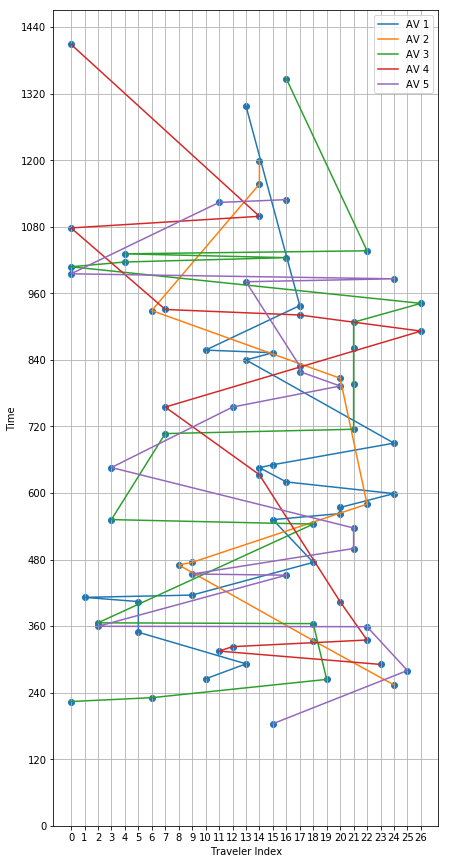

In [48]:
pod.plot_route_info_schedule(darp_solution2['route_info'],community_trips,num_cav)

In [49]:
community_route_info=darp_solution2['route_info']

In [50]:
community_route_info[community_route_info.hh_vehicle_id==1]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index,p_id
0,7,5,5,111,7923628,254.0,259.9,259.9,0.1249,254.0,4.1,2034377.0,1.0,0,0,2034377.0_0_1.0,24
1,5,7,111,16,0,259.9,334.0,334.0,0.0100,264.0,0.0,2034377.0,1.0,0,1,2034377.0_1_1.0,-1
2,7,17,16,122,6925730,334.0,339.3,339.3,0.0432,334.0,0.0,2034377.0,1.0,0,2,2034377.0_2_1.0,18
0,7,5,33,139,3260908,470.3,474.5,494.2,0.0318,490.0,3.8,972024.0,1.0,0,0,972024.0_0_1.0,8
1,5,2,139,32,0,474.5,475.0,475.0,0.0100,498.0,0.0,972024.0,1.0,0,1,972024.0_1_1.0,-1
2,2,7,32,138,3260909,475.0,479.0,479.0,0.0318,475.0,11.0,972024.0,1.0,0,2,972024.0_2_1.0,9
0,7,17,46,152,7511987,580.0,584.8,584.8,0.1373,580.0,6.2,2212041.0,1.0,0,0,2212041.0_0_1.0,22
0,11,7,68,174,7511929,807.0,808.4,808.4,0.1470,807.0,2.6,1738127.0,1.0,0,0,1738127.0_0_1.0,20
0,12,7,83,189,3260792,929.0,930.6,930.6,0.1509,929.0,0.4,1309779.0,1.0,0,0,1309779.0_0_1.0,6
0,2,13,101,207,5983094,1157.0,1161.1,1161.1,0.1585,1157.0,37.9,937968.0,1.0,0,0,937968.0_0_1.0,14


In [ ]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

route_info_allcartrips15,darp_solutions_allcartrips_temp15=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU,transit_zone_dict)

In [ ]:
import pickle
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcartrips15.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcartrips_temp15,'darp_solutions',output_filepath)

In [ ]:
darp_solutions_allcartrips_temp15

In [ ]:

if not os.path.exists(route_info_path):
    os.makedirs(route_info_path)
route_info_allcartrips15.to_csv(route_info_path+'route_info.csv')

vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
dtd.route_to_vehiclepathdat(route_info_allcartrips,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
allcar_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
allcar_target_trips=allcar_target_trips[(allcar_target_trips.orig_taz!=allcar_target_trips.dest_taz) 
                                        | (allcar_target_trips.trip_counter==1)]
allcar_target_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag','hh_id'],inplace=True)

In [ ]:
target_solution

In [ ]:
i=0
target_hh_id=241508
for solution in darp_solutions_allcartrips_temp15:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp=solution['route_info'].hh_id.iloc[0]
        if (temp)==(target_hh_id):
            target_solution=solution
#     i=i+1

pod.plot_route_info_schedule(target_solution['route_info'],
                             allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],num_cav)

In [ ]:
pod.analysis_result(target_solution,allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],Vehicular_Skim_Dict,superzone_map)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
value_of_time_discount_factor=0.9
target_trips['value_of_time']=target_trips['value_of_time']*value_of_time_discount_factor

route_info_modechioce09,darp_solutions_modechoice09=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

In [ ]:
run_name='modechoice09/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_modechioce09.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_modechoice09,'darp_solutions',output_filepath)
vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'

z=route_info_modechioce09
external_vehicle_filepath='Input/external_vehicle50.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath+'external50/'
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
z=dtd.preprocess_routeinfo_for_vehicledat(z)
dtd.route_to_vehiclepathdat(z,origin_links,output_filepath,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
target_trips.value_of_time=target_trips.value_of_time*0.8
route_info_modechoice08,darp_solutions_modechoice08=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*5
drivingcost_per_mile=1
reward_mode=0
darp_solutions1=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

# for num_cav in [2]: #range(1,4):
#     for share_ride_factor in [1]: #[1,1.25,1.5]:
#         for time_window_flag in [0]:
num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions1.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime)])

In [ ]:
#!/usr/bin/env python
import random
import pylab
from matplotlib.pyplot import pause

pylab.ion()
Gnormal=nx.Graph()
color_map=[]
for i in node_detail:
    color_map.append('blue')
# nx.draw_networkx_nodes(Gnormal, pos,node_list=[1,2,4],node_color='red',node_size=4)
def get_fig():
    global color_map
    for nodeinf in node_detail:
        node=nodeinf[0,0]
        Gnormal.add_node(node,pos=(nodexy[node][0],nodexy[node][1]))
    for linkinf in link_detail: 
        Gnormal.add_edge(linkinf[0,0],linkinf[0,1])

    pos=nx.get_node_attributes(Gnormal,'pos')
    nx.draw(Gnormal,pos,node_size=10,node_color=color_map )
num_plots = 50;
pylab.show()
for i in range(num_plots):
    color_map[i]='red'
    get_fig()
    pylab.draw()
    pause(2)

In [ ]:
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]

In [ ]:
analyzed_results4=pd.DataFrame()
for solution in darp_solutions4:
        analyzed_results4=analyzed_results4.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_time'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
sorted_trips.head()

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_distance'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
analyzed_results.columns

In [ ]:
analyzed_results4

In [ ]:
len(darp_solutions4[0]['route_info'])

In [ ]:
analyzed_results4.loc[analyzed_results4.share_ride_factor==1].transpose()

In [ ]:
zz.hh_vehicle_id.unique()

In [ ]:
for i in range(3):
    print(len(zz.loc[zz.hh_vehicle_id==i]))

In [ ]:
zz=darp_solutions4[-1]['route_info']
# zz=darp_solutions4[5]['route_info']
# zz['origin_network_node','dest_network_node']=zz.apply(lambda row: dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
for car_id in range(3):
    nodes=[]
    for index, row in zz.loc[zz.hh_vehicle_id==car_id].iterrows():
        nodes.extend(dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
    av.zone_node_highlight(nodes,node_detail,link_detail,nodexy,'r')

In [ ]:
darp_solutions4[-1]['route_info'].head()

In [ ]:
pod.plot_route_info_schedule(darp_solutions4[-1]['route_info'],sorted_trips,3)

In [ ]:
analyzed_results4.columns

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_schedule_penalty'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor')
plt.pyplot.ylabel('Total Late/Early Arrival')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,'Total_early_time'].apply(lambda x: abs(x))+analyzed_results4.loc[analyzed_results4.num_cav==i,'total_delayed_time'].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_travel_cost'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor ')
plt.pyplot.ylabel('Total Generalized Travel Cost')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
len(darp_solutions4[-1]['route_info'])

In [ ]:
for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
    plt.pyplot.figure()
    plt.pyplot.xlabel('share ride factor')
    plt.pyplot.ylabel(factor)
    for i in range(1,4):
        line_label=str(i)+' Cav'
        plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
    plt.pyplot.legend()

In [ ]:
for i in darp_solutions:
    print(i['num_cav'],i['share_ride_factor'])

In [ ]:

route_info.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
route_info.apply(lambda row:prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile) ,axis=1).sum()

In [ ]:
from Modules import Preprocess_DARP as prd

In [ ]:
for j in [2,5,8] :   
    z=darp_solutions4[j]['route_info']
    for i in range(3):
        zz=z.loc[z.hh_vehicle_id==i]
        if len(zz)>0:
            total_driving_time_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
            total_driving_distance_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile),axis=1).sum()
            num_pickup_trips=len(zz.loc[zz.orig_node_index<=len(sorted_trips)])
            print(i,j,len(zz),num_pickup_trips,total_driving_time_temp,total_driving_distance_temp)

In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions4[2]['route_info'],sorted_trips,darp_solutions4[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions4[5]['route_info'],sorted_trips,darp_solutions4[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions4[8]['route_info'],sorted_trips,darp_solutions4[8]['num_cav'])



In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions[2]['route_info'],sorted_trips,darp_solutions[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions[5]['route_info'],sorted_trips,darp_solutions[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions[8]['route_info'],sorted_trips,darp_solutions[8]['num_cav'])


In [ ]:
Vehicular_Skim.loc[18,15,1,1]

In [ ]:
zz1=solution['route_info']

In [ ]:
zz1.dest_zone=zz1.dest_zone.apply(lambda x: int(x))

In [ ]:
analyzed_results3=pd.DataFrame()
for solution in darp_solutions3:
    analyzed_results3=analyzed_results3.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results3.transpose().to_csv('Output/hh_level_result3.csv')

In [ ]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [ ]:
analyzed_results.transpose()

### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

#### Result Analysis